# Fintech Churn predictive model
The following project aims at predicting the churn of users in the 30 days following his activation day (first transaction). We understand churn as no transaction made.
To do so, only user information obtained up to that 1st completed transaction will be used. 
This means that, from the moment a user made his 1st completed transaction, we will be able to predict whether a user will transact again in the next 30 days or not.

# Import libraries

In [1]:
# Classic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import cv
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from hyperopt import STATUS_OK
from hyperopt import hp
from hyperopt import fmin, tpe, Trials
import pickle

# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Read data

In [2]:
# The data was originally pulled with a SQL query from a PostgreSQL database and stored as a csv file.
data = pd.read_csv('data.csv', index_col='user_id')

# EDA - Exploratory data analysis

## Cast variables correctly

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150172 entries, 0000b1bc-8e2b-4f30-8918-324faabbc729 to fffffabb-5bd8-4c86-b3e6-99ebb5088cf8
Data columns (total 39 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   canal                             150172 non-null  object             
 1   media_source                      150172 non-null  object             
 2   fecha_registro                    150172 non-null  datetime64[ns, UTC]
 3   fecha_completo_datos              149326 non-null  datetime64[ns, UTC]
 4   fecha_validado                    150172 non-null  datetime64[ns, UTC]
 5   fecha_1ra_cuenta_propia           150172 non-null  datetime64[ns, UTC]
 6   fecha_1ra_transacion              150172 non-null  datetime64[ns, UTC]
 7   fecha_1ra_transacion_completed    150172 non-null  datetime64[ns, UTC]
 8   product_1ra_transacion            150172 non-null  object       

In [9]:
def string_to_datetime(data, cols):
    data[cols] = data[cols].apply(pd.to_datetime)
    return data
    
def bool_to_binary(data,cols):
    data[cols] = data[cols]*1
    return data

def filter_by_date(data,date_col,date):
    data = data.loc[data[date_col]>=date,:].sort_values(by=date_col)
    return data

In [10]:
data = string_to_datetime(data,['fecha_registro','fecha_completo_datos','fecha_validado','fecha_1ra_cuenta_propia','fecha_1ra_transacion','fecha_1ra_transacion_completed'])
data = bool_to_binary(data,'transfer_between_own_accounts')
data = filter_by_date(data,'fecha_registro','2021-03-01') #Pensar si vale la pena considerar usuarios sin source de antes de marzo

## Variables exploration

### Describe

In [11]:
# Describe básico de variables numéricas
data.describe()

amount  transfer_between_own_accounts  actividad_principal  \
count  145446.000000                  145446.000000        145446.000000   
mean      457.695952                       0.406185             0.235751   
std      2235.221539                       0.491122             0.424469   
min         0.010000                       0.000000             0.000000   
25%         5.000000                       0.000000             0.000000   
50%        20.000000                       0.000000             0.000000   
75%       189.000000                       1.000000             0.000000   
max     75000.000000                       1.000000             1.000000   

       cant_attempts        ret_30d            age  device_screen_width  \
count  145446.000000  145446.000000  144601.000000        145297.000000   
mean        0.281795       1.757078      30.682817           814.397778   
std         1.039335       4.118454      10.898525           236.002250   
min         0.000000       0.000000      10.000000           320.000000   
25%         0.000000       0.000000      23.000000           720.000000   
50%         0.000000       0.000000      28.000000           720.000000   
75%         0.000000       2.000000      35.000000          1080.000000   
max        81.000000     591.000000     221.000000          2960.000000   

       device_screen_height  limite_ampliado  cant_contactos_bancos  \
count         145297.000000    145446.000000          145446.000000   
mean            1572.072637         0.007563               0.053085   
std              468.714187         0.086636               0.252311   
min              540.000000         0.000000               0.000000   
25%             1344.000000         0.000000               0.000000   
50%             1448.000000         0.000000               0.000000   
75%             2060.000000         0.000000               0.000000   
max             3120.000000         1.000000              12.000000   

       cant_contactos_ank  cantidad_de_cuentas  cantidad_de_bancos  \
count       145446.000000        145446.000000       145446.000000   
mean             2.200535             1.517931            1.506497   
std              4.025109             0.717992            0.701537   
min              0.000000             0.000000            0.000000   
25%              0.000000             1.000000            1.000000   
50%              1.000000             1.000000            1.000000   
75%              3.000000             2.000000            2.000000   
max            430.000000            16.000000           15.000000   

        cantidad_cvu   cantidad_cbu  
count  145446.000000  145446.000000  
mean        0.421270       1.096661  
std         0.612665       0.350010  
min         0.000000       0.000000  
25%         0.000000       1.000000  
50%         0.000000       1.000000  
75%         1.000000       1.000000  
max         6.000000      12.000000

### Analysis of target variable ret_30d

In [12]:
def create_label_variable(data,target,threshold=0):
    data["label"] = 0
    data.loc[data[target] > threshold,"label"] = 1
    return data

In [13]:
data = create_label_variable(data,"ret_30d",0)

<AxesSubplot:>

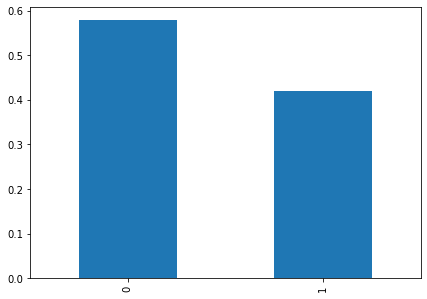

In [14]:
plt.subplots(figsize=(7,5))
(data.label.value_counts()/len(data)).plot(kind='bar')

### Variables distribution analysis

#### Categorical variables

In [15]:
var_cat = data.drop(columns="first_name").select_dtypes(include='object').columns

canal


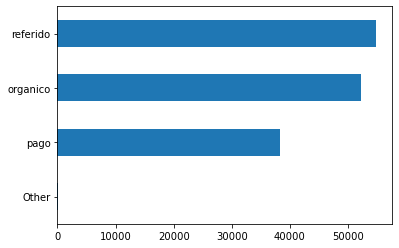

media_source


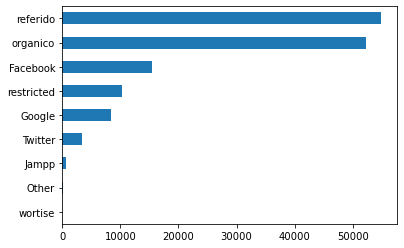

product_1ra_transacion


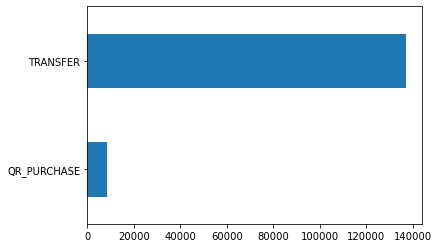

product_1ra_transacion_completed


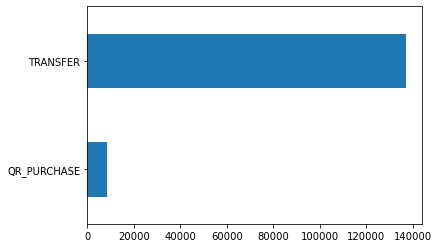

debit_account_bank


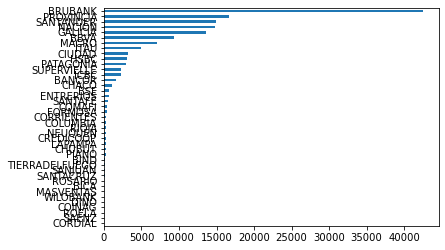

credit_account_bank


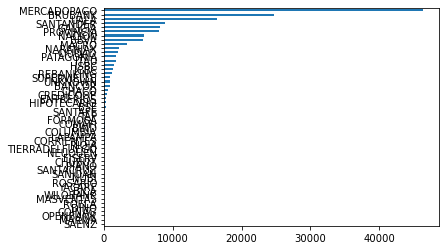

credit_account_type


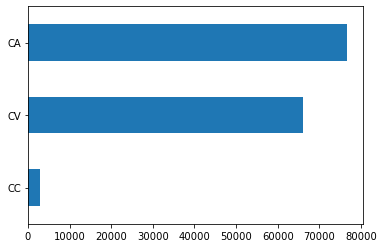

lookup_key_type


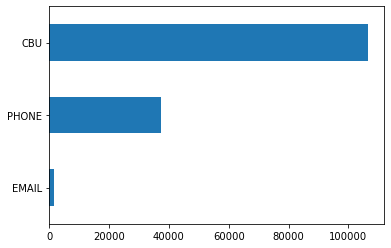

gender


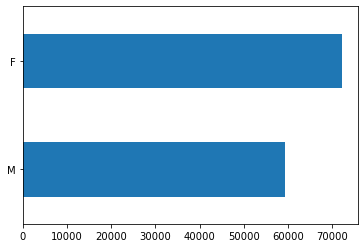

age_group


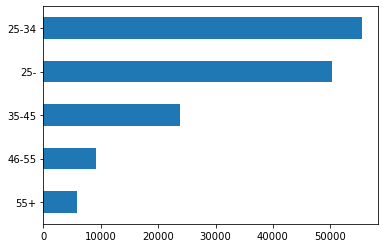

prov_region


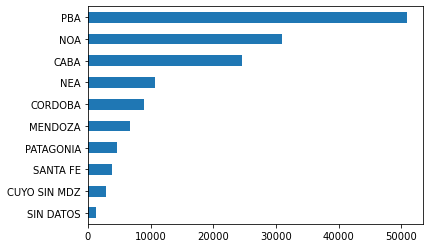

provincia


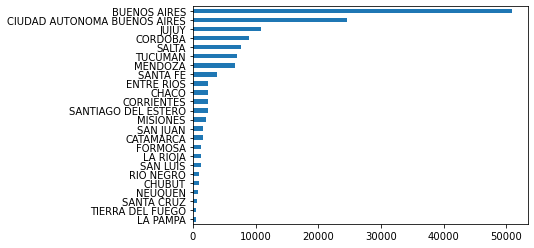

device_manufacturer


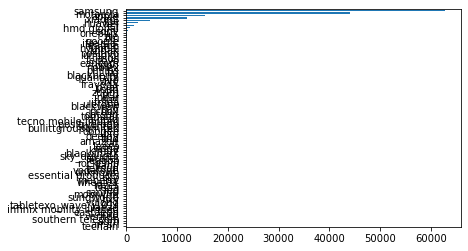

device_model


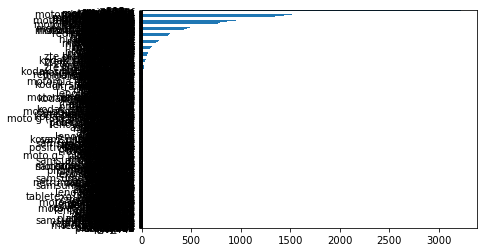

device_type


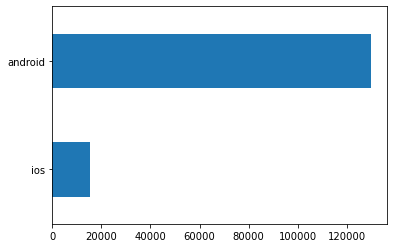

carrier


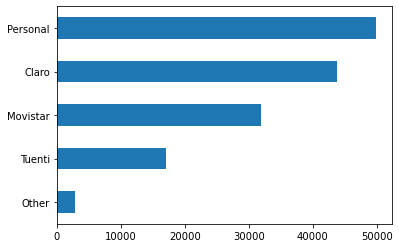

cuenta_principal


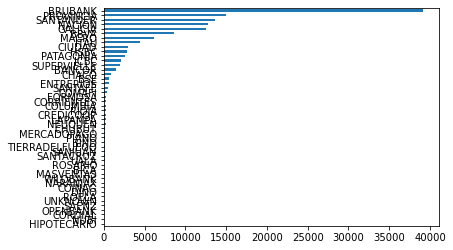

In [16]:
for i in var_cat:
    print(i)
    data[i].value_counts().sort_values(ascending=True).plot(kind='barh')
    plt.show()

#### Numeric variables

In [17]:
def display_dataset_distribution(dataset):
    fig = dataset.hist(xlabelsize=12,ylabelsize=12, figsize=(40,20))
    [x.title.set_size(16) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

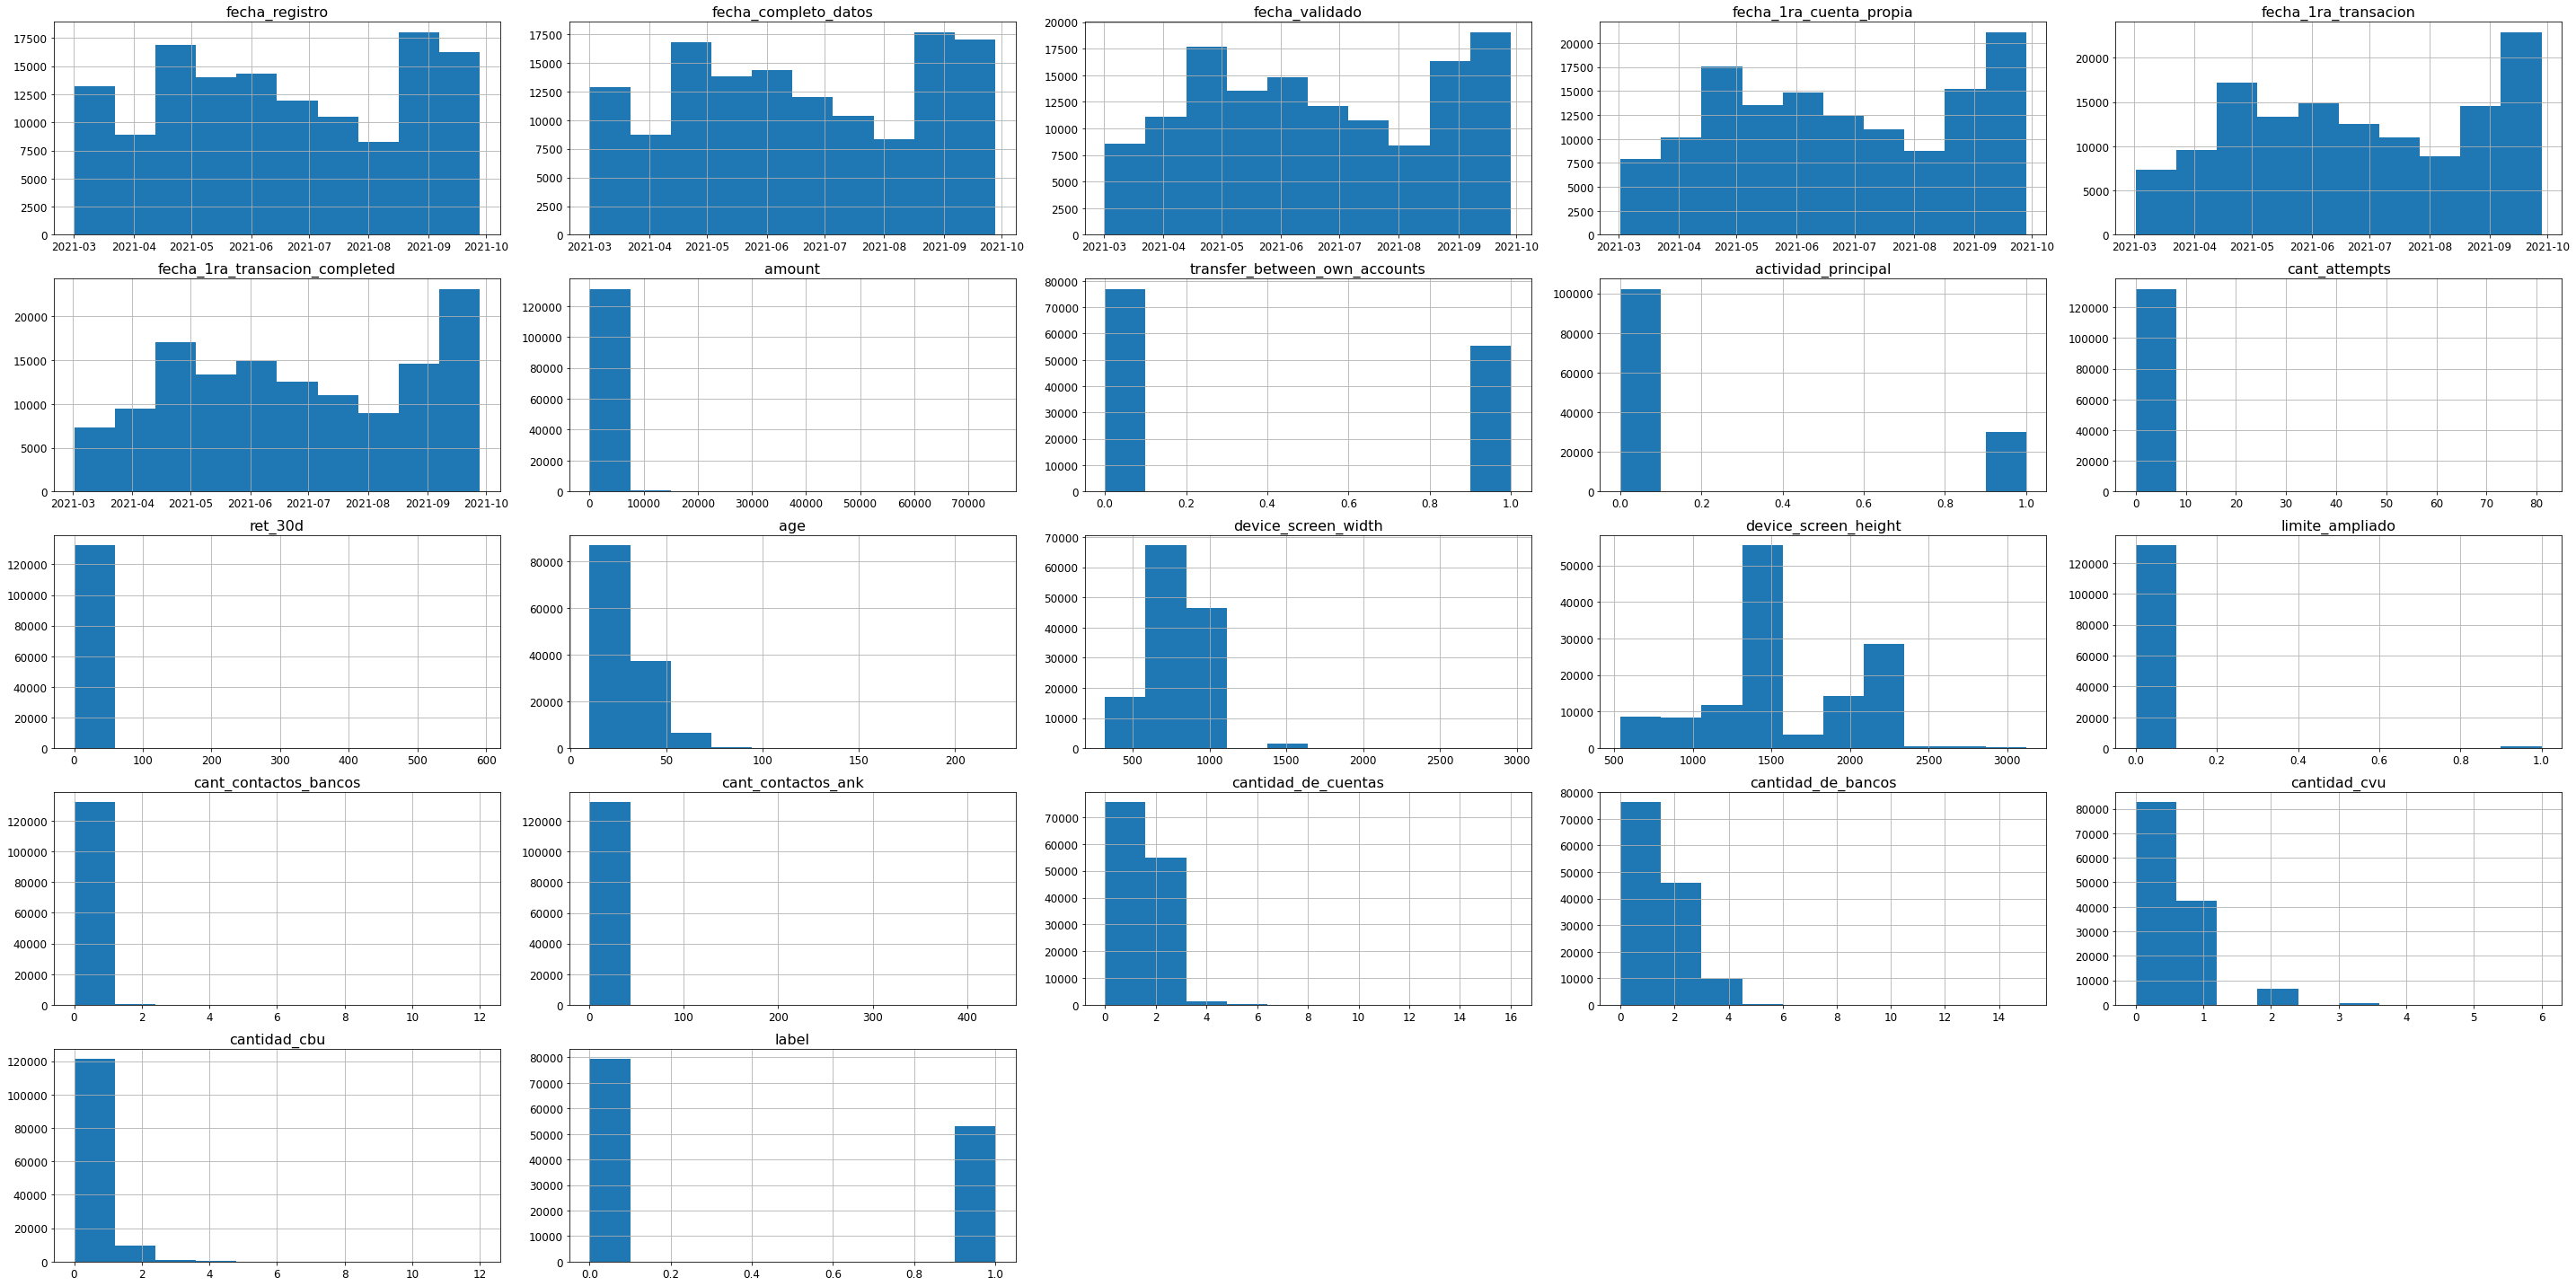

In [137]:
display_dataset_distribution(data)

### Analysis of the relationship between the label and each independent variable

#### Categorical variables

In [138]:
# Función para comparar distribuciones de variables categóricas
def compare_dists(data,col,label):
    data0 = pd.DataFrame(data.loc[data[label]==0,col].value_counts(normalize=True, sort=False))
    data1 = pd.DataFrame(data.loc[data[label]==1,col].value_counts(normalize=True, sort=False))
    data_x = data0.merge(data1,how="outer", left_index=True, right_index=True, suffixes=('_0','_1'))
    data_x = data_x.sort_values(by=data_x.columns[0], ascending=False)
    col0 = data_x.columns[0]
    col1 = data_x.columns[1]
    plt.subplots(figsize=(15,8))
    plt.title(col)
    data_x[col0].plot(kind='bar',label="not retained", color="red", alpha=0.3)
    data_x[col1].plot(kind='bar',label="retained M1", color="green", alpha=0.3)
    plt.legend()
    plt.show()

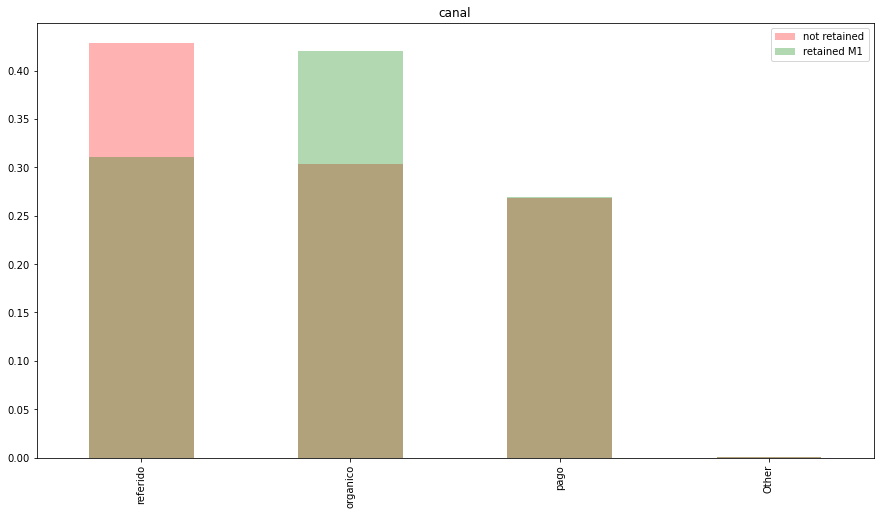

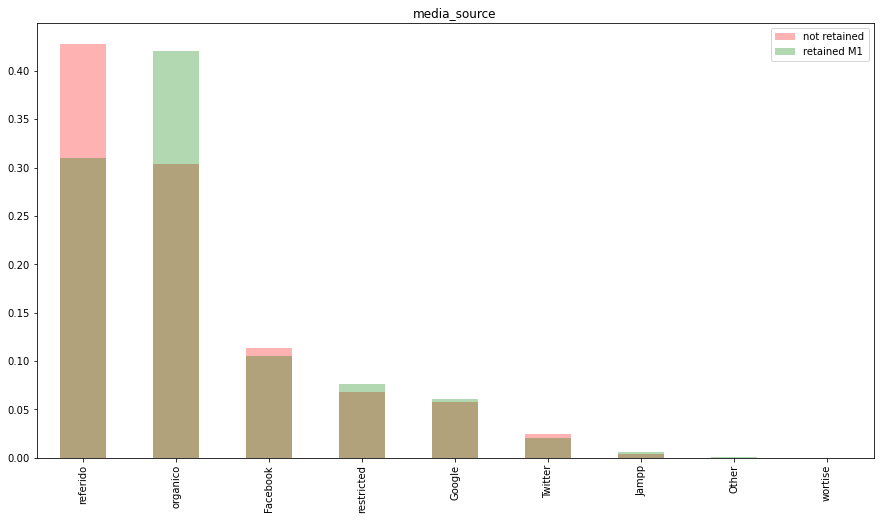

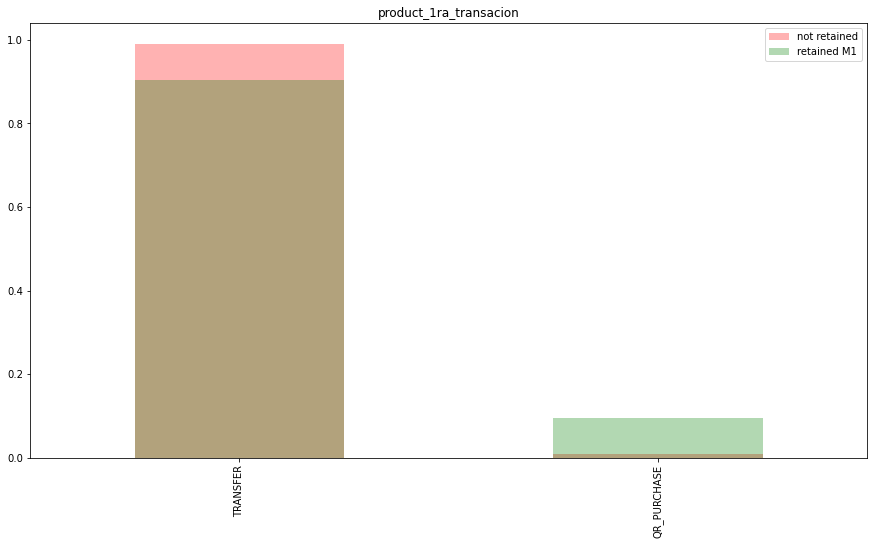

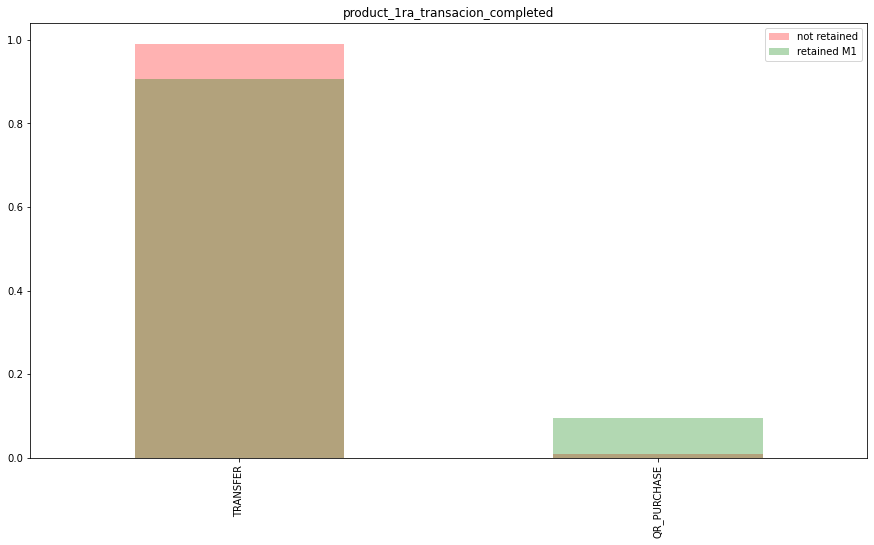

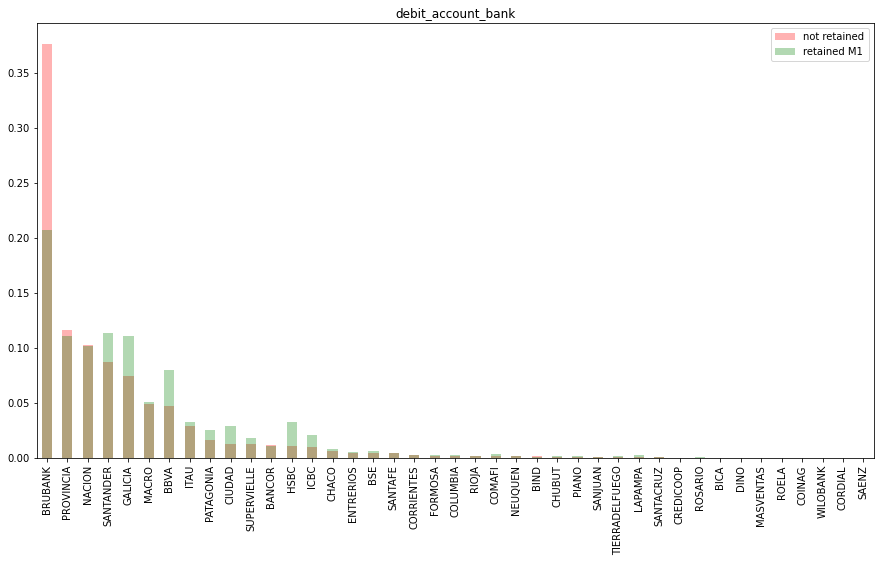

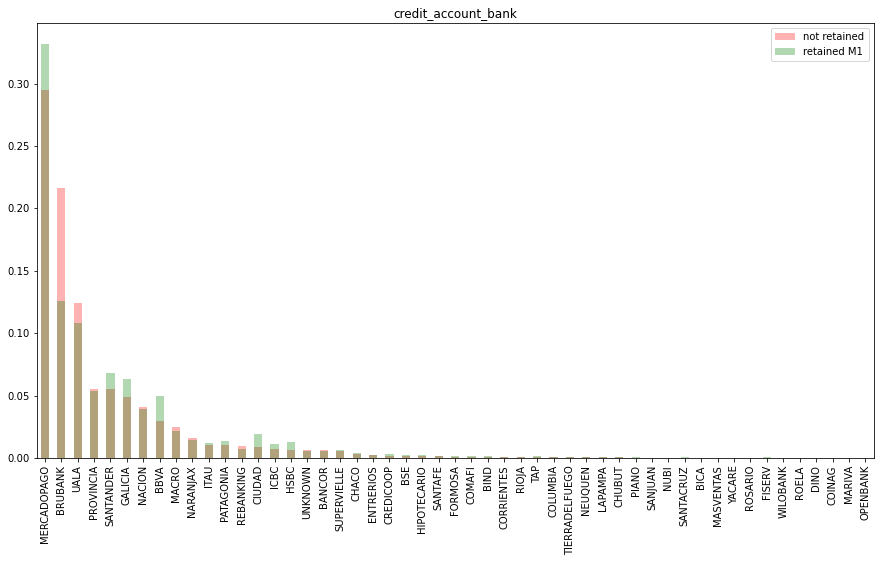

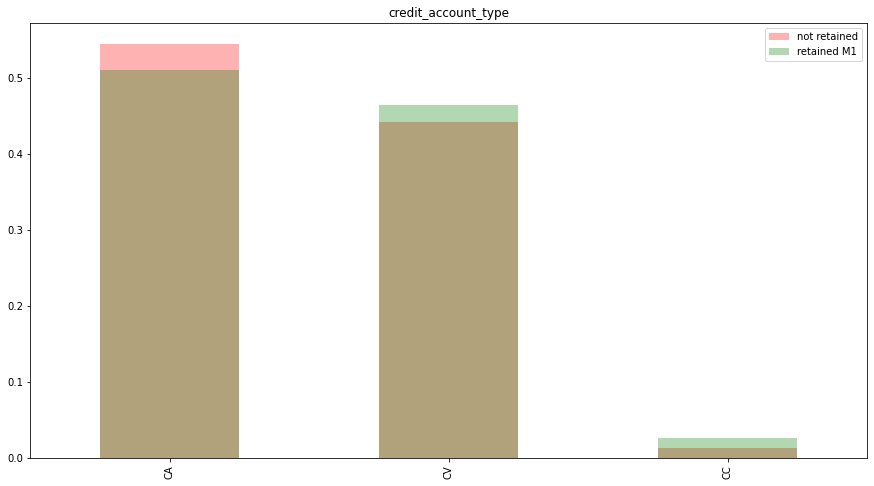

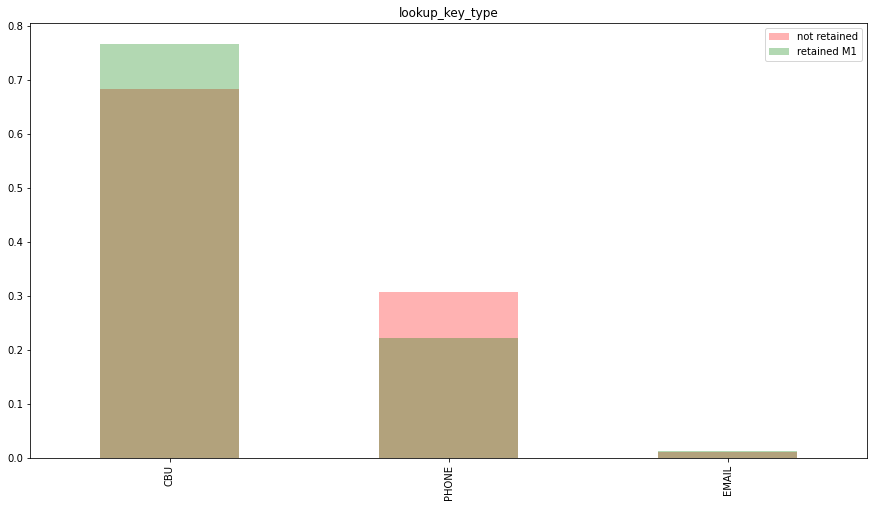

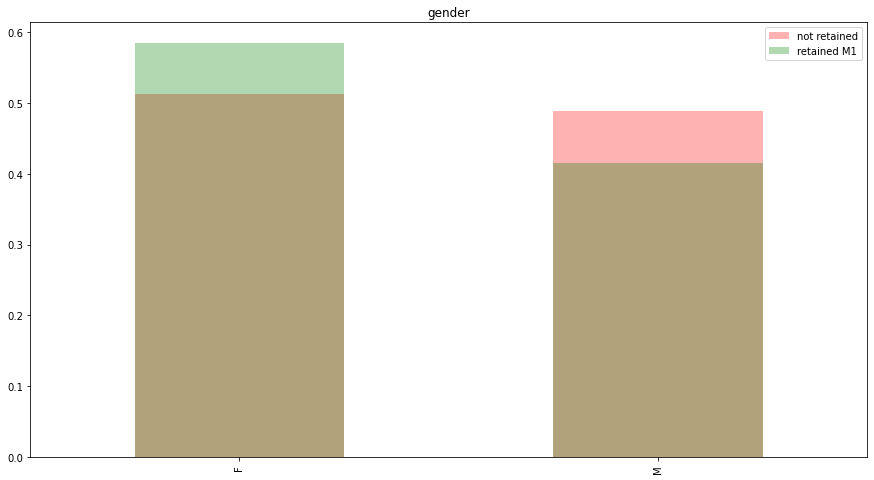

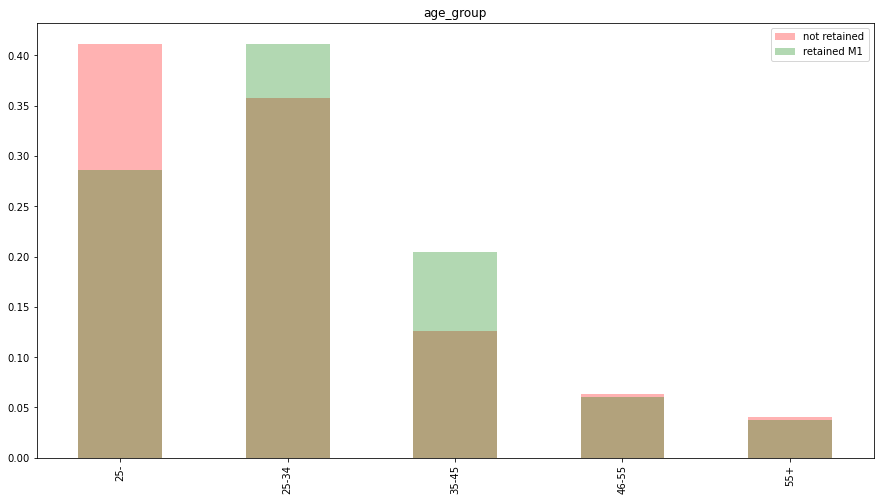

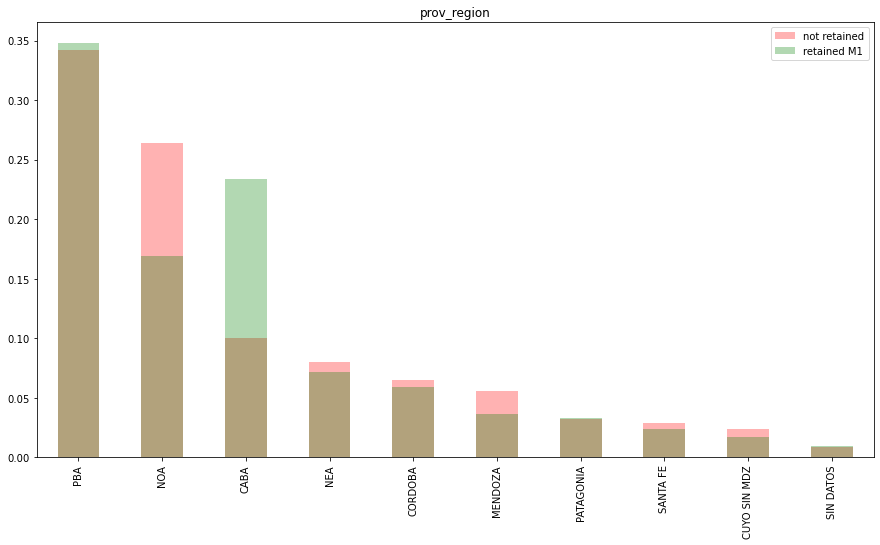

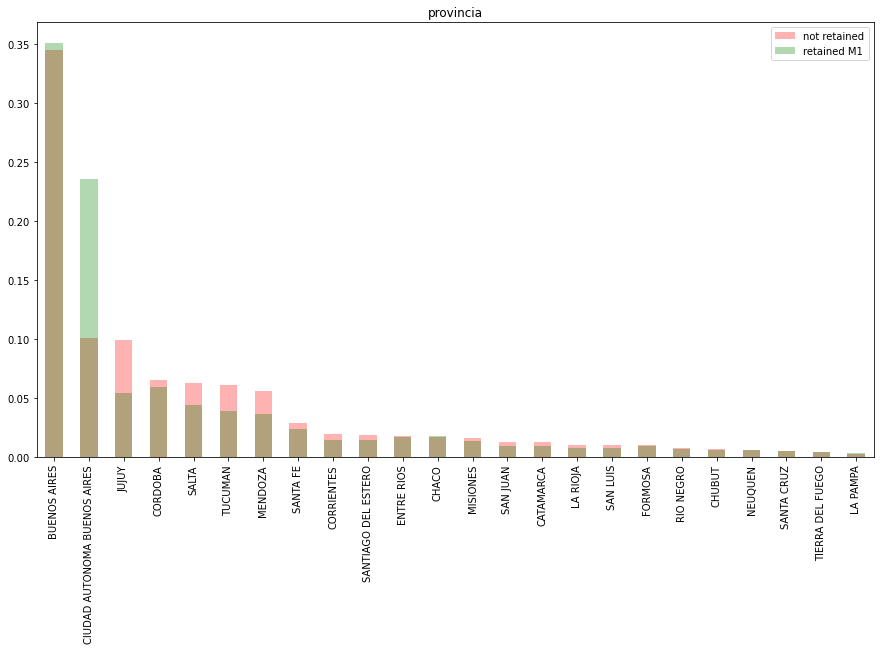

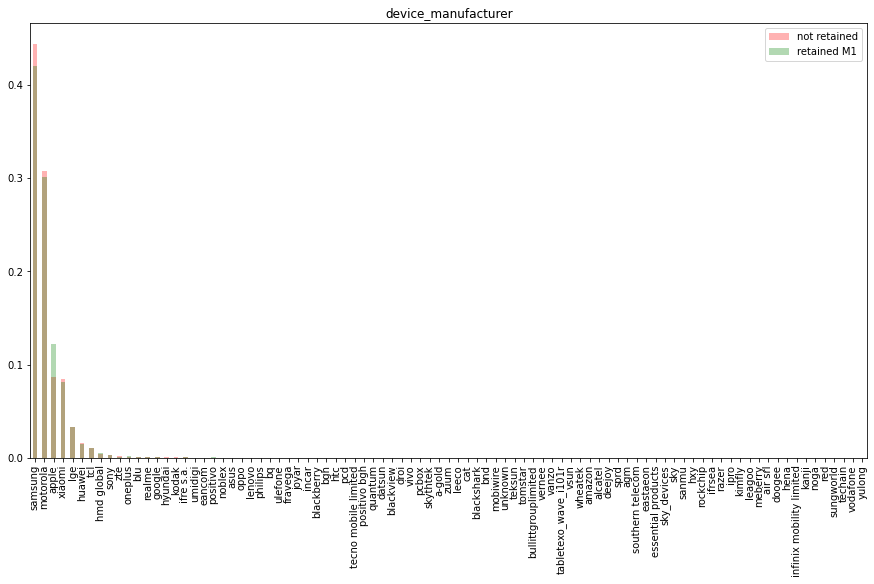

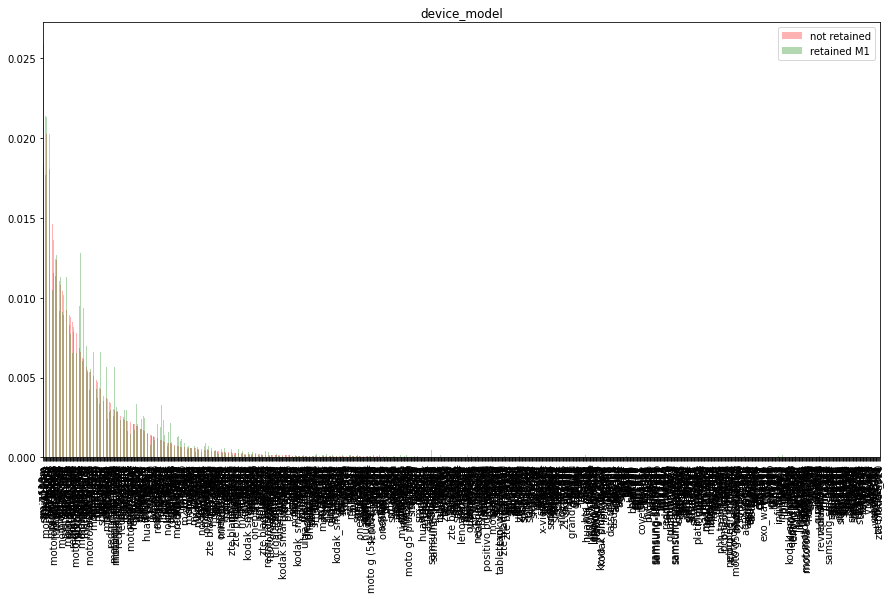

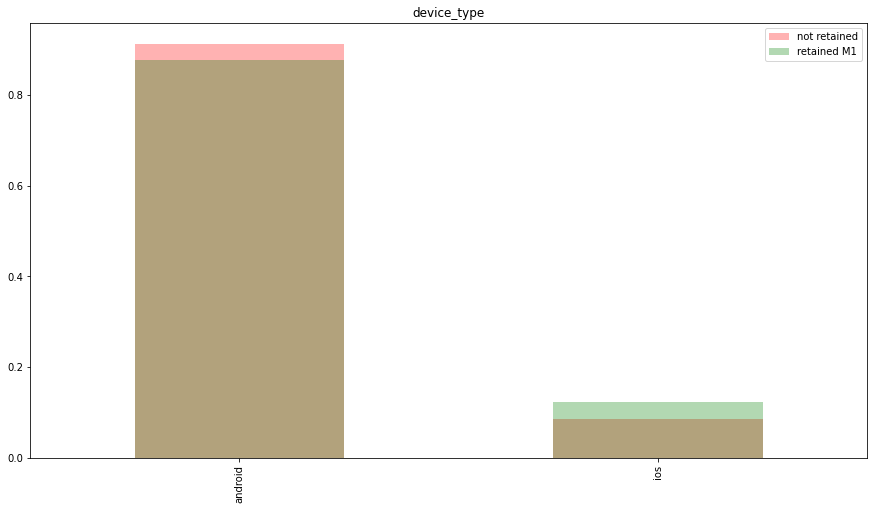

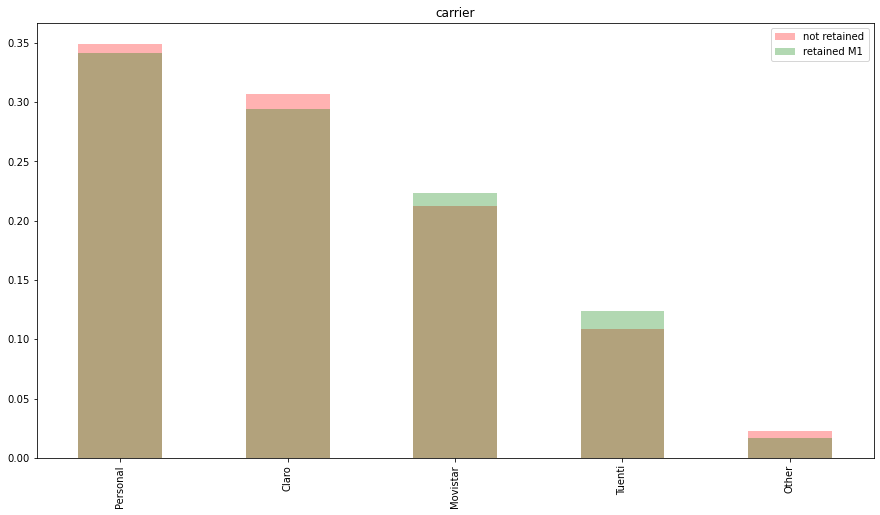

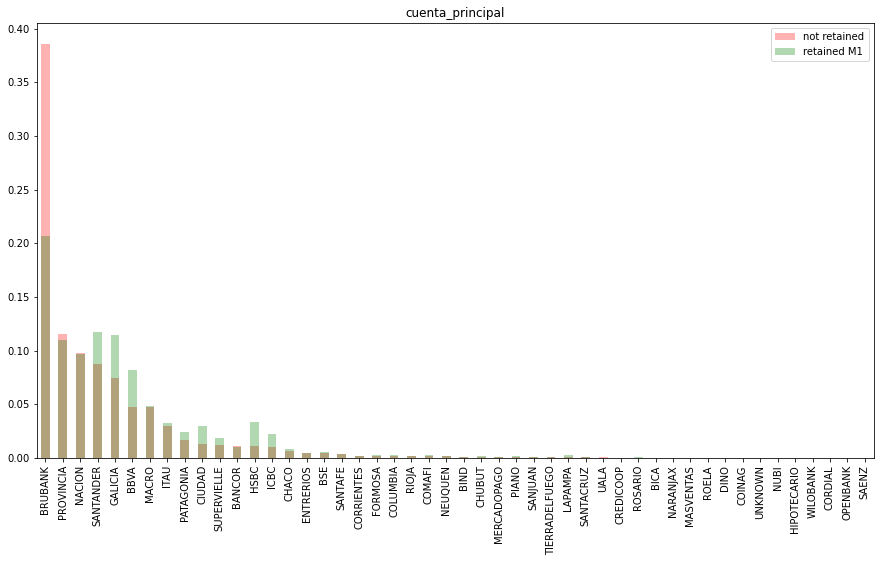

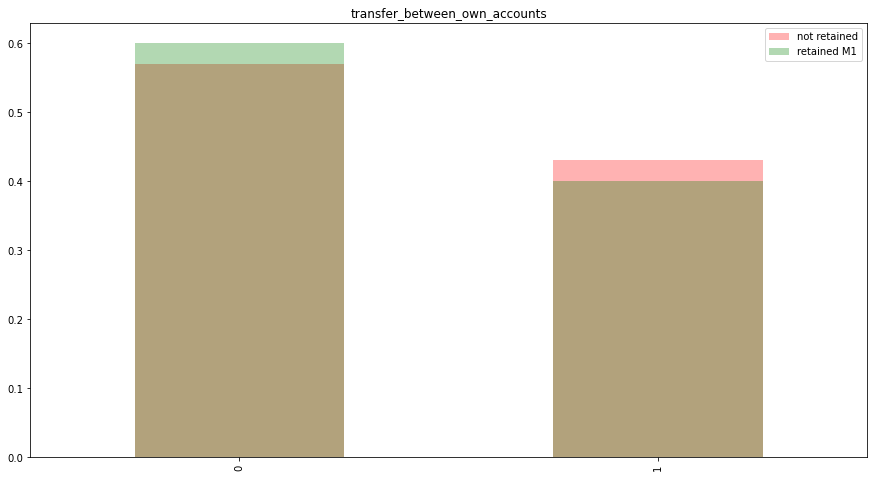

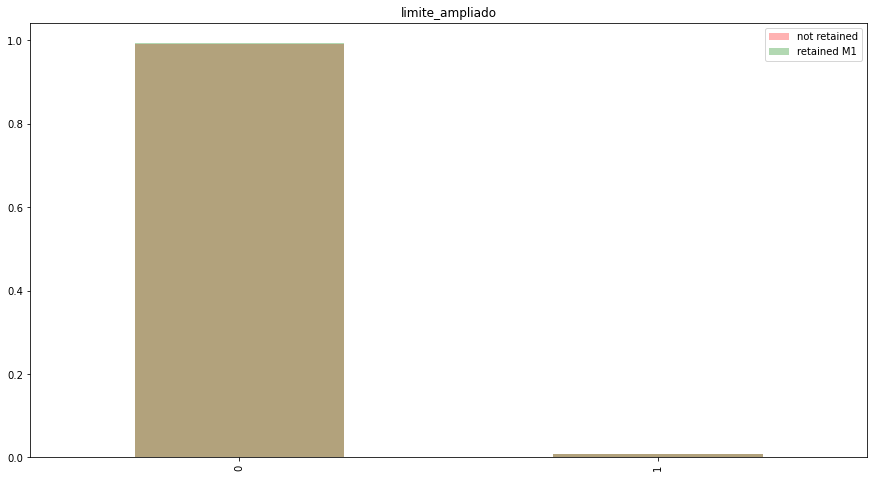

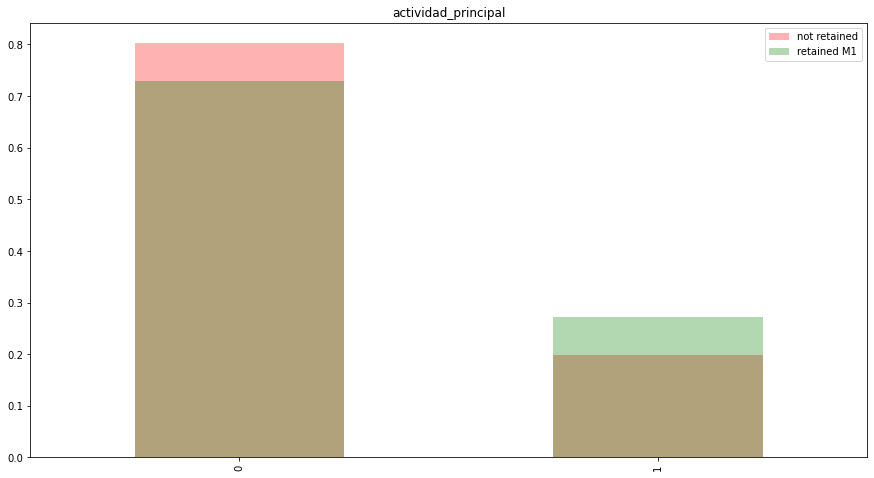

In [139]:
var_cat = data.drop(columns="first_name").select_dtypes(include='object').columns
var_cat = list(var_cat)
var_cat.append("transfer_between_own_accounts")
var_cat.append("limite_ampliado")
var_cat.append("actividad_principal")
for i in var_cat:
    compare_dists(data,i,"label")
#     plt.subplots(1,2, figsize=(30,8), sharey=True)
#     plt.title(i)
#     plt.subplot(1,2,1)
#     data.loc[data["label"]==0,:][i].sort_values().value_counts(normalize=True, sort=False).plot(kind='bar', label="dist 0", color="red")
#     plt.legend()
#     plt.subplot(1,2,2)
#     data.loc[data["label"]==1,:][i].sort_values().value_counts(normalize=True, sort=False).plot(kind='bar', label="dist 1", color="green")
#     plt.legend()
#     plt.subplot(1,4,2)
#     data.groupby(by=i).mean()["label"].sort_values(ascending=False).plot(kind='bar', label="mean ret users M1")
#     plt.legend()
#     plt.subplot(1,4,3)
#     data.loc[data["label"]==1,:].groupby(by=i).mean()["ret_30d"].sort_values(ascending=False).plot(kind='bar', label="mean #Txs per ret user M1")
#     plt.legend()
#     plt.subplot(1,4,4)
#     data.groupby(by=i).mean()["cantidad_de_cuentas"].sort_values(ascending=False).plot(kind='bar', label="mean accts")
#     plt.legend()
#     plt.show()

#### Numeric variables

In [140]:
# Creo una variable amt_bins para segmentar el aamount
data["amt_bins"] = data["amount"]
data.loc[(data["amt_bins"]>0)&(data["amt_bins"]<=100),"amt_bins"] = 100
data.loc[(data["amt_bins"]>100)&(data["amt_bins"]<=300),"amt_bins"] = 300
data.loc[(data["amt_bins"]>300)&(data["amt_bins"]<=500),"amt_bins"] = 500
data.loc[(data["amt_bins"]>500)&(data["amt_bins"]<=1000),"amt_bins"] = 1000
data.loc[(data["amt_bins"]>1000)&(data["amt_bins"]<=2000),"amt_bins"] = 2000
data.loc[(data["amt_bins"]>2000)&(data["amt_bins"]<=5000),"amt_bins"] = 5000
data.loc[data["amt_bins"]>5000,"amt_bins"] = 10000

In [141]:
#Calculamos la cantidad de horas entre cada paso del onboarding
data["hours_OBR-OBC"] = (data["fecha_completo_datos"]-data["fecha_registro"]).astype('timedelta64[s]')/(60*60)
data["hours_OBC-OBV"] = (data["fecha_validado"]-data["fecha_completo_datos"]).astype('timedelta64[s]')/(60*60)
data["hours_OBV-OB1Acc"] = (data["fecha_1ra_cuenta_propia"]-data["fecha_validado"]).astype('timedelta64[s]')/(60*60)
data["hours_OB1Acc-FTUc"] = (data["fecha_1ra_transacion_completed"]-data["fecha_1ra_cuenta_propia"]).astype('timedelta64[s]')/(60*60)

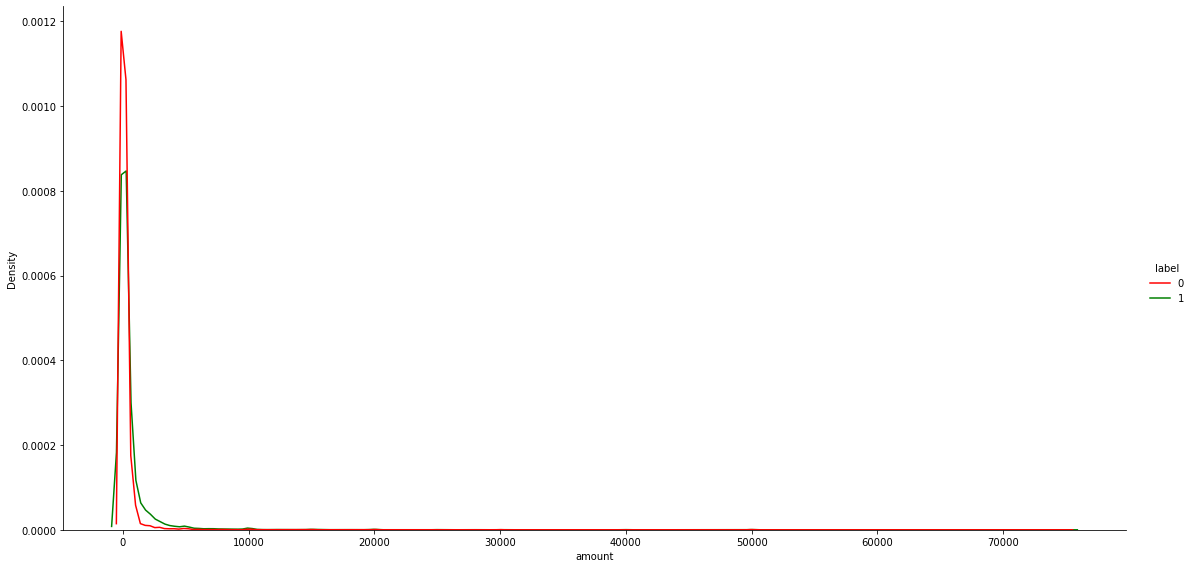

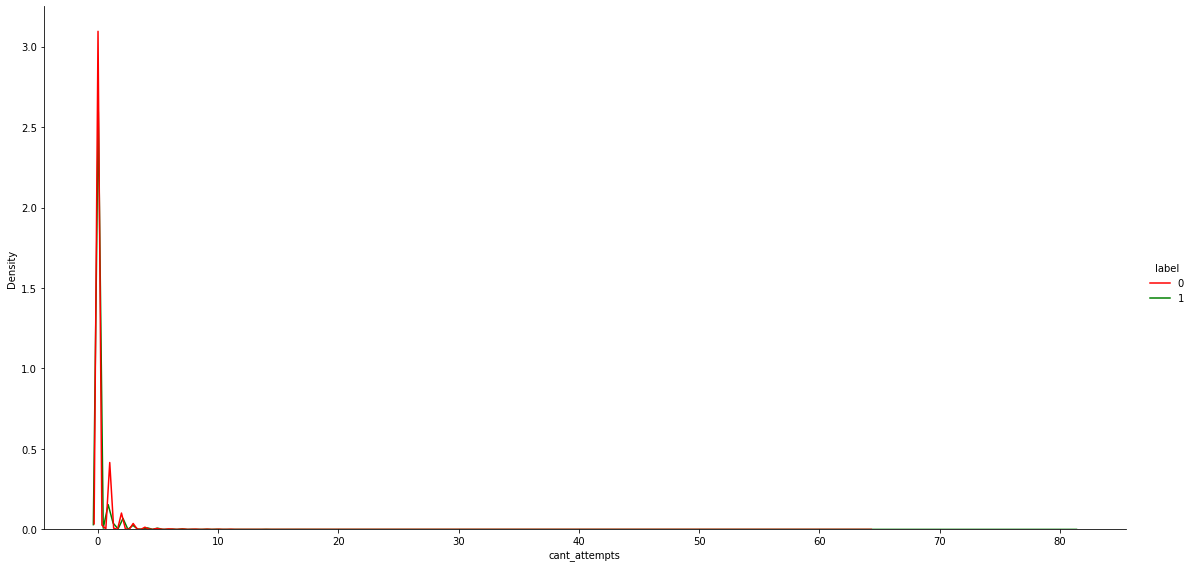

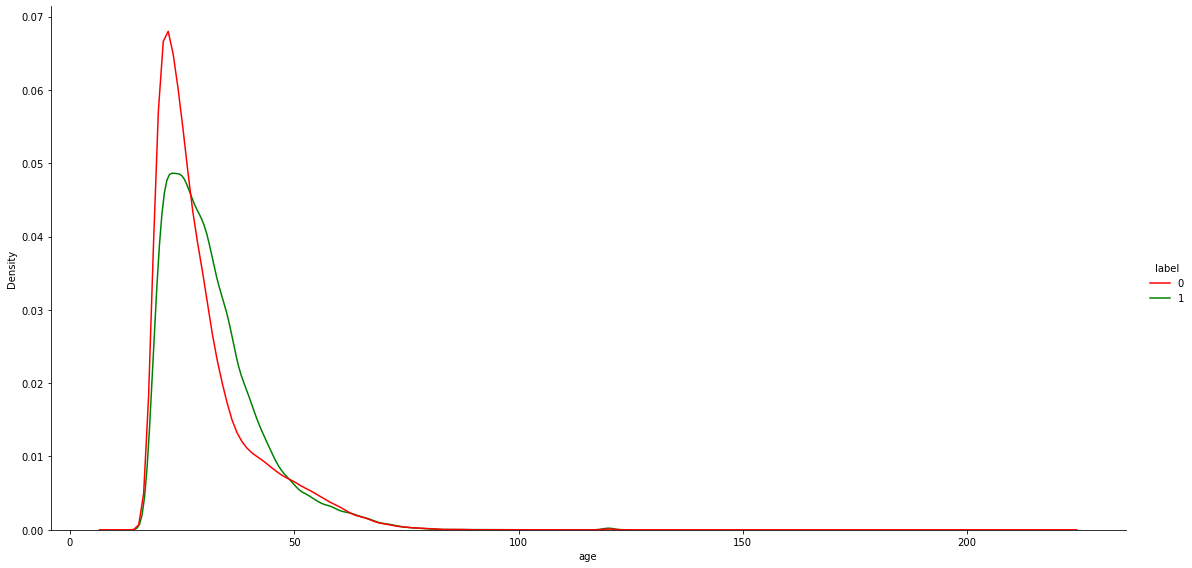

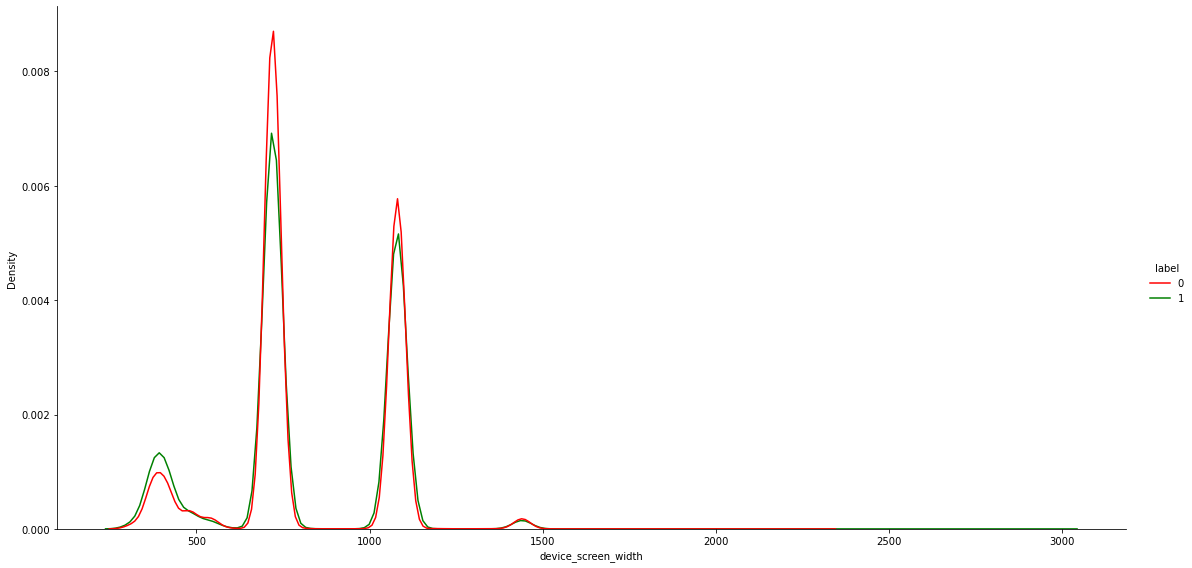

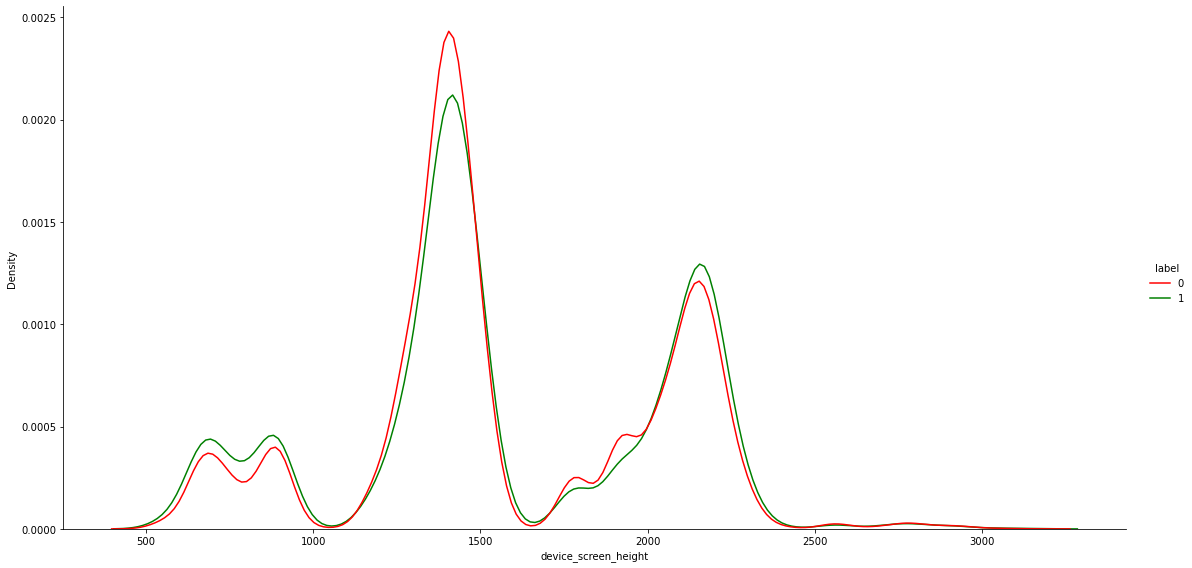

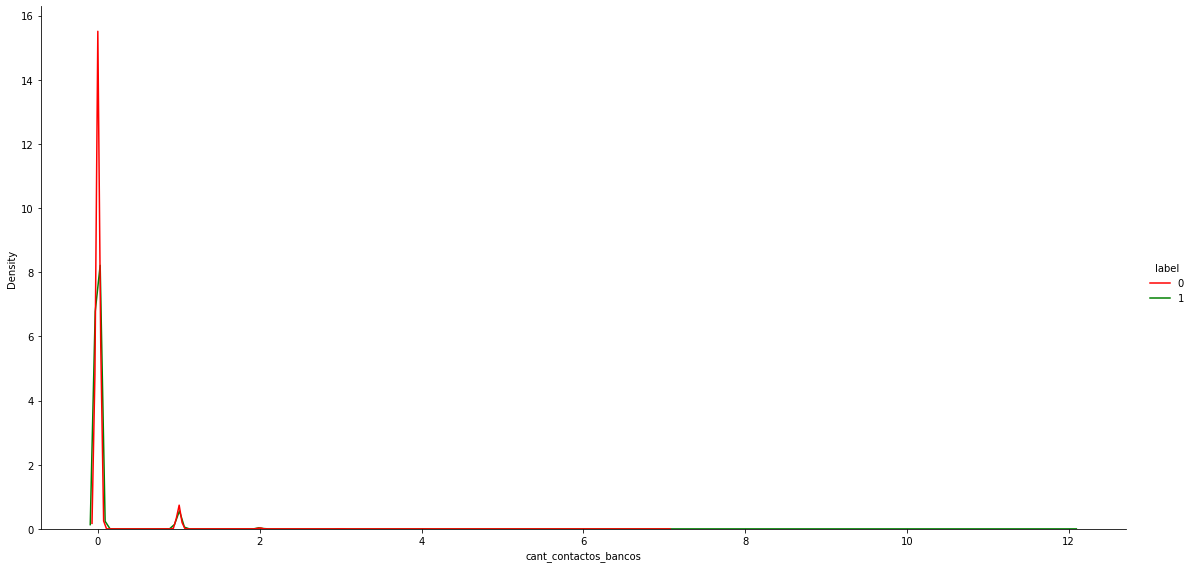

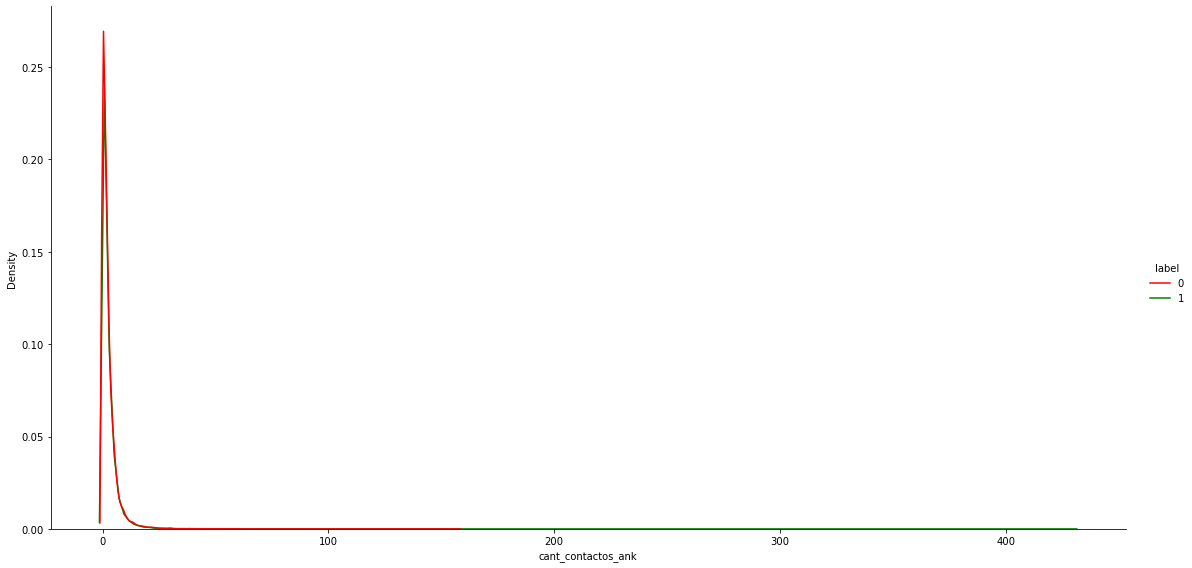

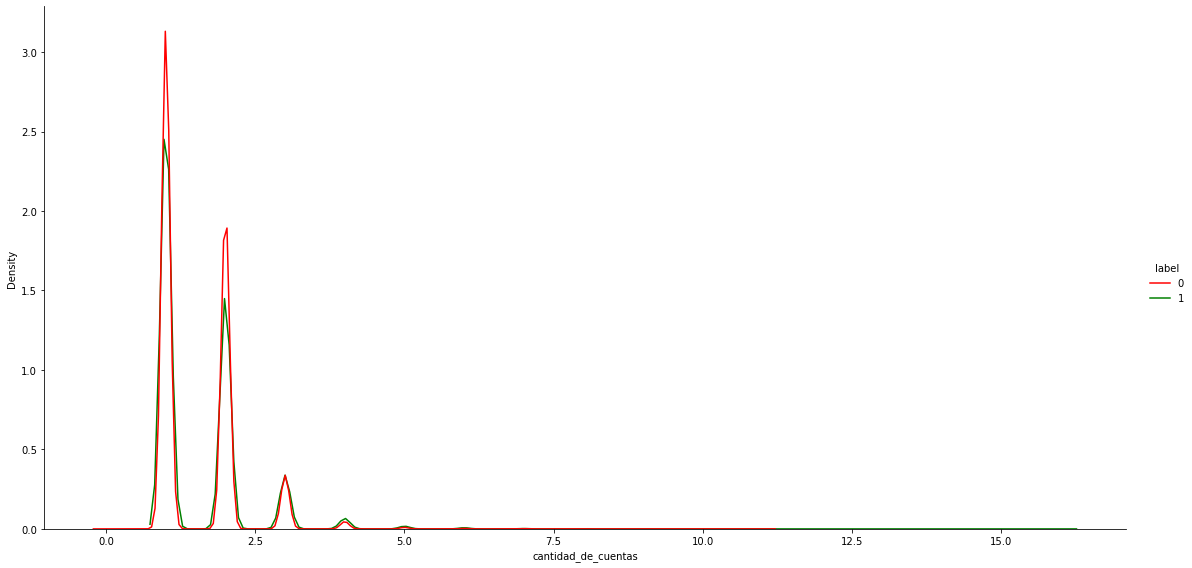

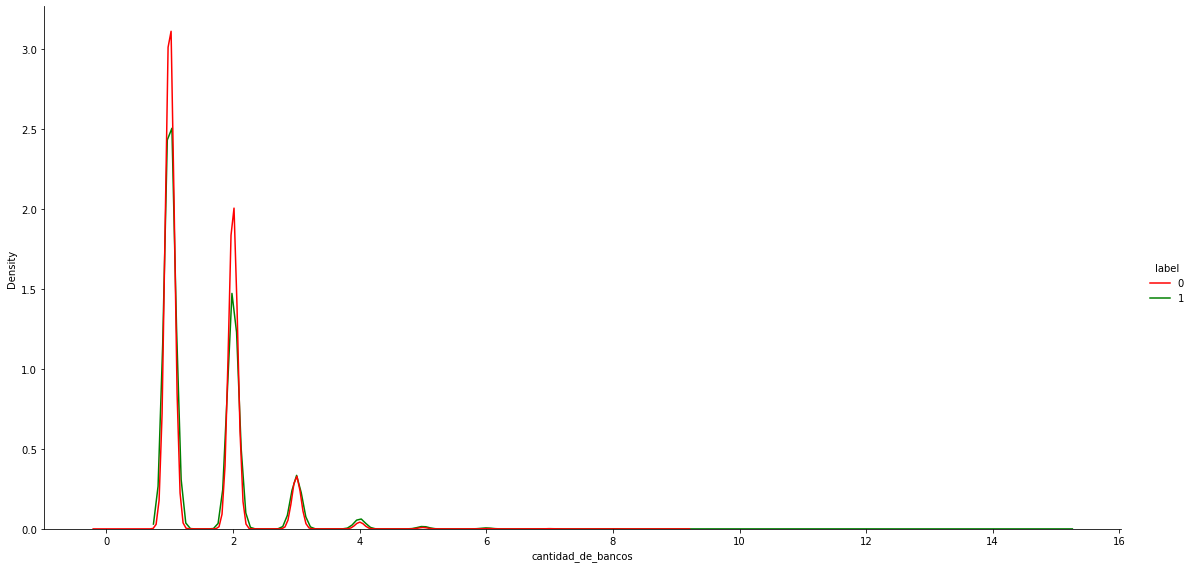

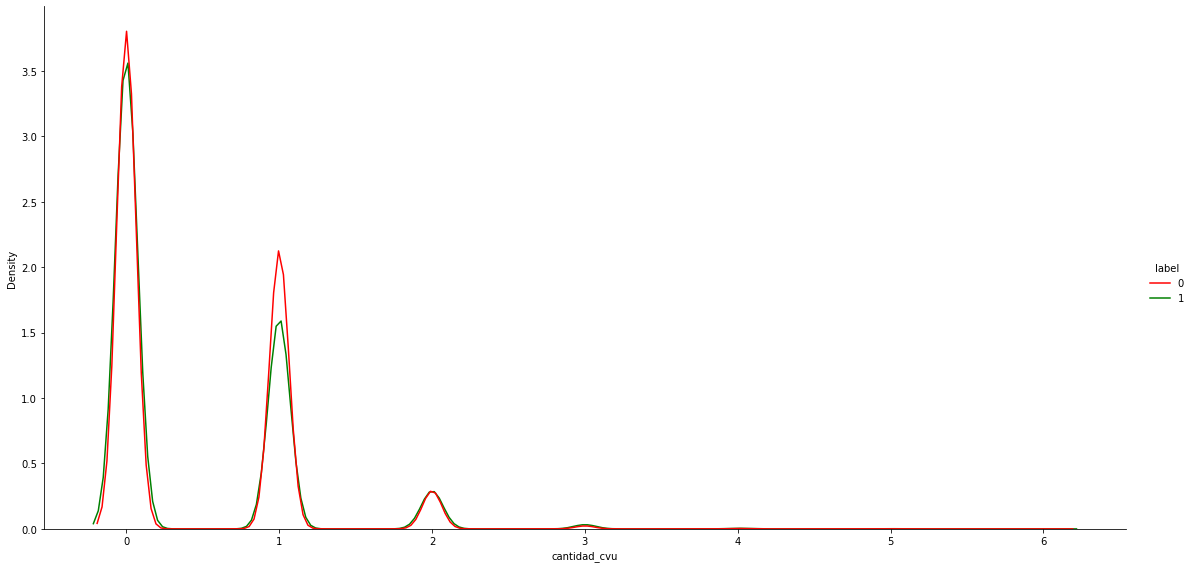

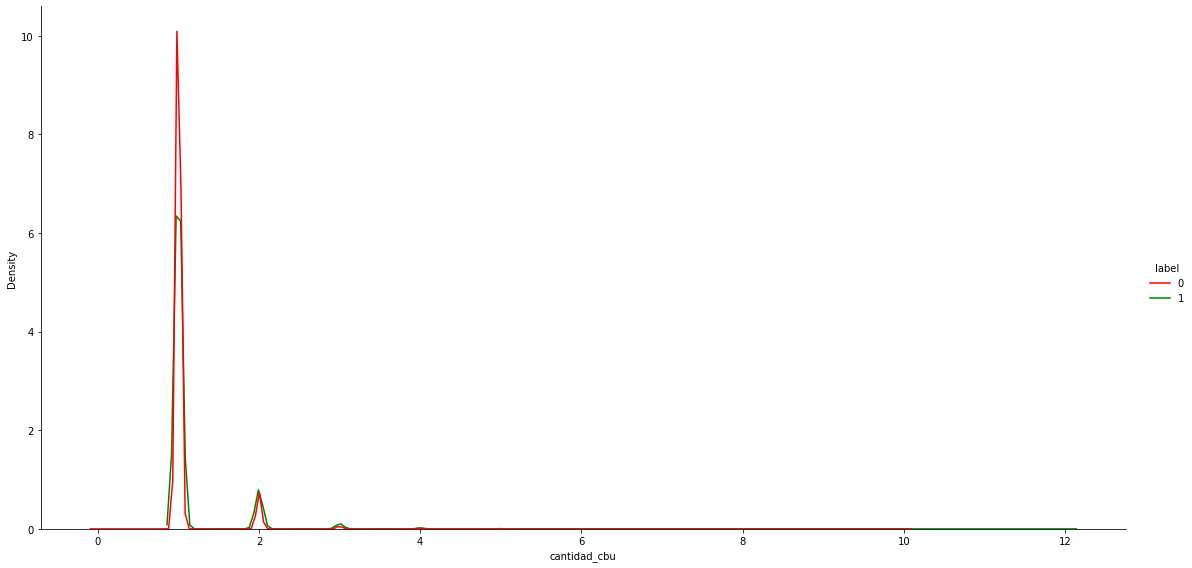

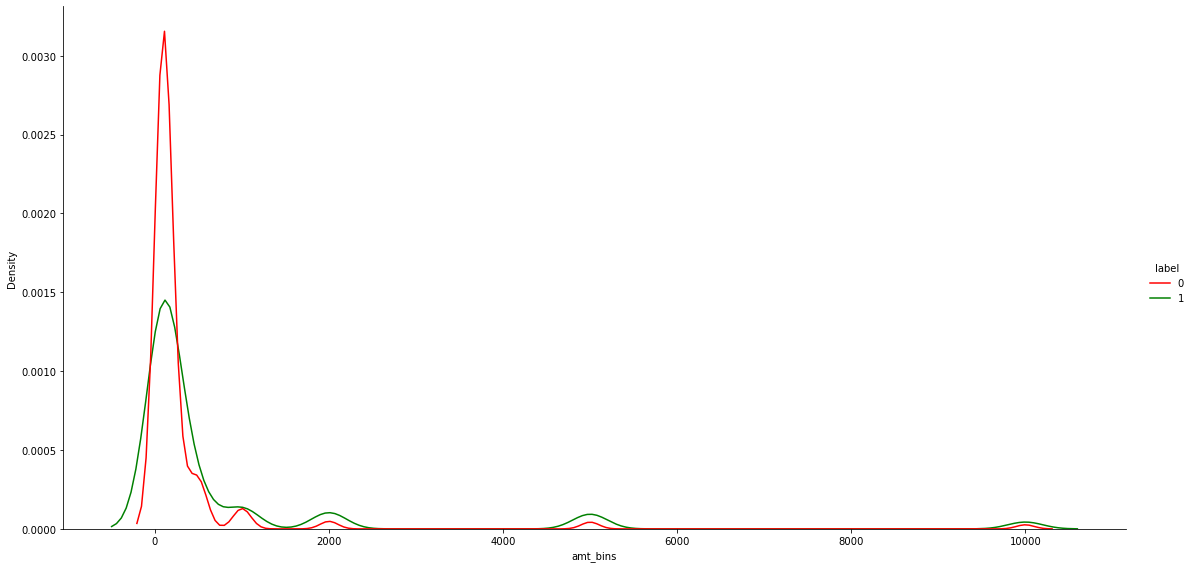

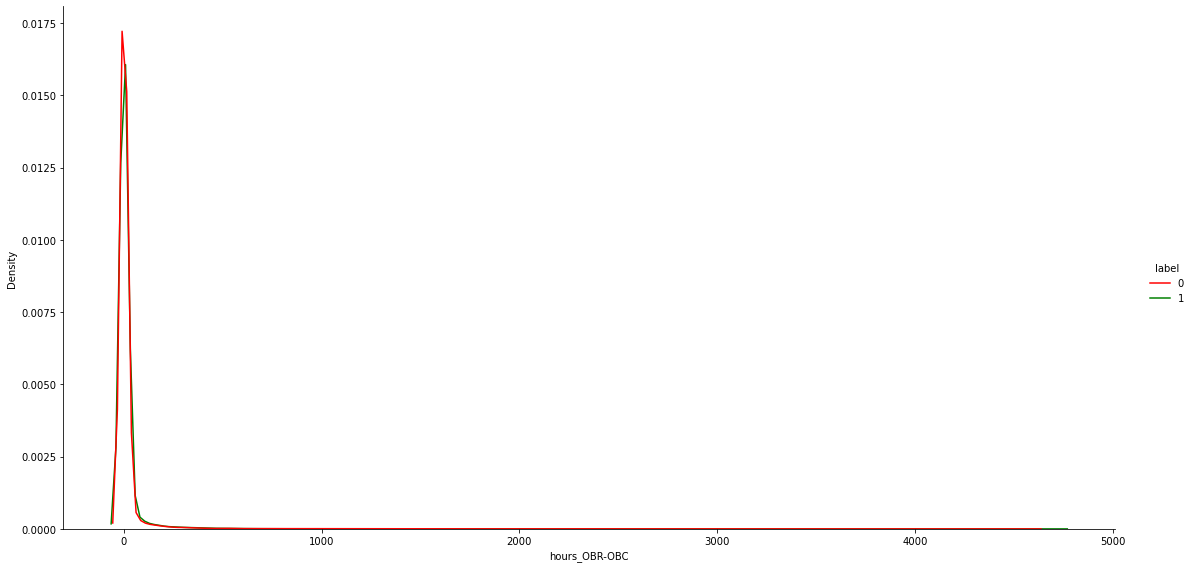

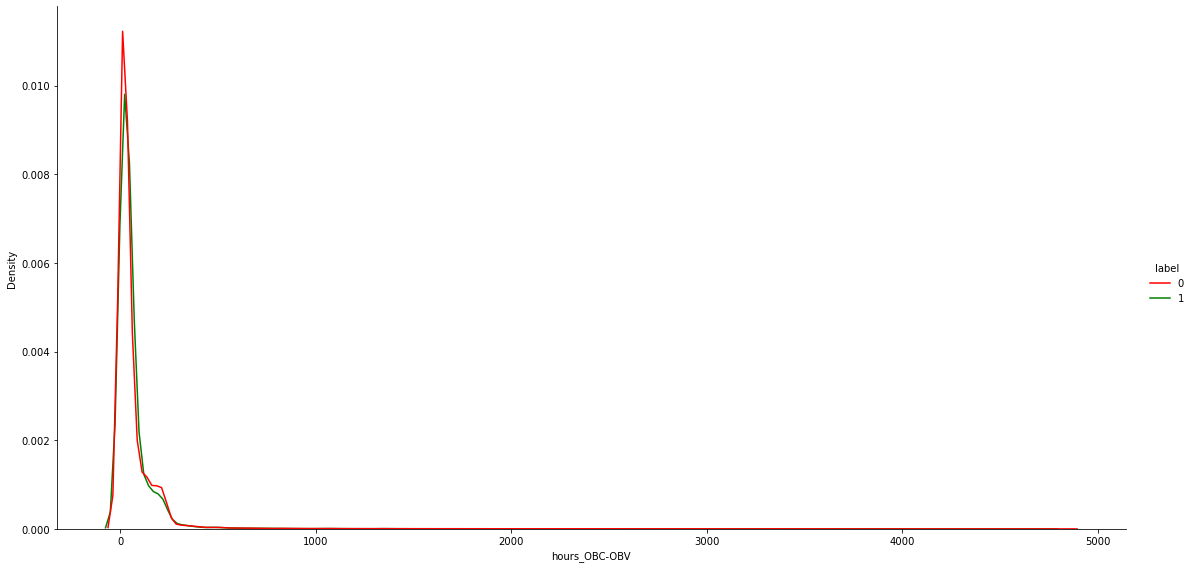

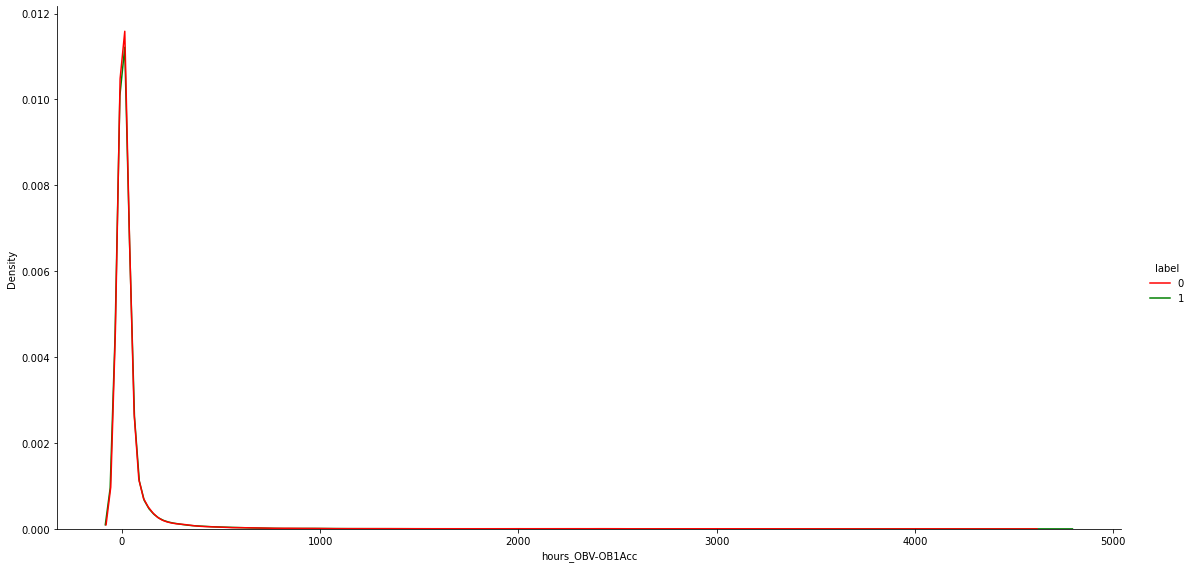

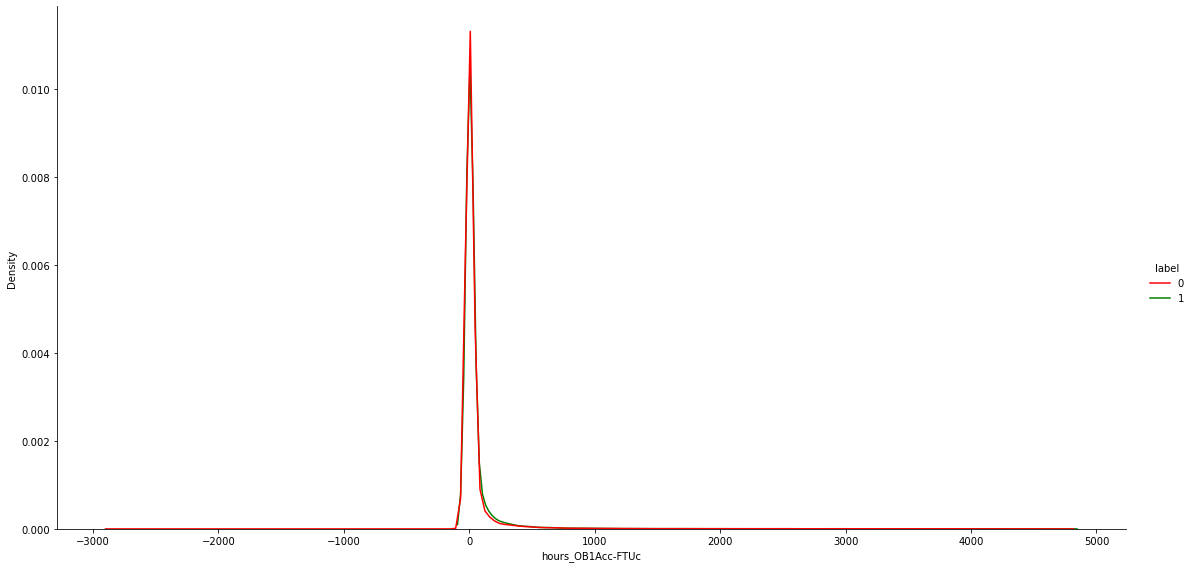

In [142]:
var_num = data.drop(columns=["ret_30d","label","transfer_between_own_accounts","limite_ampliado","actividad_principal"]).select_dtypes(exclude=["object","datetime64[ns, UTC]"]).columns
for i in var_num:
    sns.displot(data=data, x=i, kind='kde', hue="label", common_norm=False, palette=["red","green"], height=8, aspect=2)

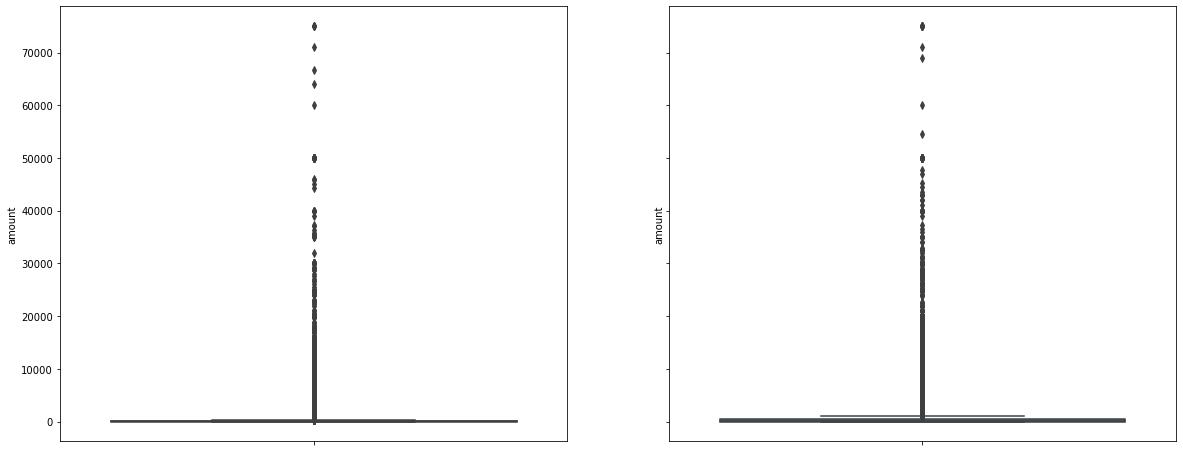

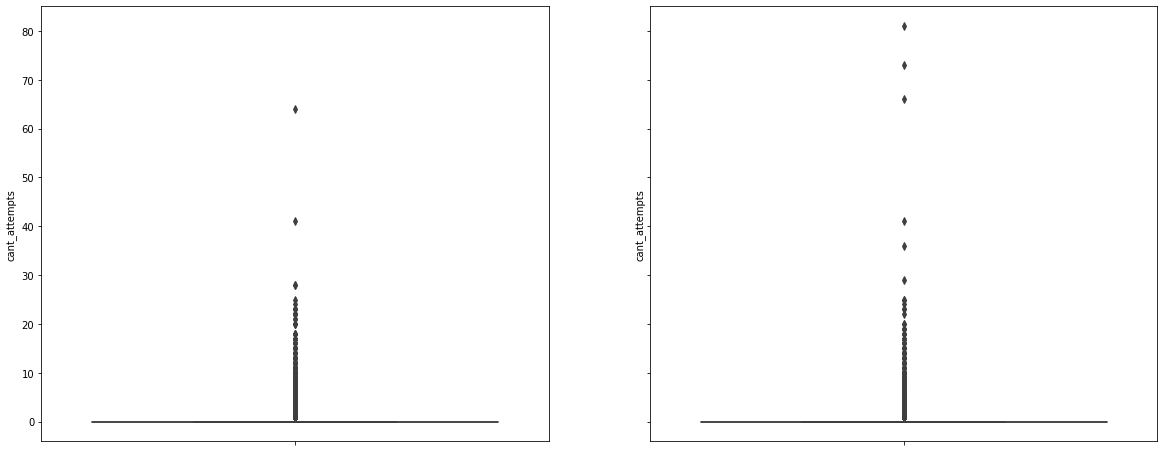

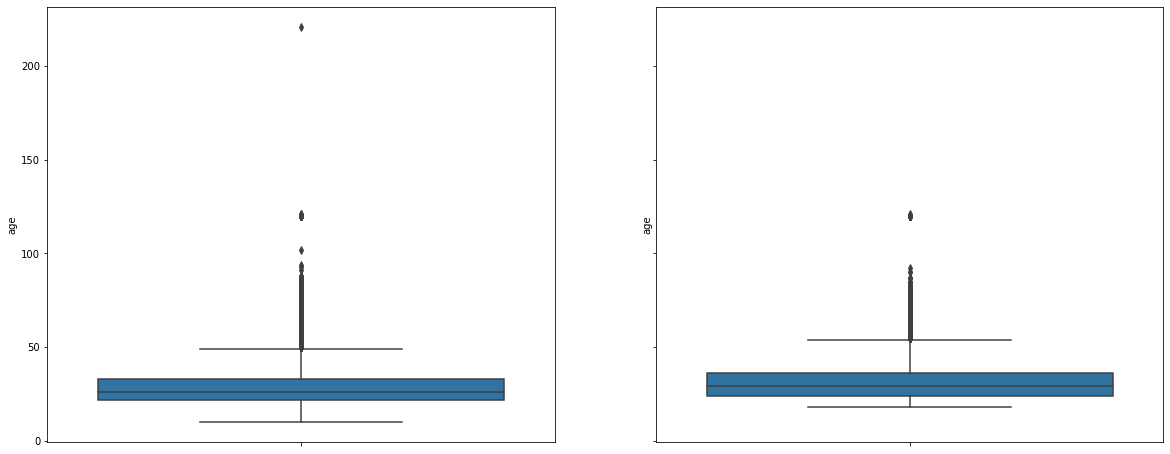

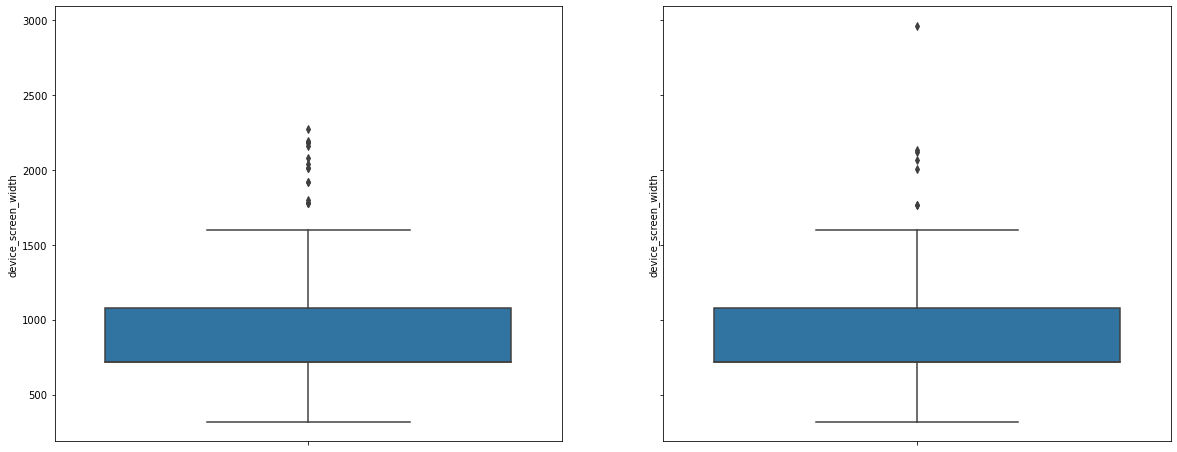

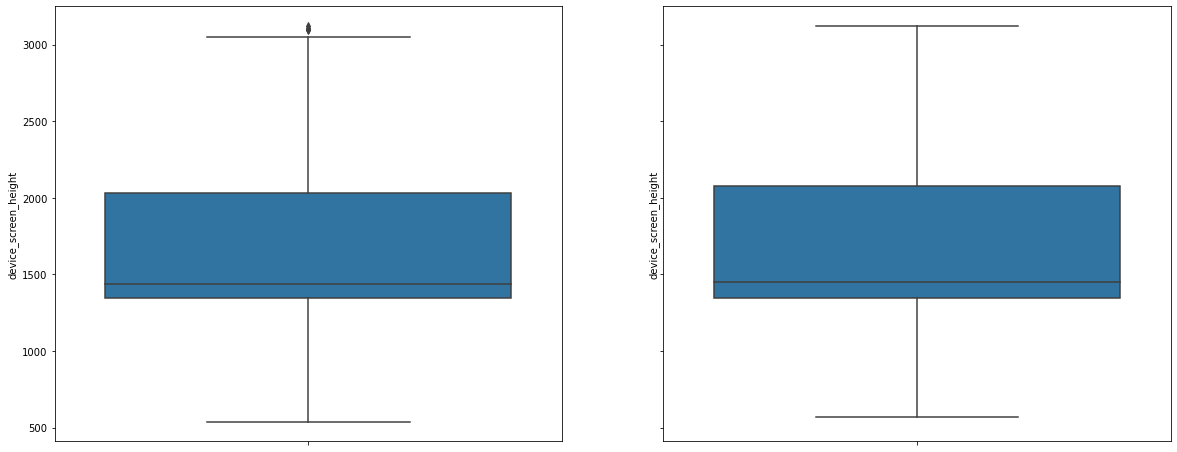

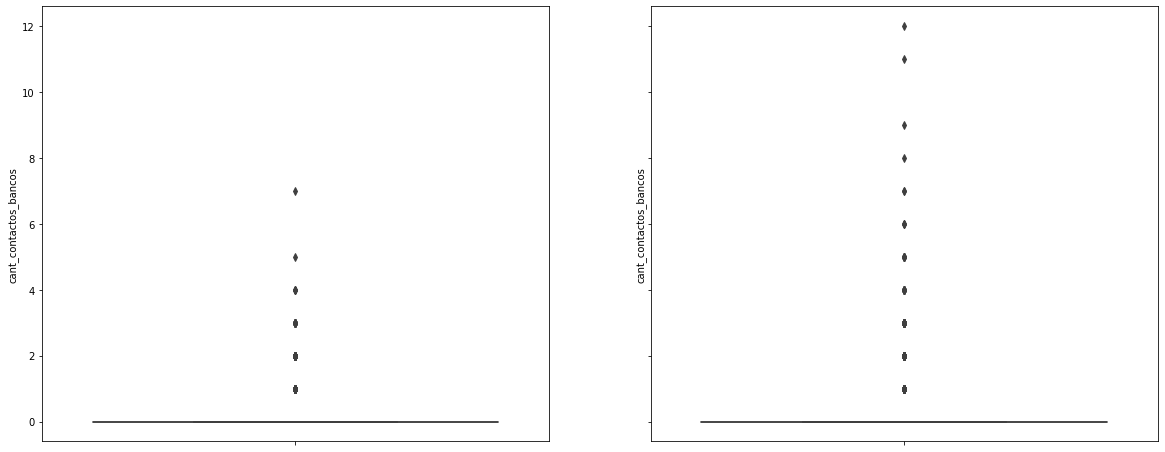

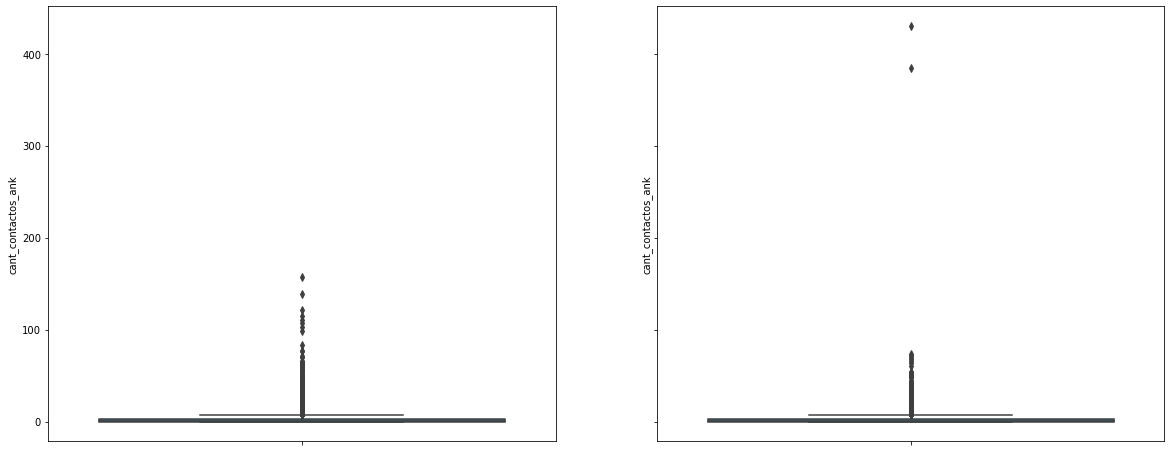

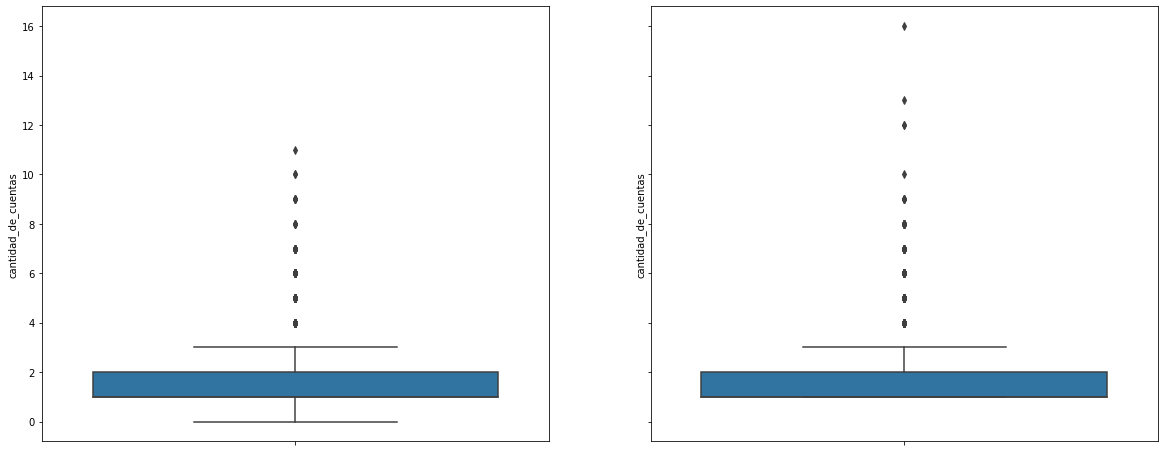

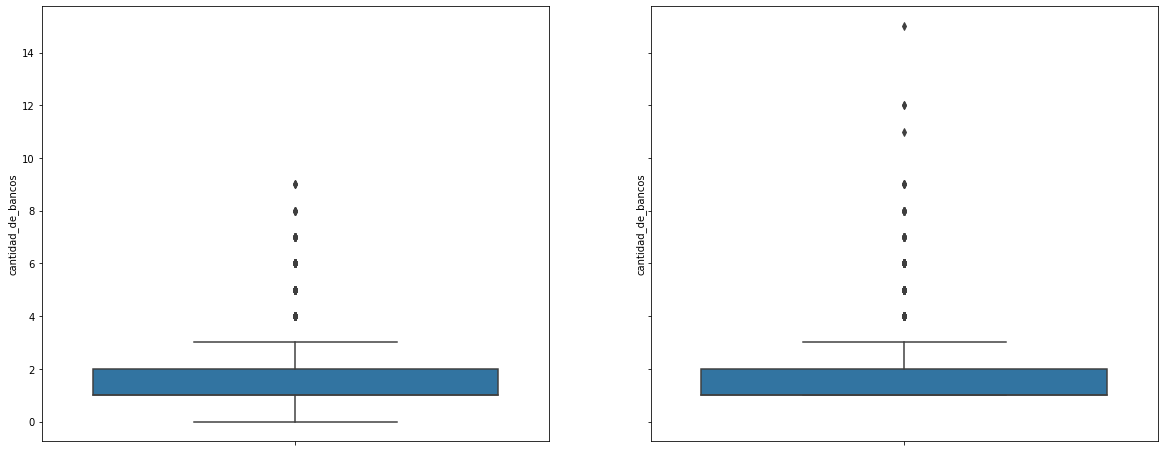

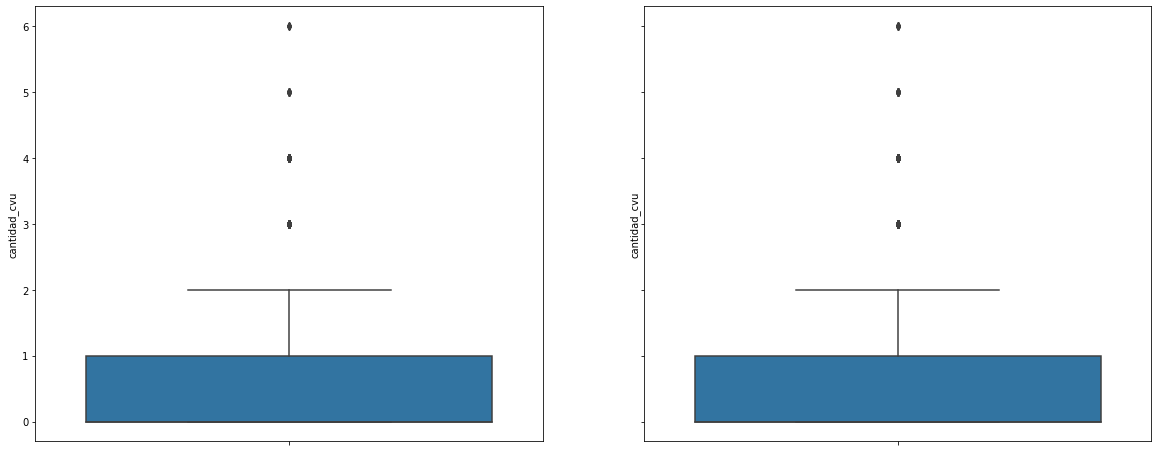

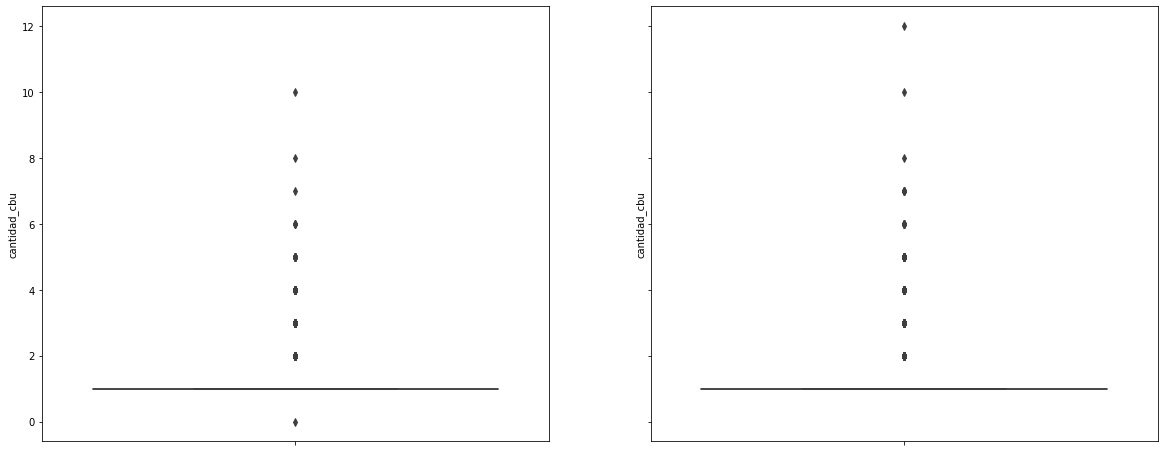

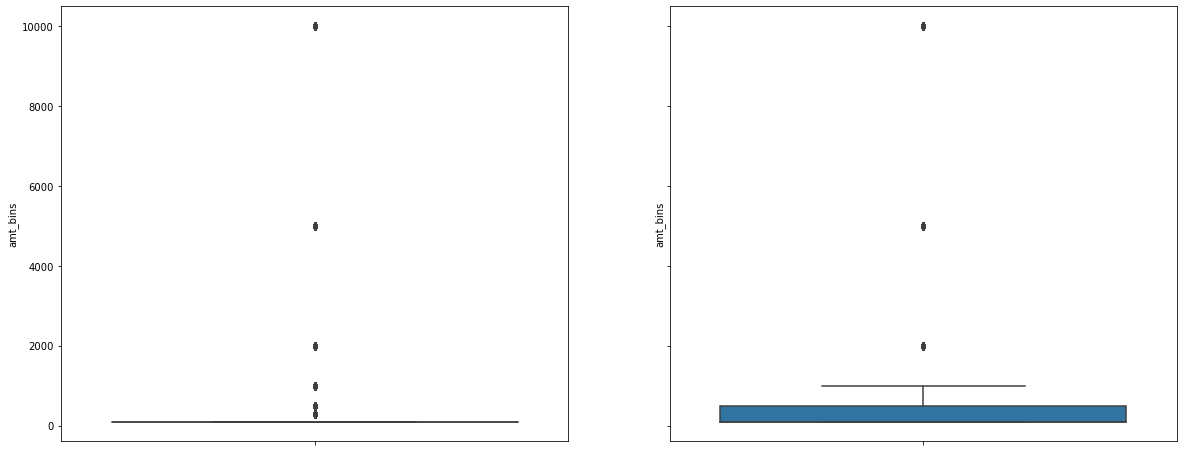

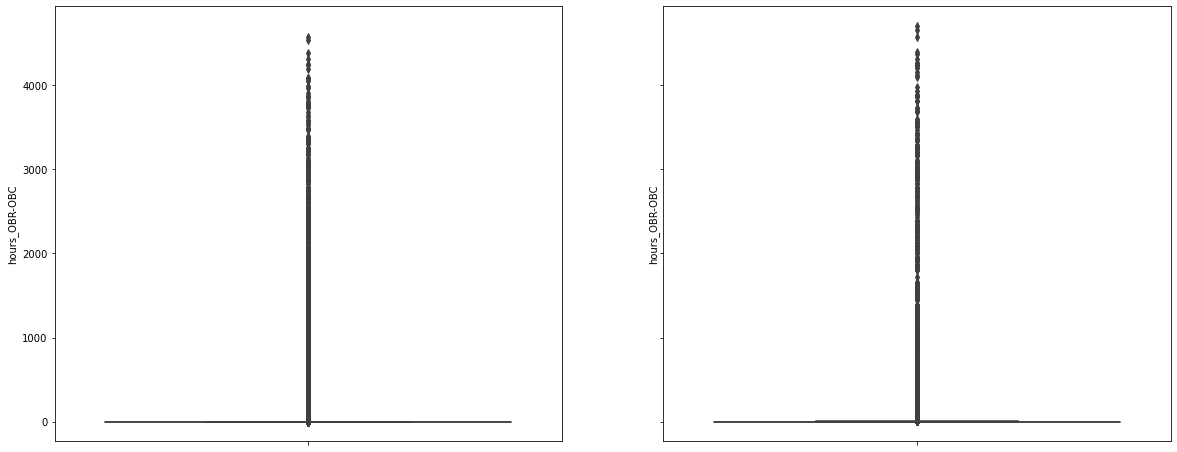

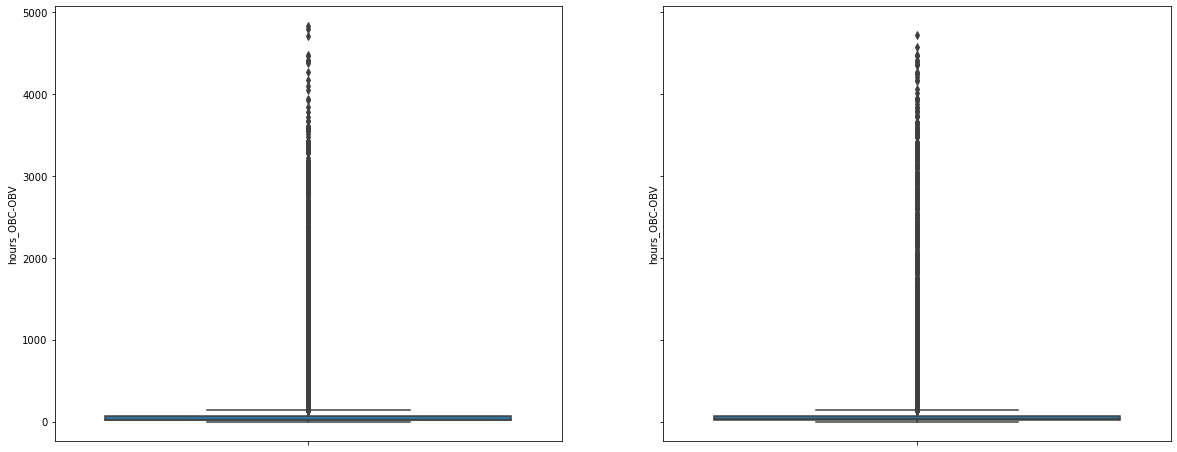

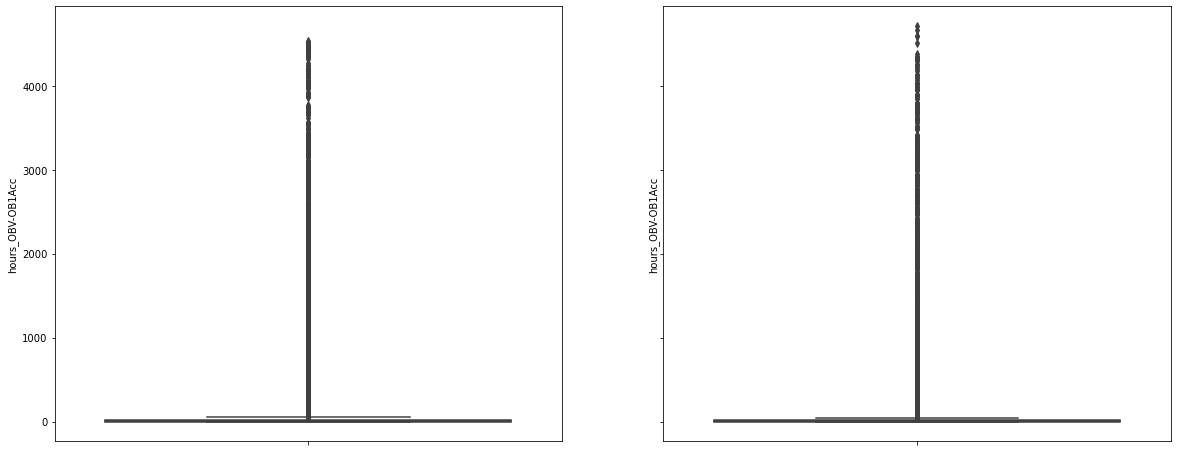

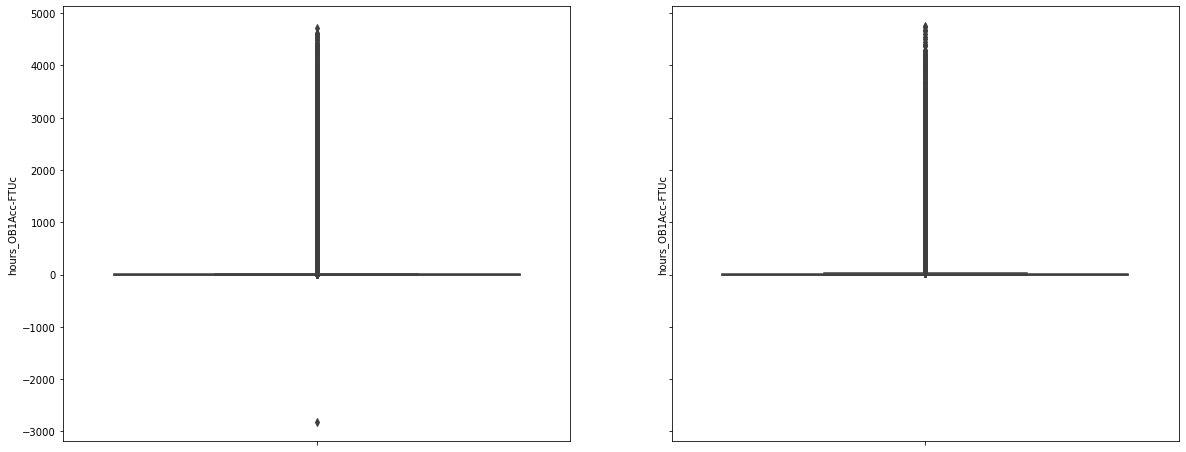

In [143]:
for i in var_num:
    plt.subplots(1,2, figsize=(20,8), sharey=True)
    plt.subplot(1,2,1)
    sns.boxplot(y=i, data=data.loc[data["label"]==0])
    plt.subplot(1,2,2)
    sns.boxplot(y=i, data=data.loc[data["label"]==1])
    plt.show()

In [144]:
#sns.pairplot(data.drop("ret_30d",axis=1), hue="label")

#### Datetime variables

In [145]:
var_fecha = data.select_dtypes(include="datetime64[ns, UTC]").columns
def split_datetime_in_variables(data,variables):
    dataaux = data.copy()
    for i in variables:
        dataaux[i+'_year'] = dataaux[i].dt.year
        dataaux[i+'_month'] = dataaux[i].dt.month
        dataaux[i+'_day'] = dataaux[i].dt.day
        dataaux[i+'_hour'] = dataaux[i].dt.hour
        dataaux[i+'_dayname'] = dataaux[i].dt.strftime("%w")
        dataaux[i+'_dayname'] = dataaux[i+'_dayname'].values.astype('float64')
    return dataaux

In [146]:
data_with_date_variables = split_datetime_in_variables(data,var_fecha)

In [147]:
len(data_with_date_variables.columns)

75

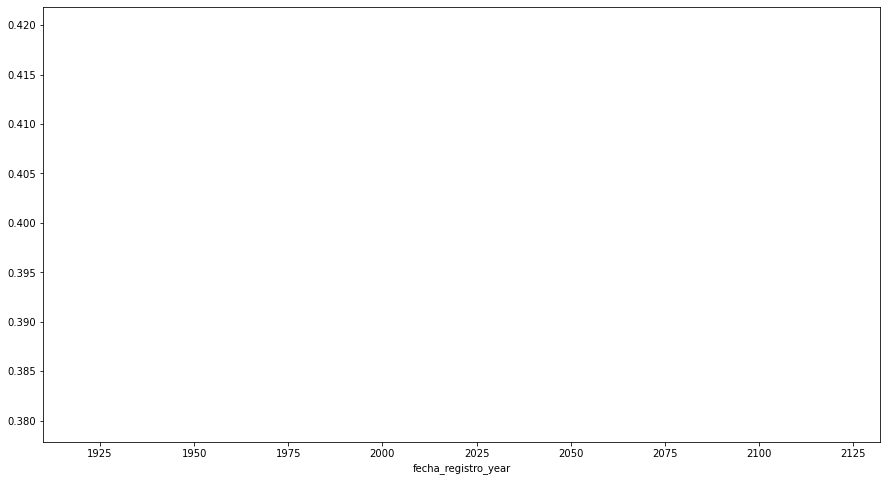

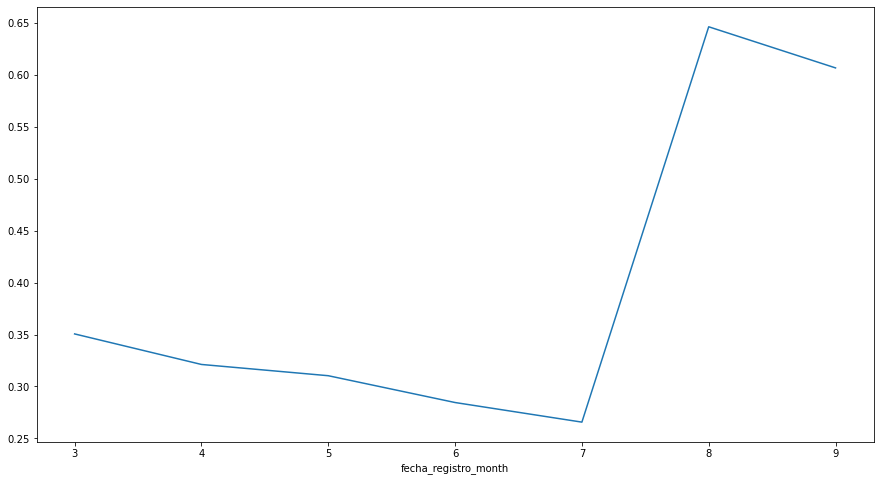

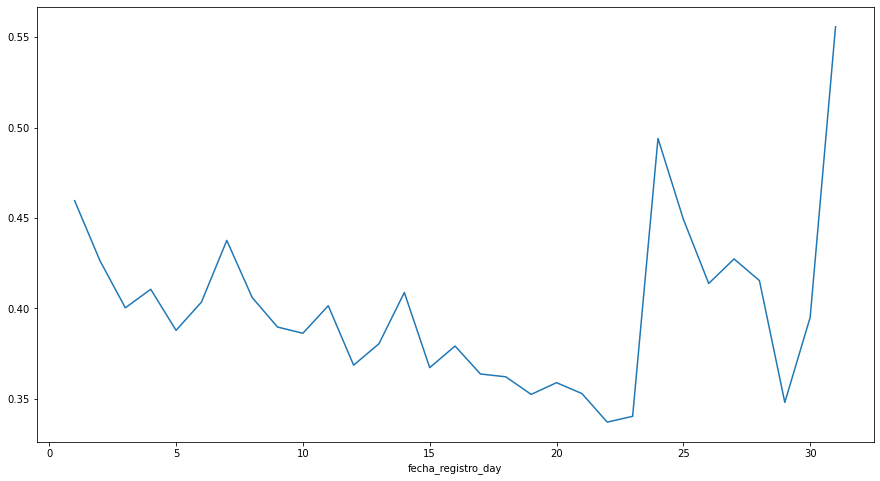

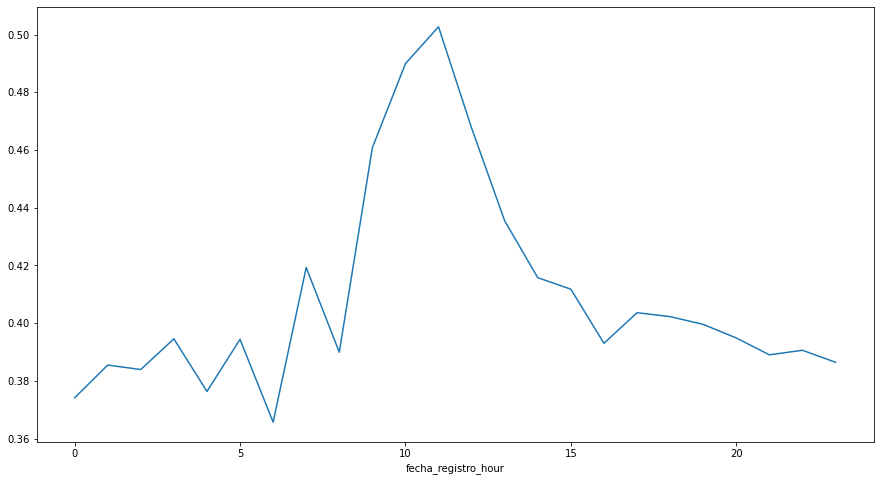

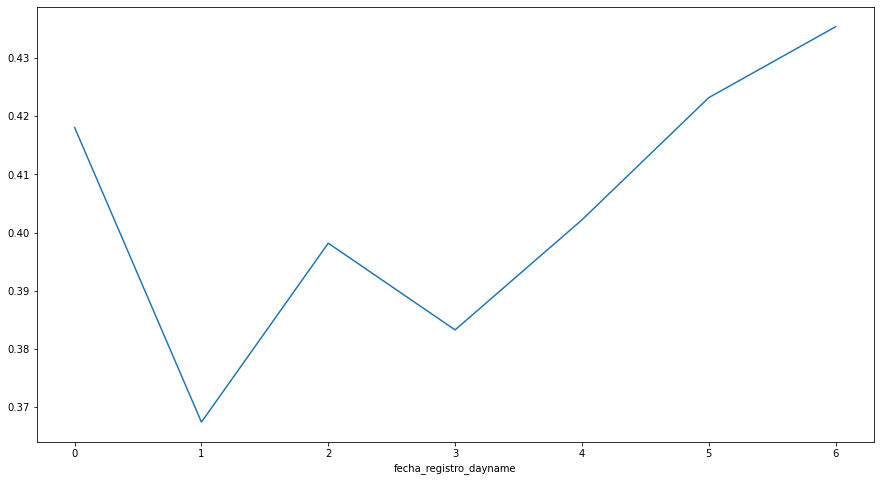

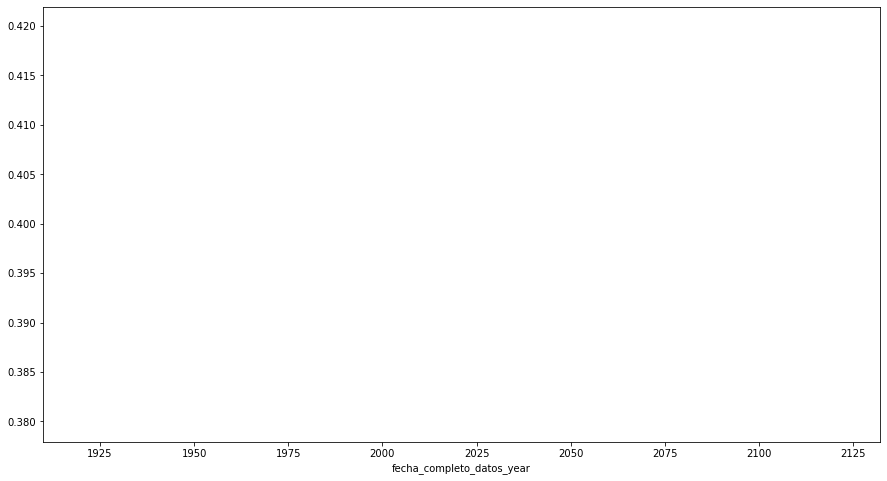

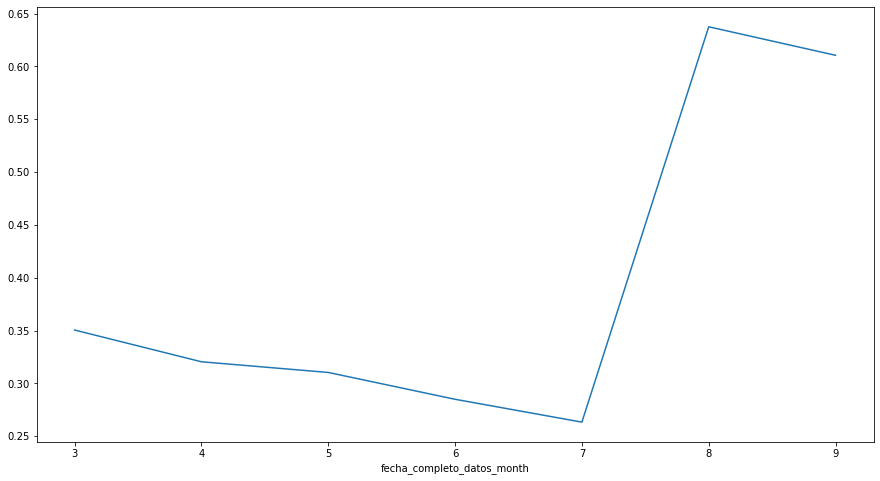

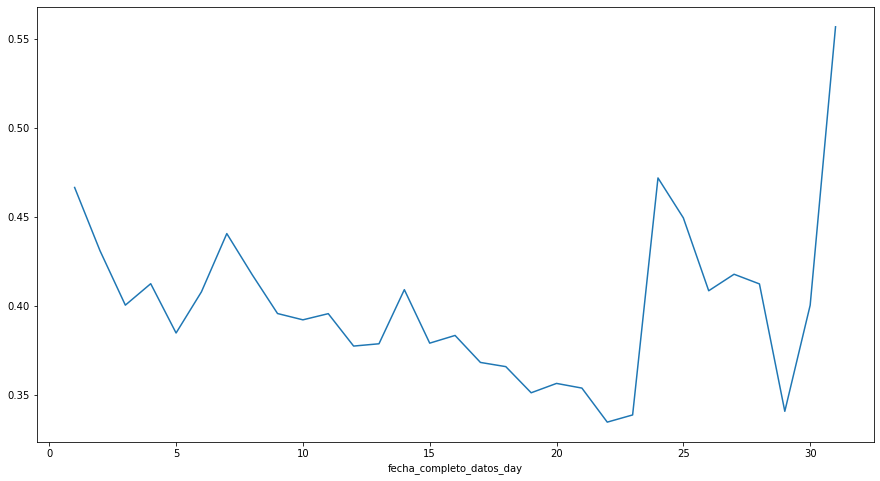

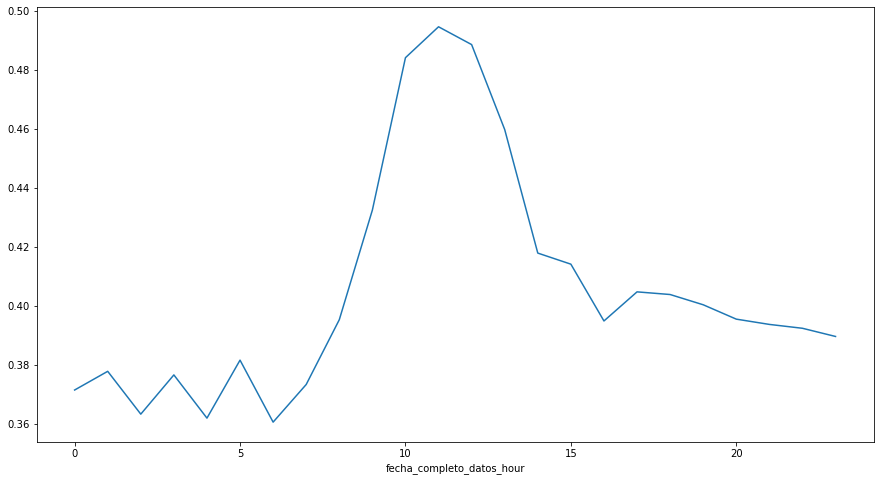

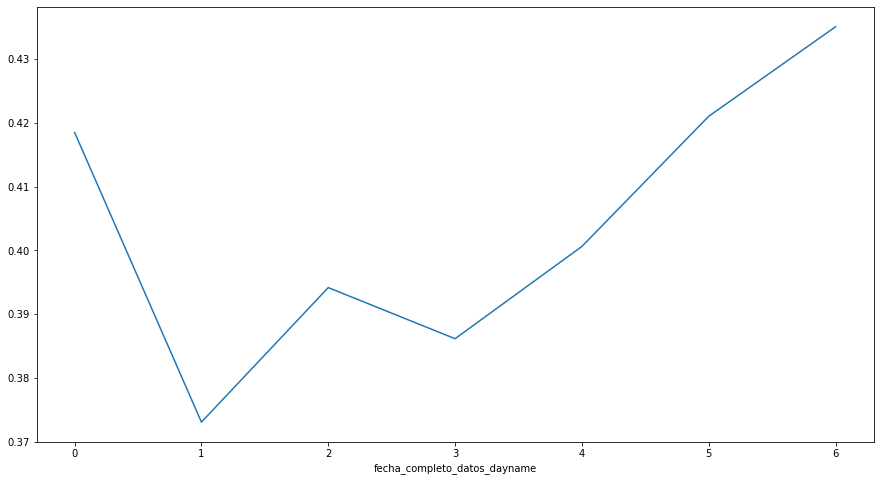

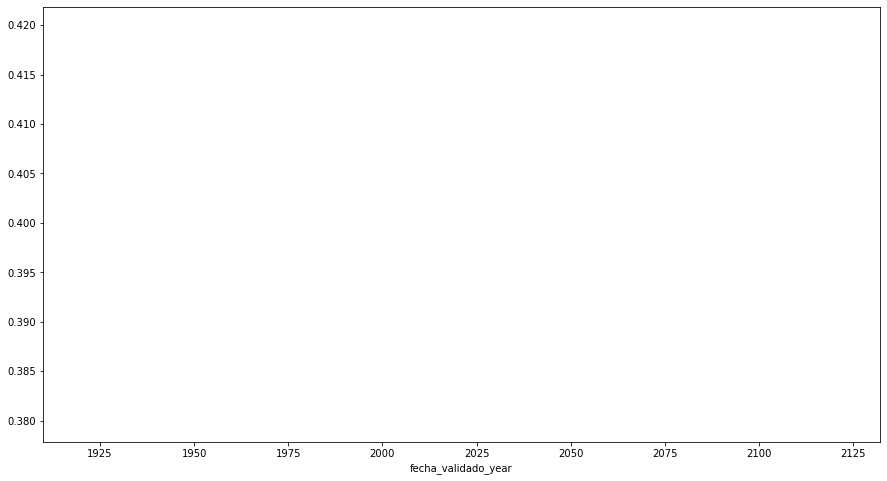

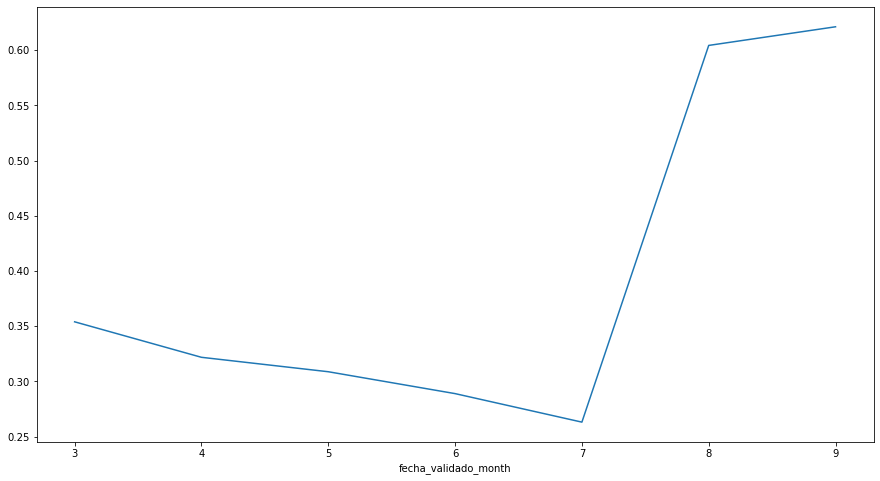

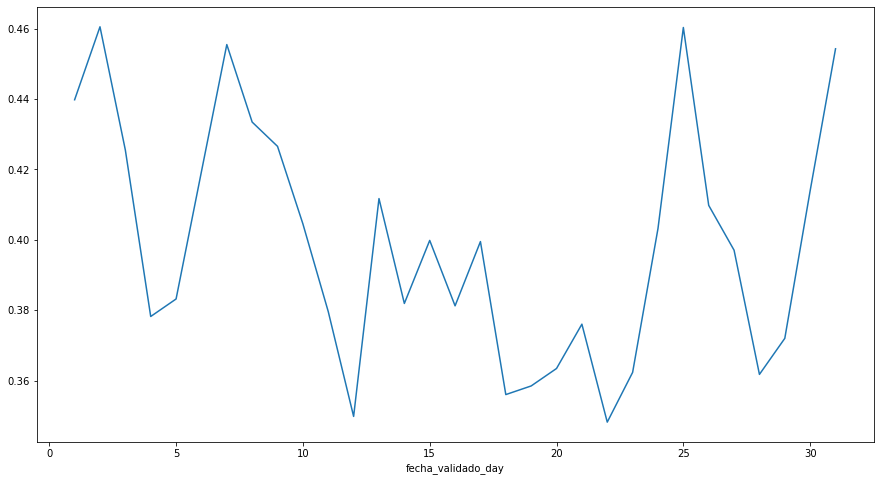

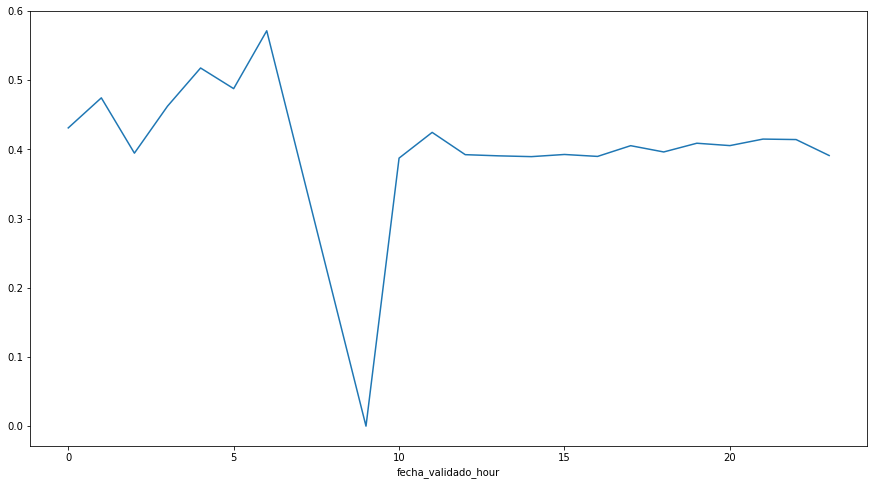

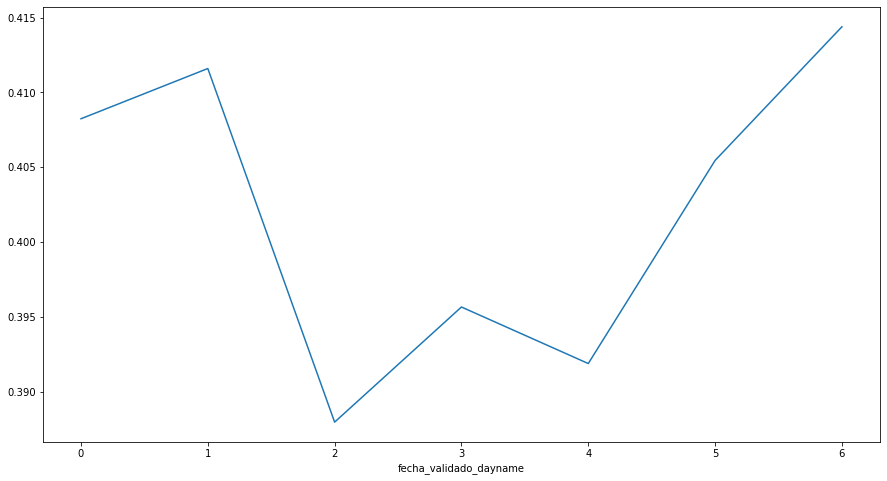

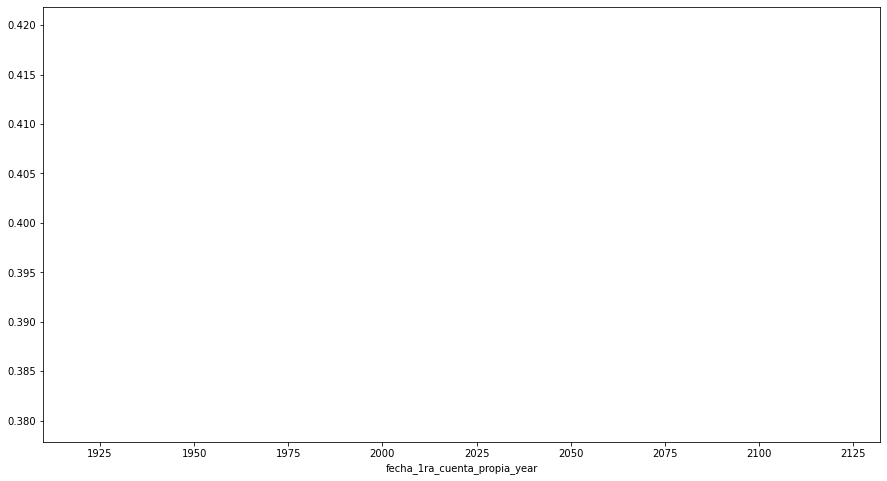

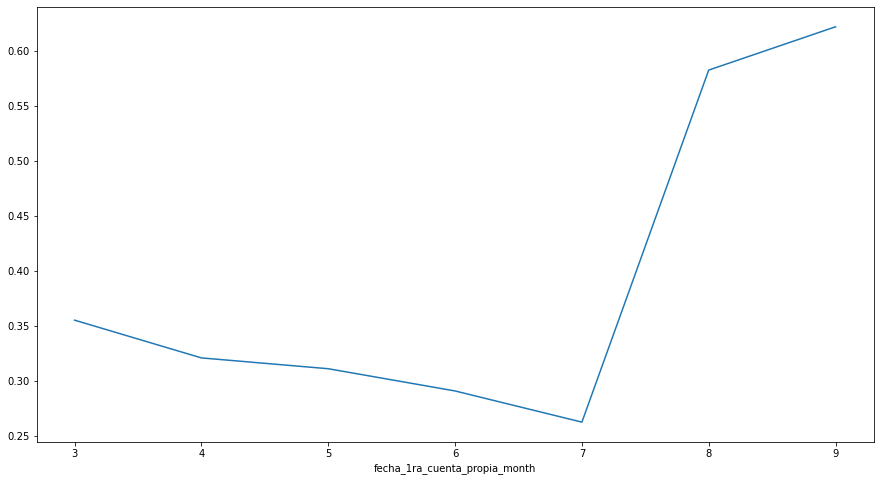

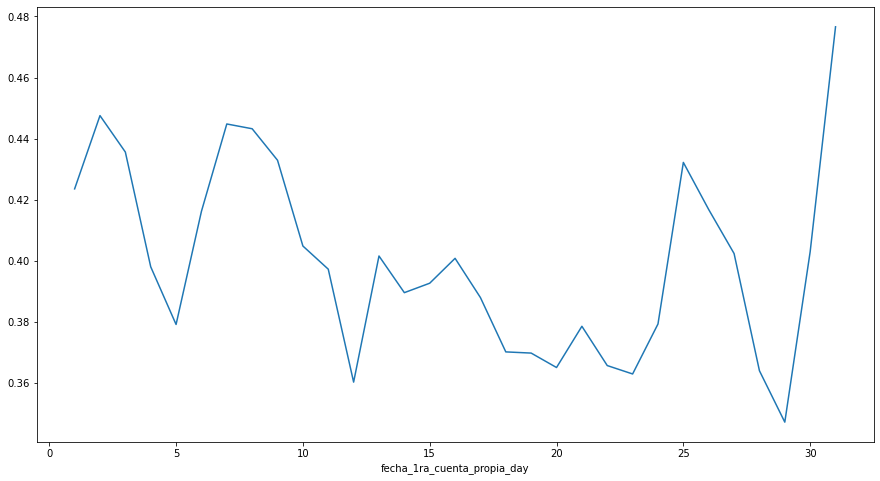

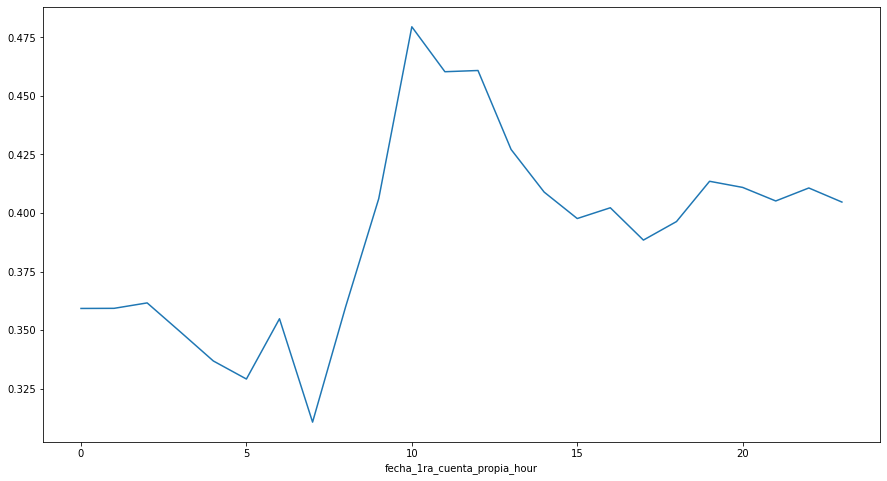

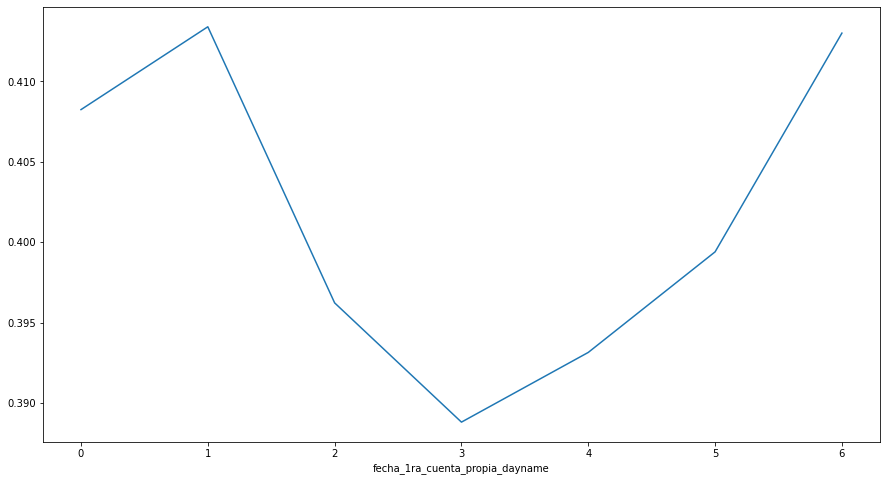

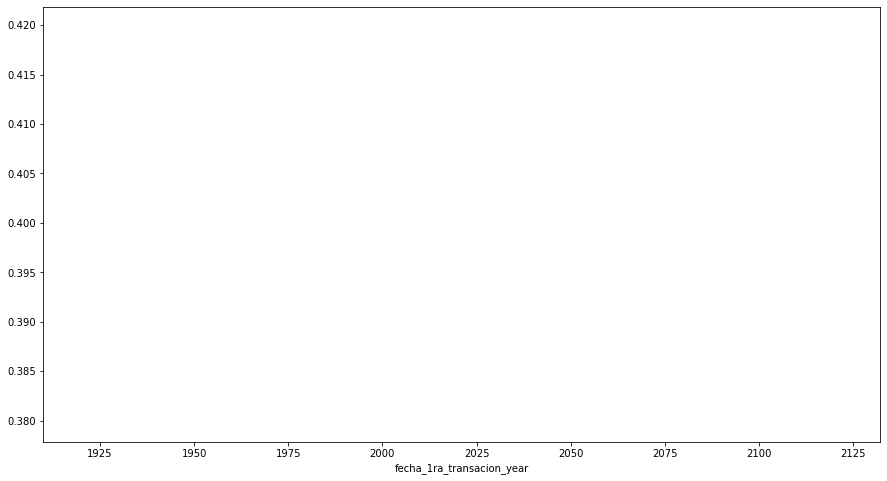

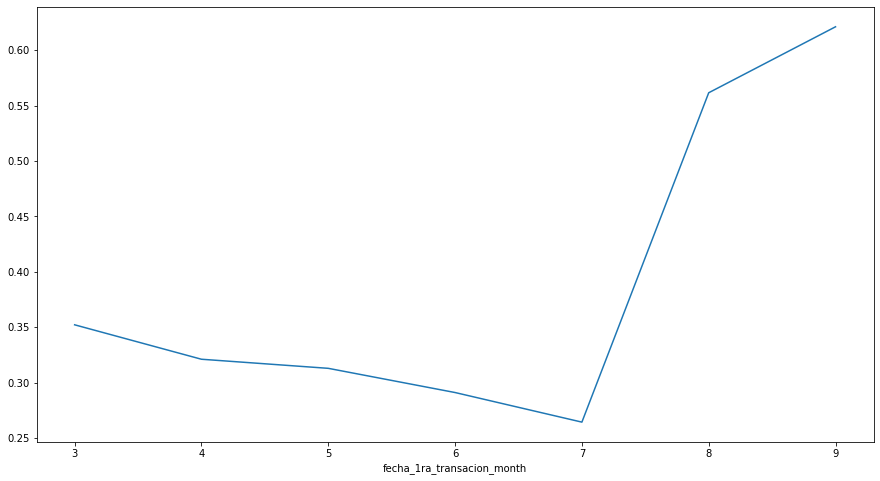

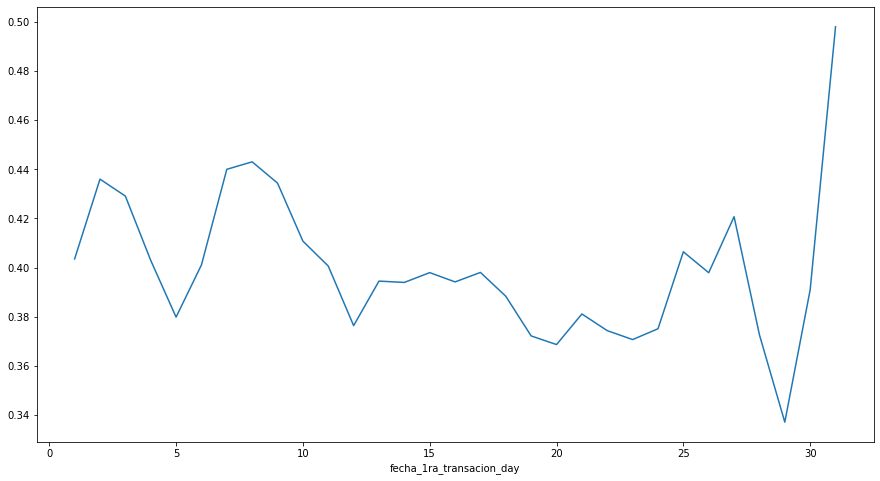

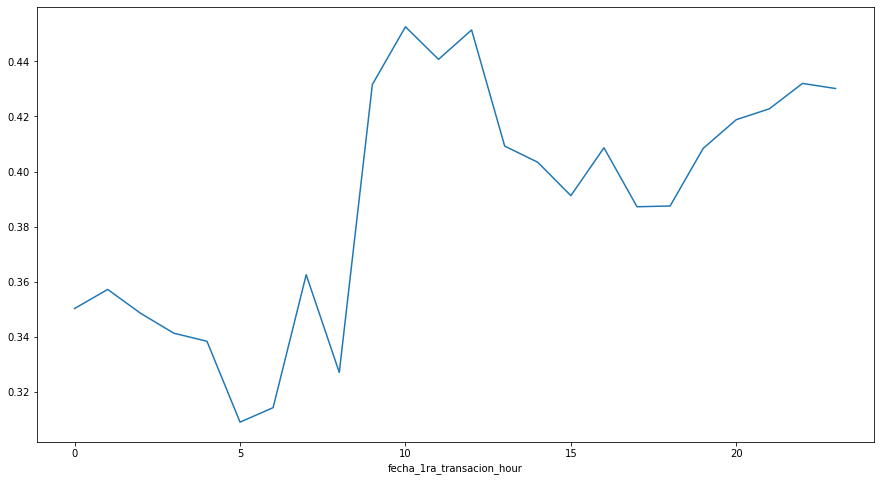

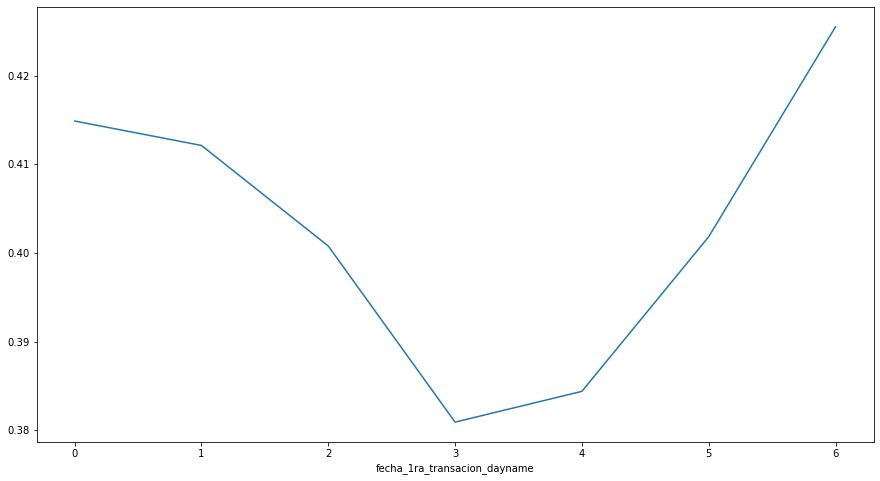

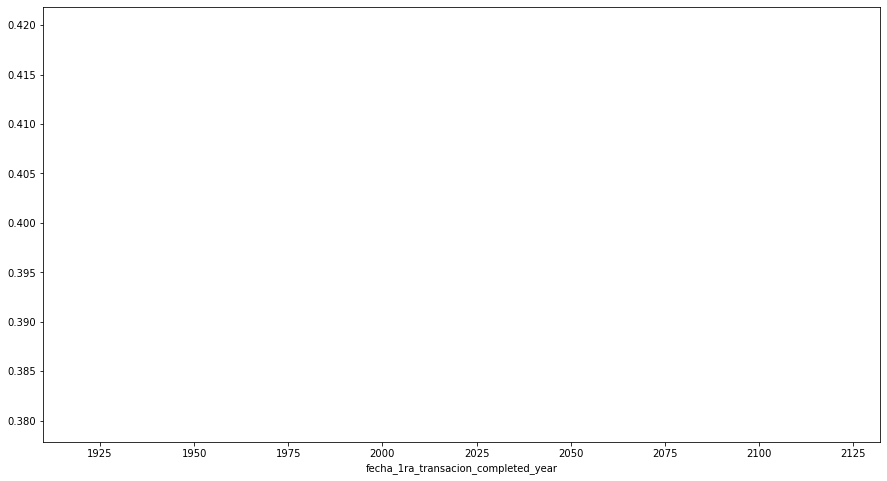

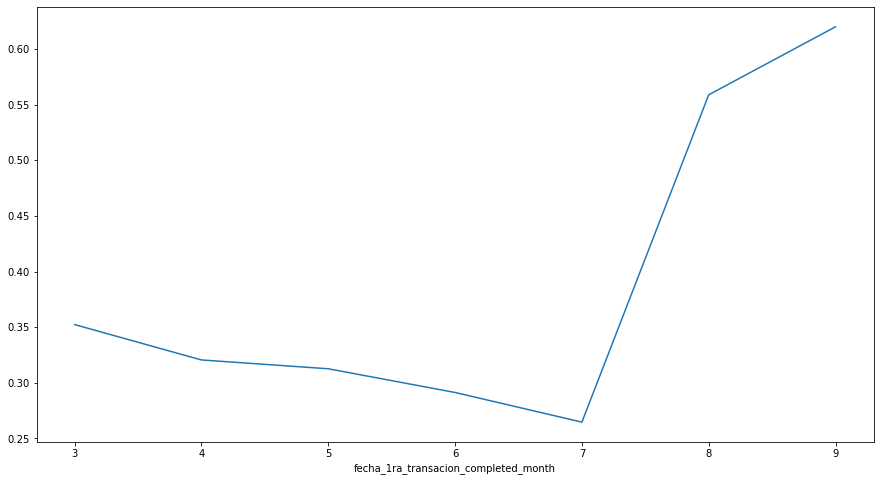

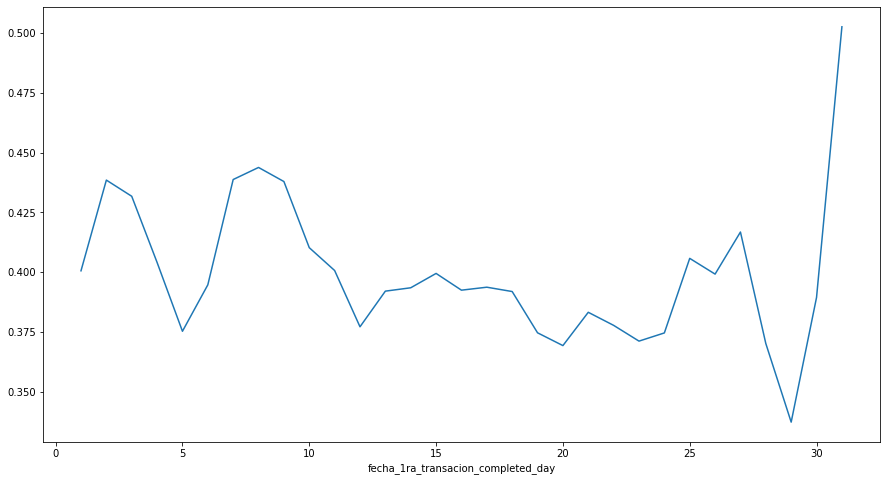

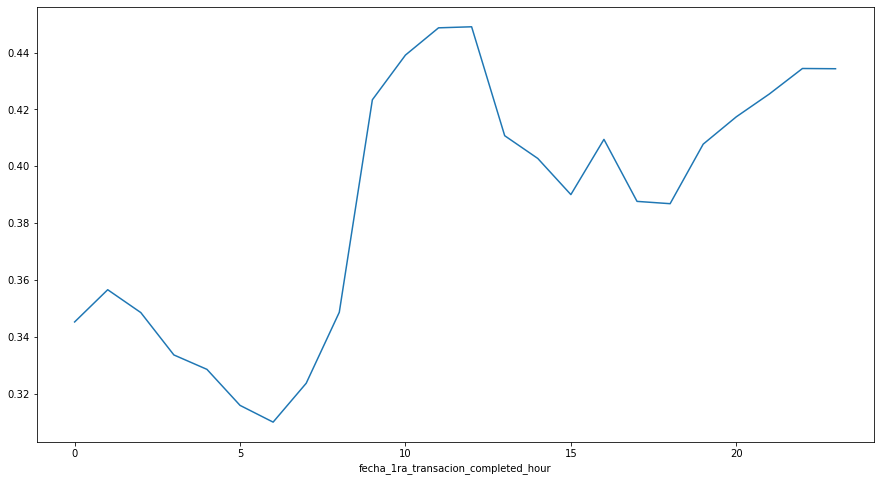

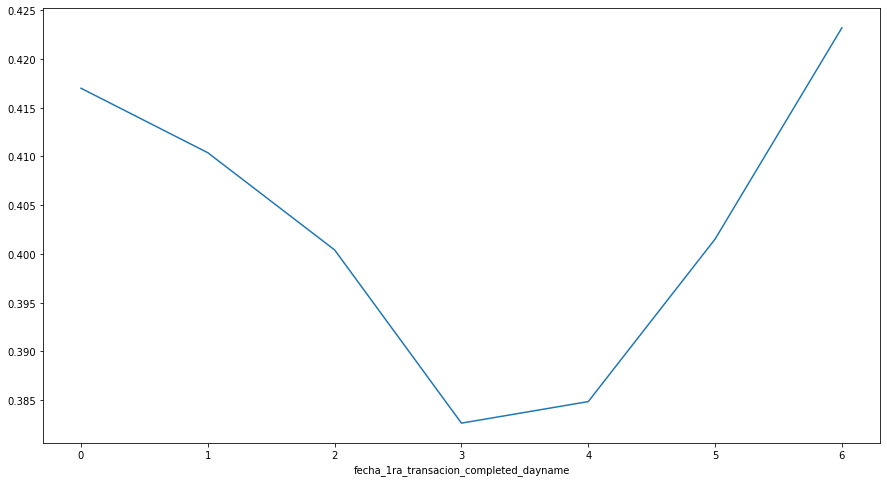

In [148]:
for i in range(45,len(data_with_date_variables.columns),1):
    col = data_with_date_variables.columns[i]
    plt.subplots(figsize=(15,8))
    data_with_date_variables.groupby(by=col).mean()["label"].plot()
    plt.show()

In [149]:
# Función para comparar distribuciones de variables categóricas
def compare_dists_dates(data,col,label):
    data0 = pd.DataFrame(data.loc[data[label]==0,col].value_counts(normalize=True, sort=False))
    data1 = pd.DataFrame(data.loc[data[label]==1,col].value_counts(normalize=True, sort=False))
    data_x = data0.merge(data1,how="outer", left_index=True, right_index=True, suffixes=('_0','_1'))
    data_x.head()
    data_x = data_x.sort_index()
    col0 = data_x.columns[0]
    col1 = data_x.columns[1]
    plt.subplots(figsize=(15,8))
    plt.title(col)
    data_x[col0].plot(kind='bar',label="not retained", color="red", alpha=0.3)
    data_x[col1].plot(kind='bar',label="retained M1", color="green", alpha=0.3)
    plt.legend()
    plt.show()

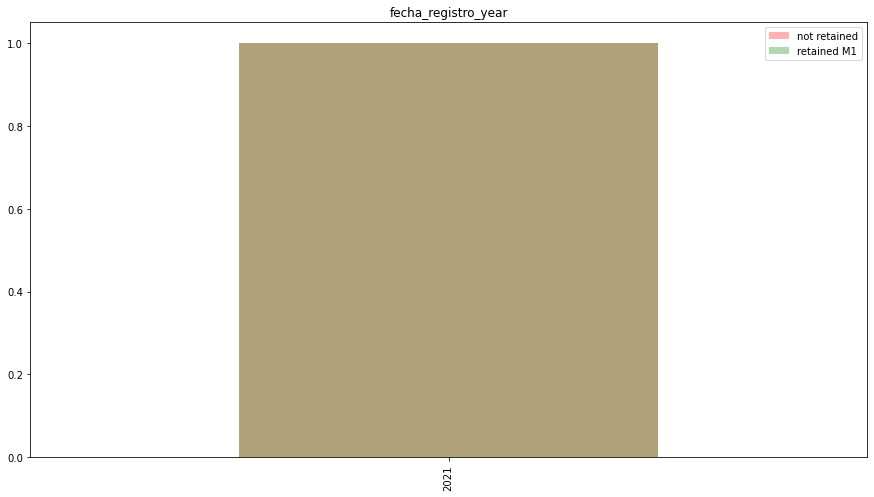

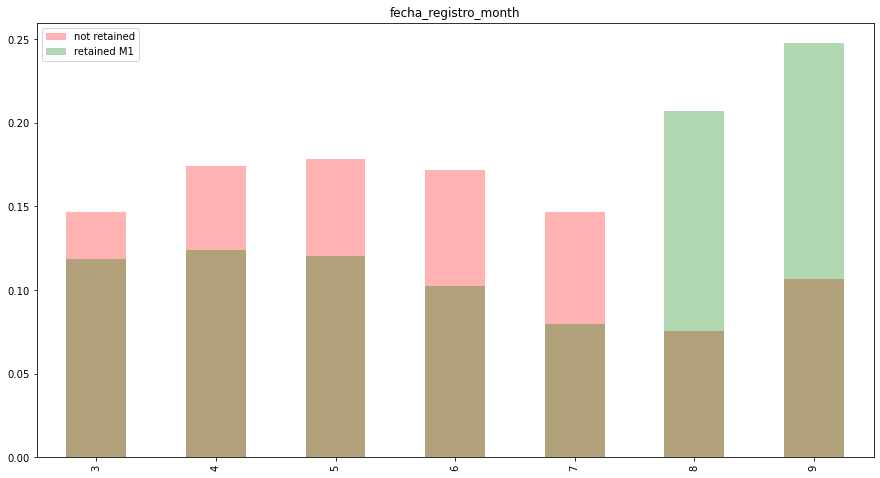

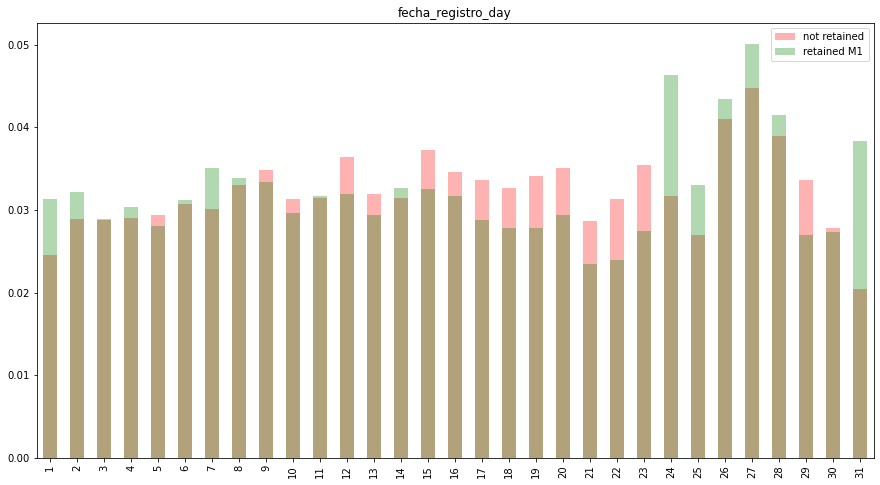

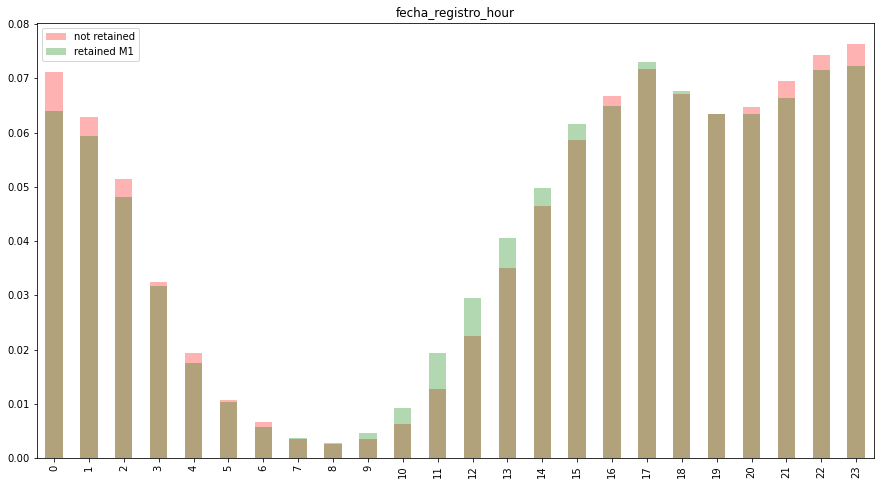

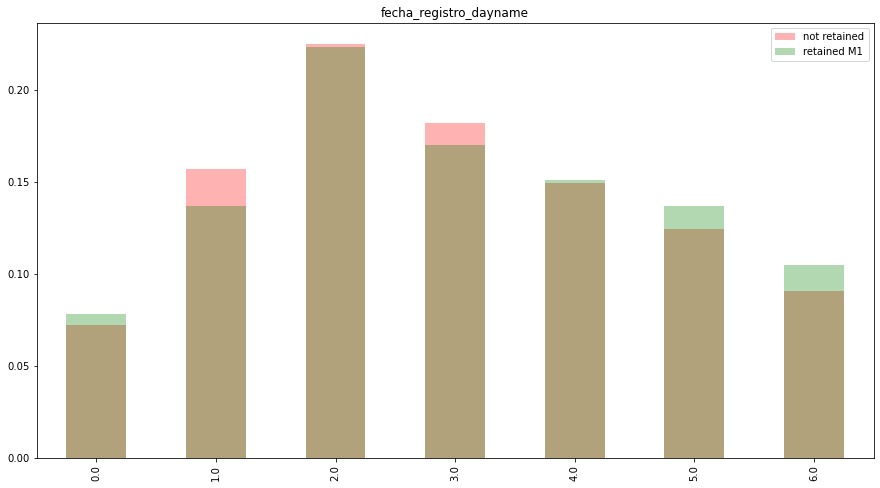

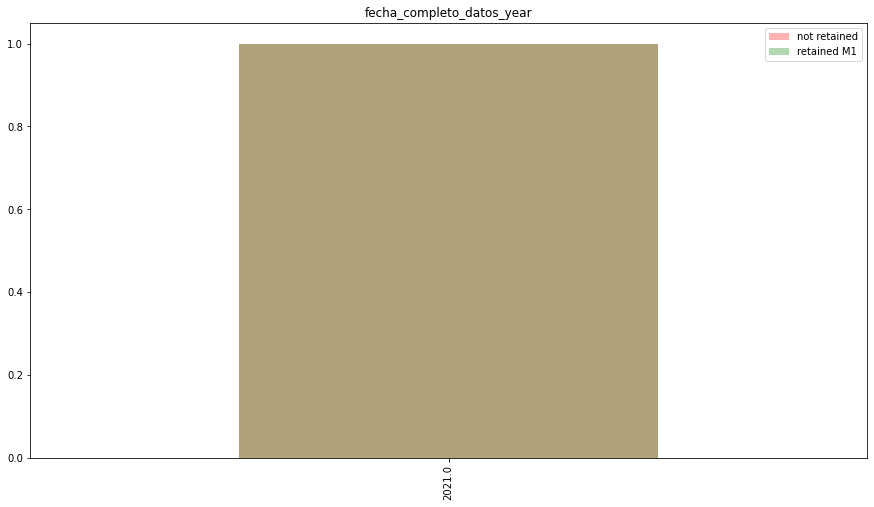

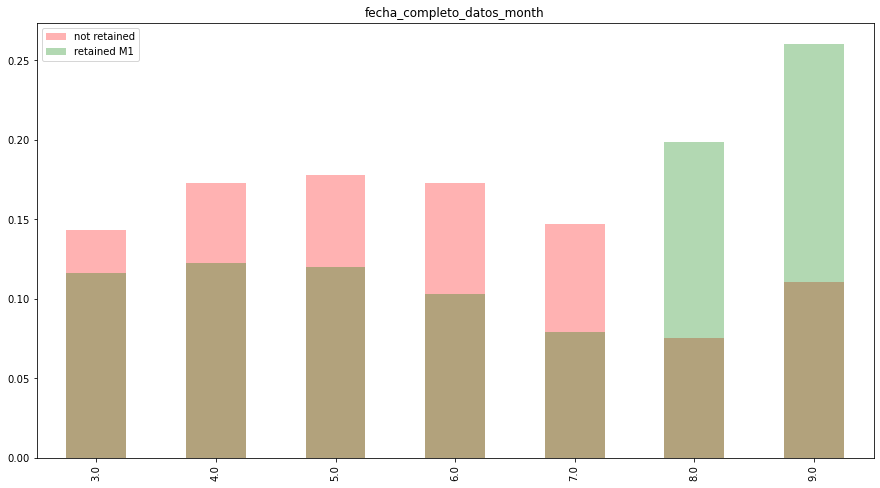

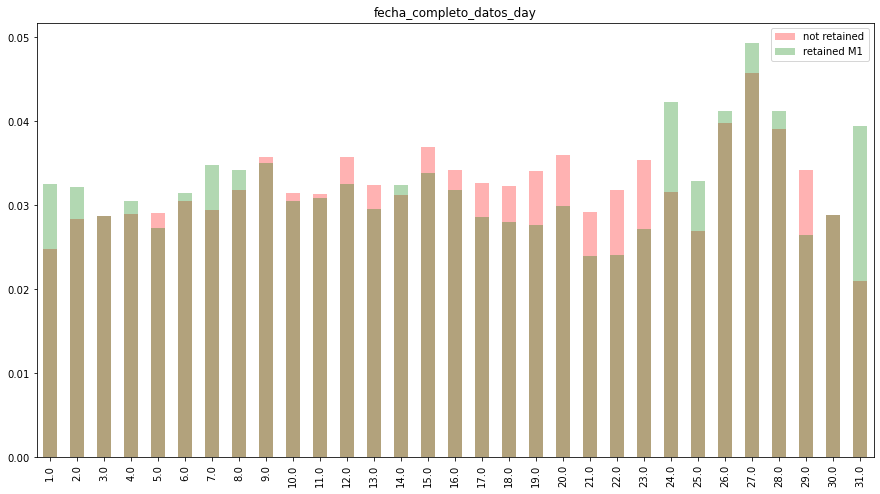

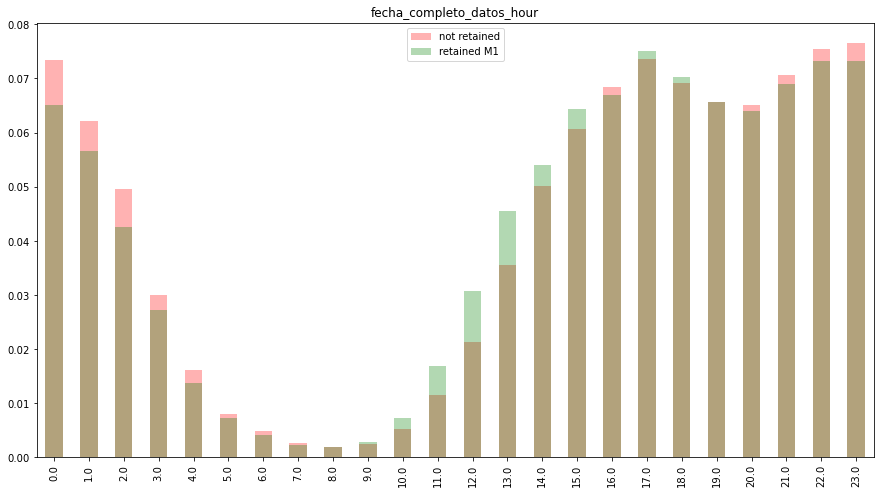

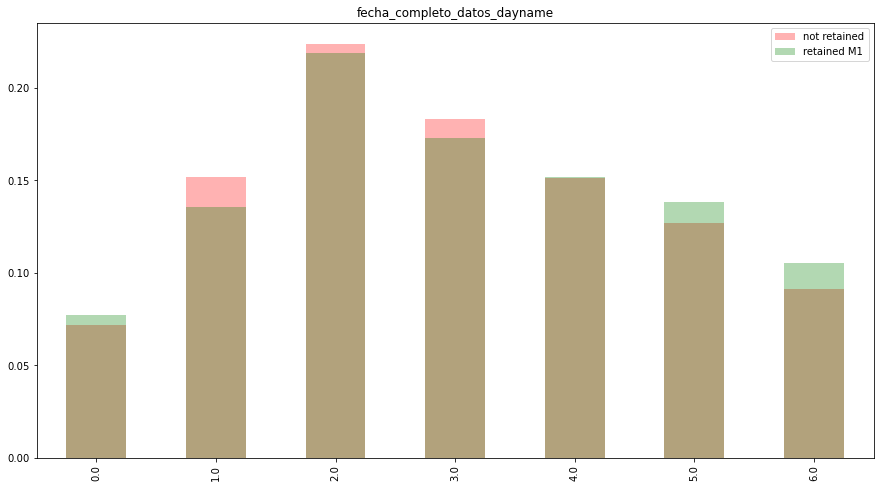

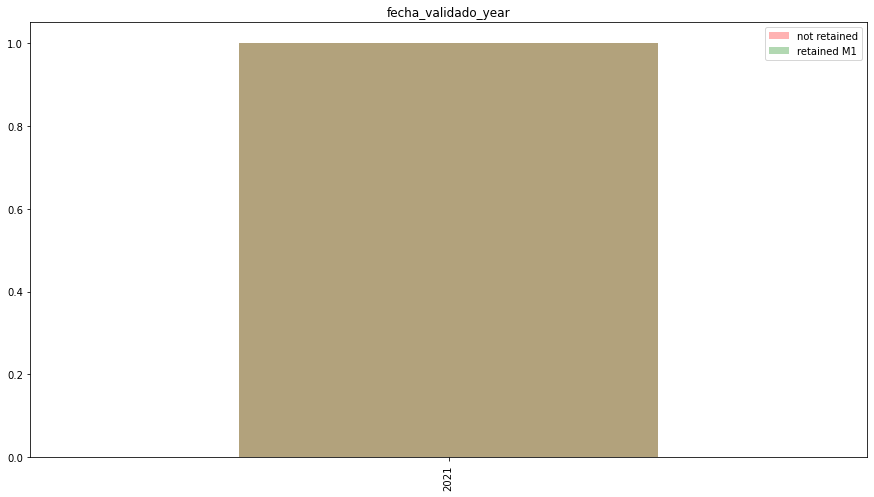

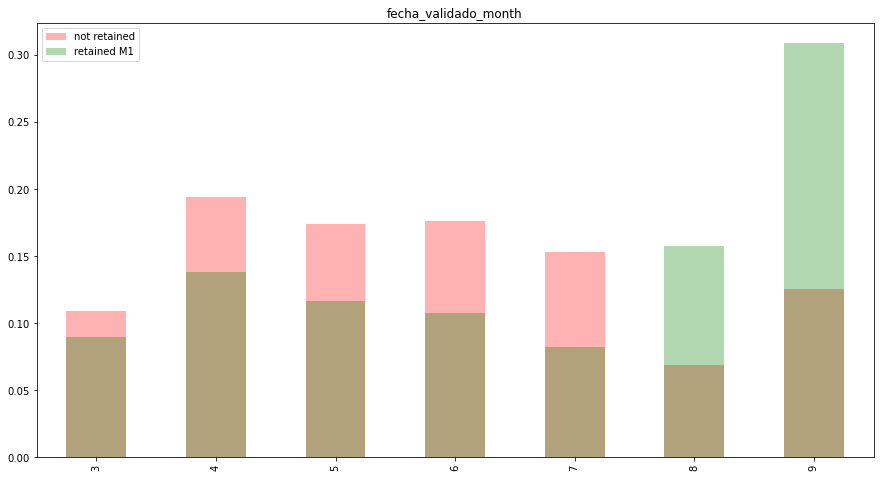

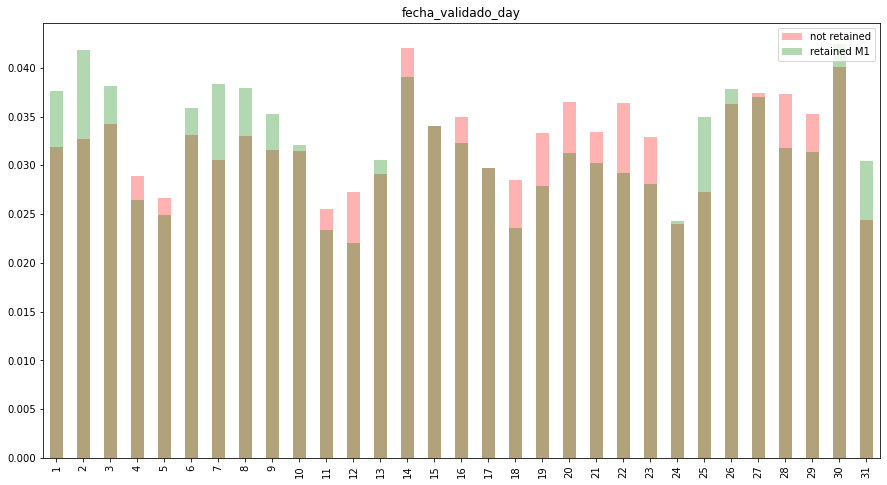

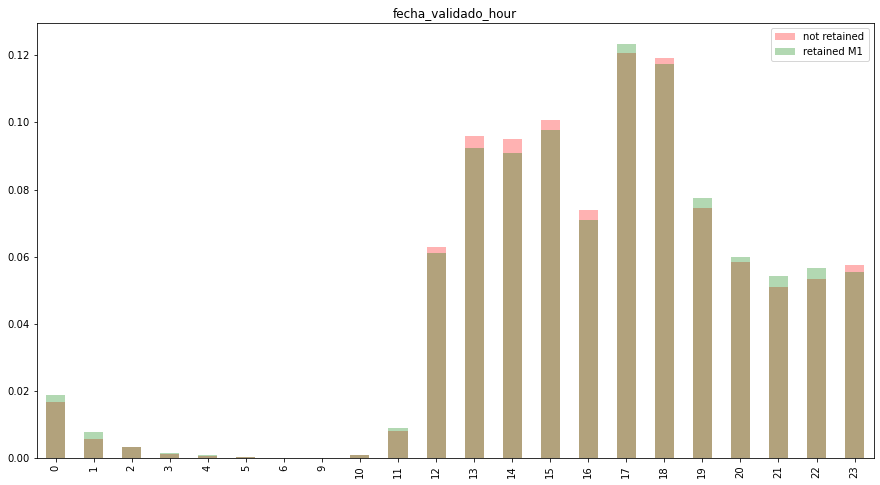

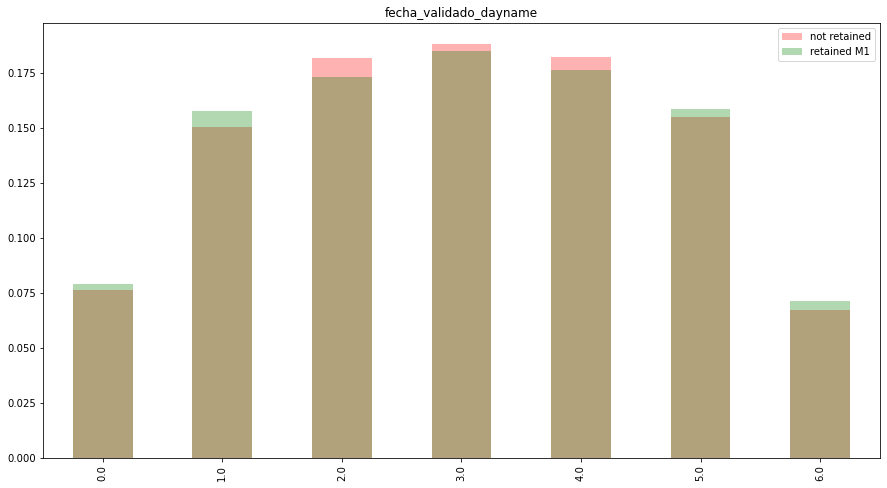

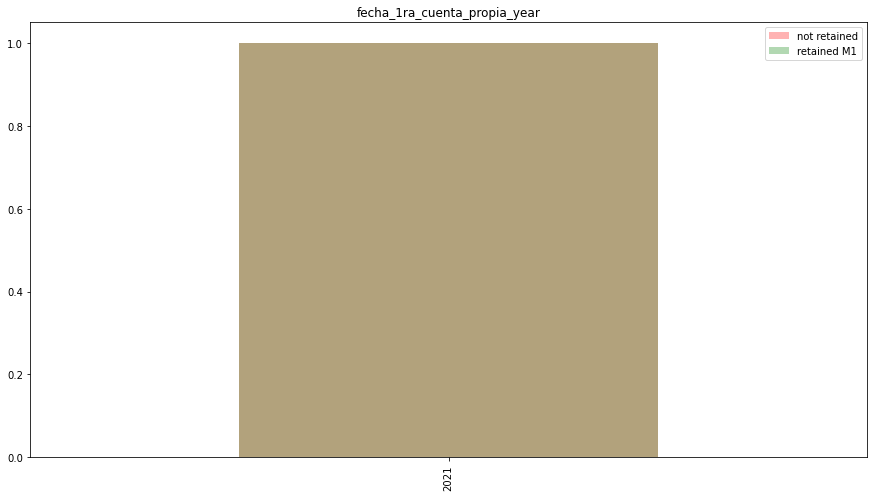

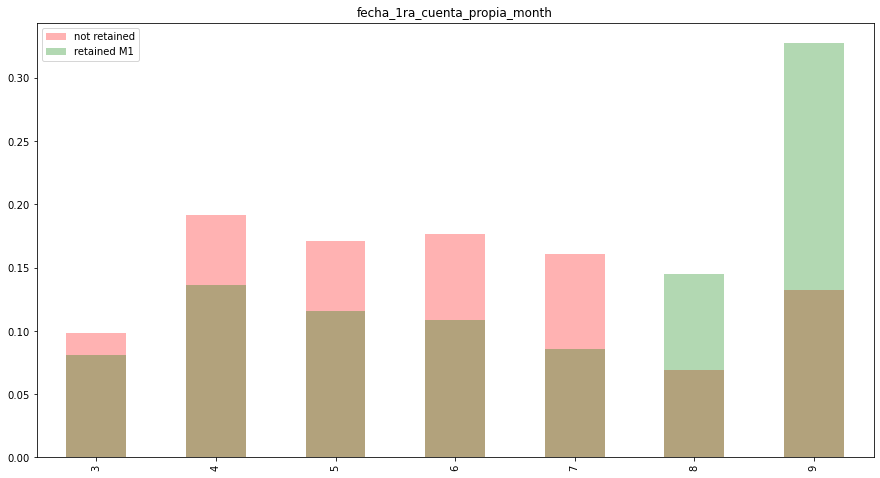

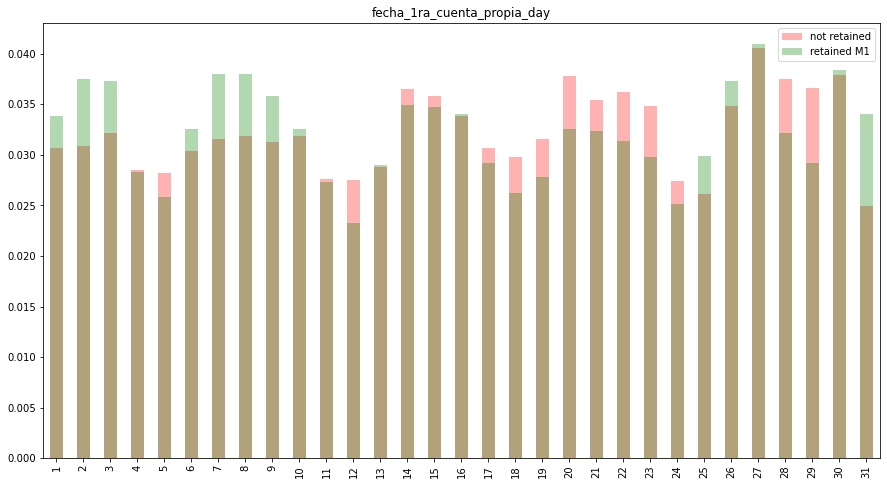

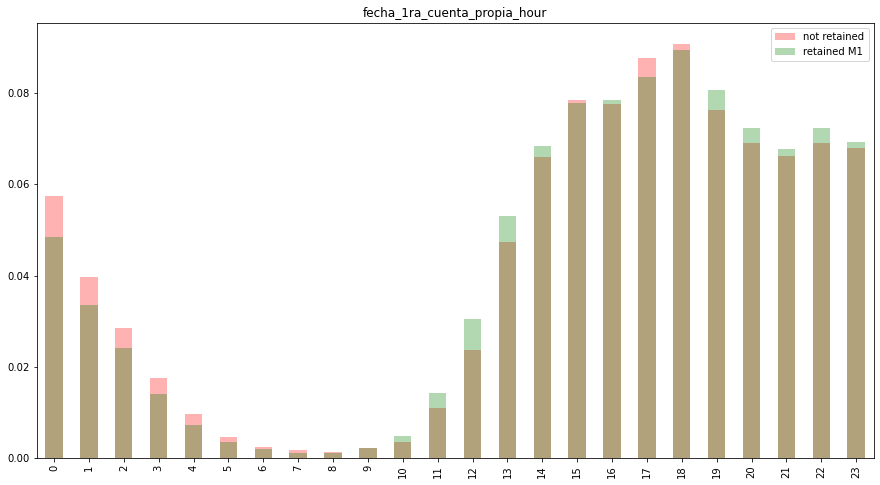

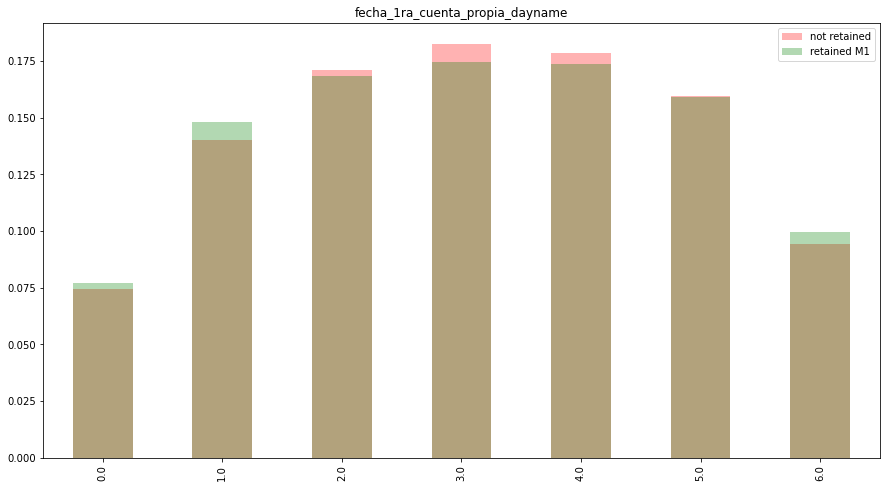

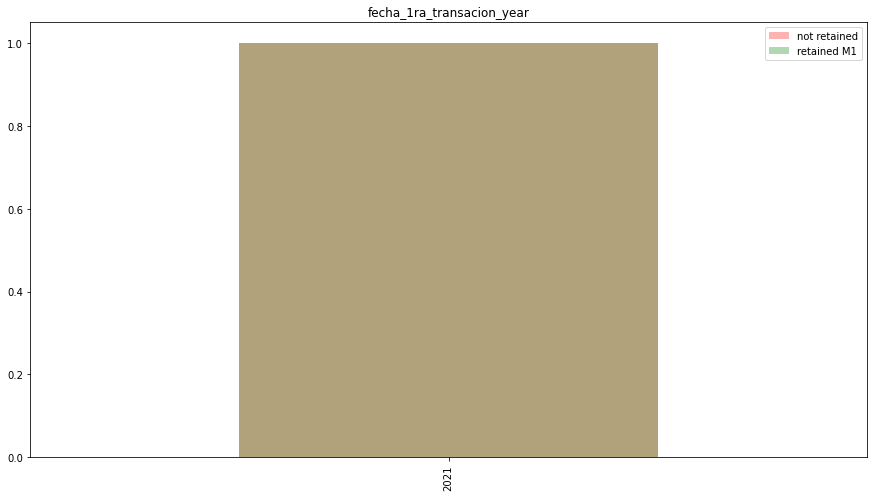

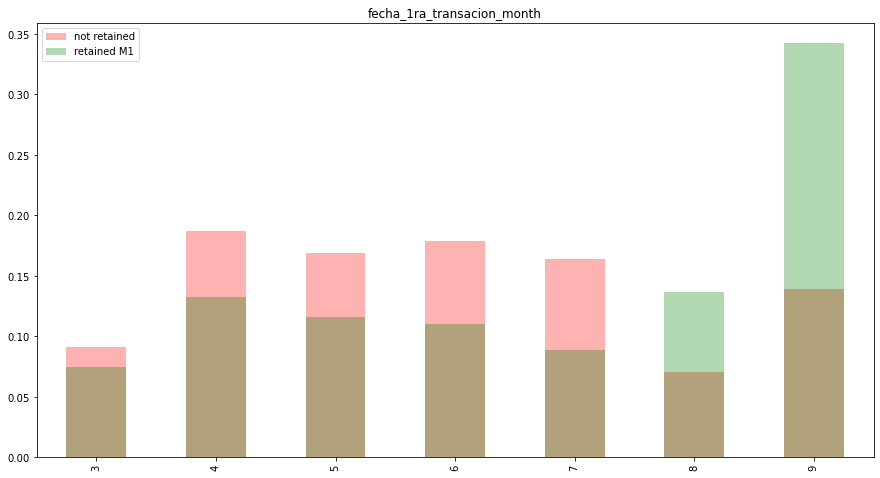

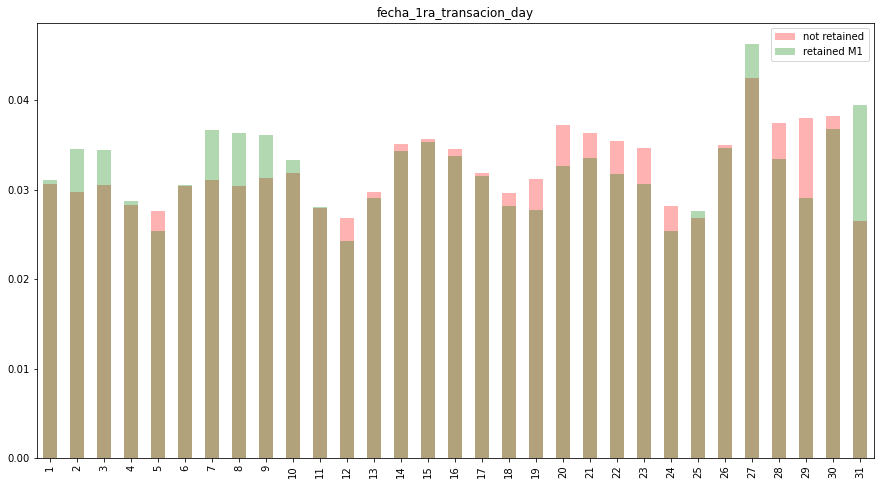

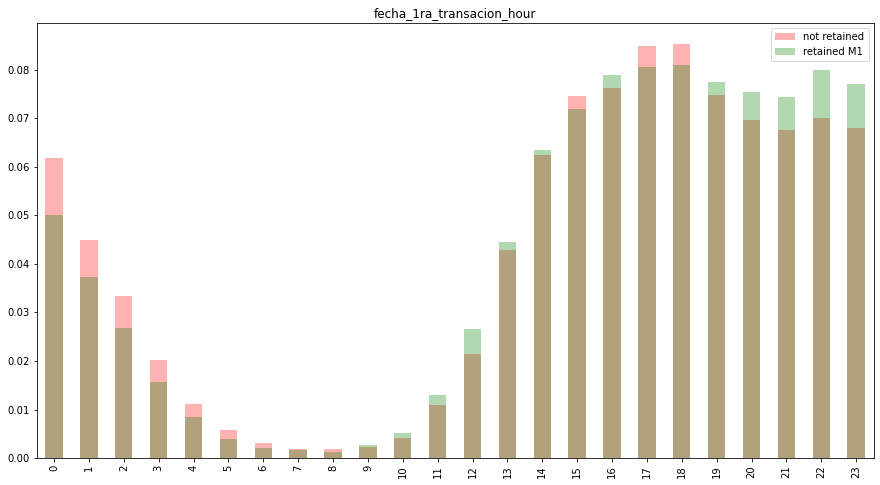

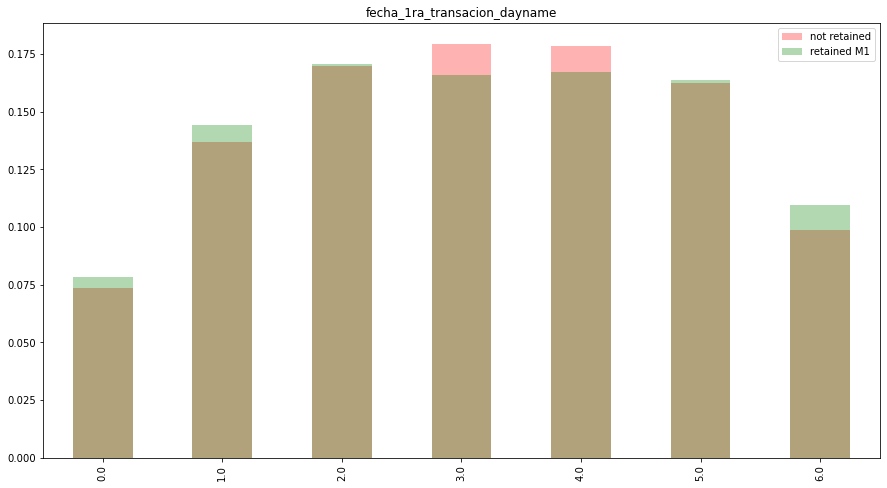

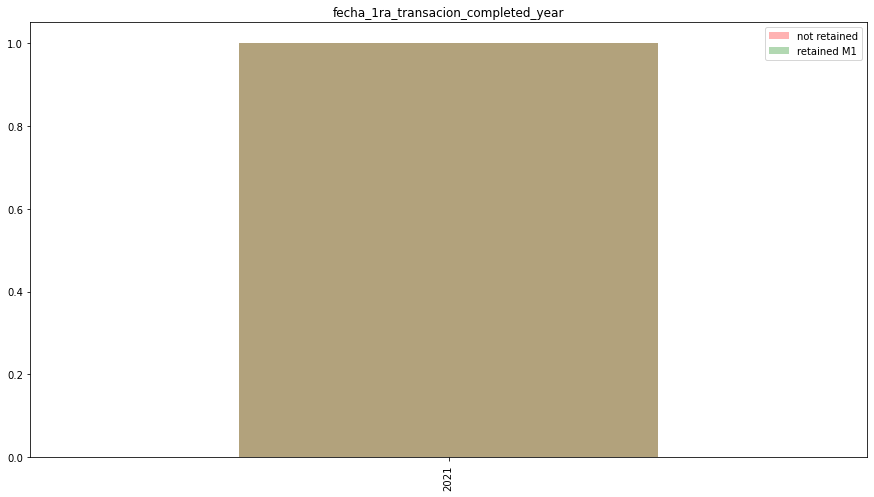

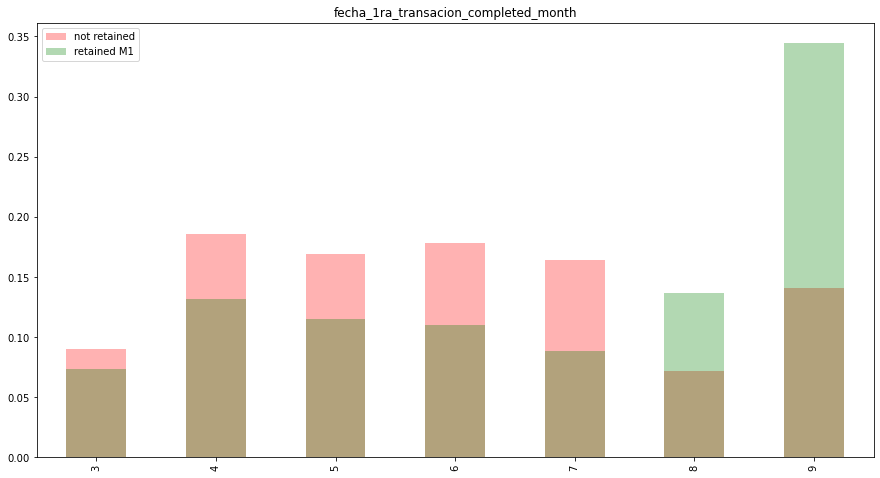

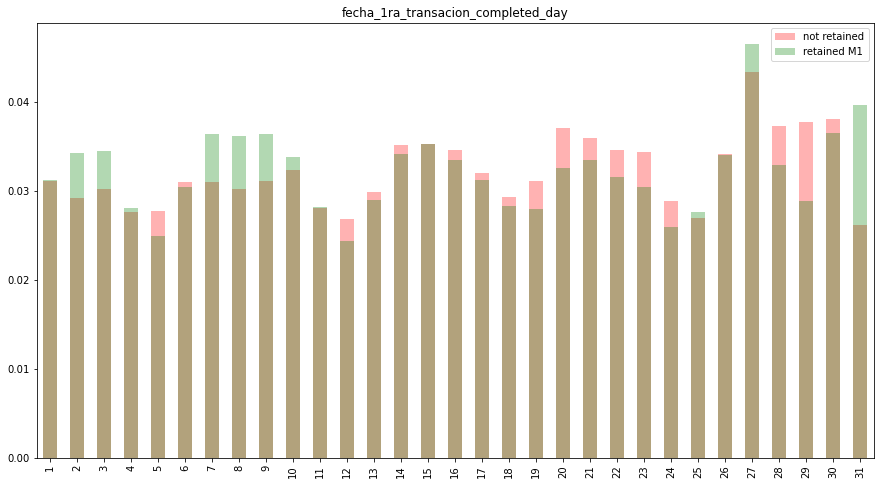

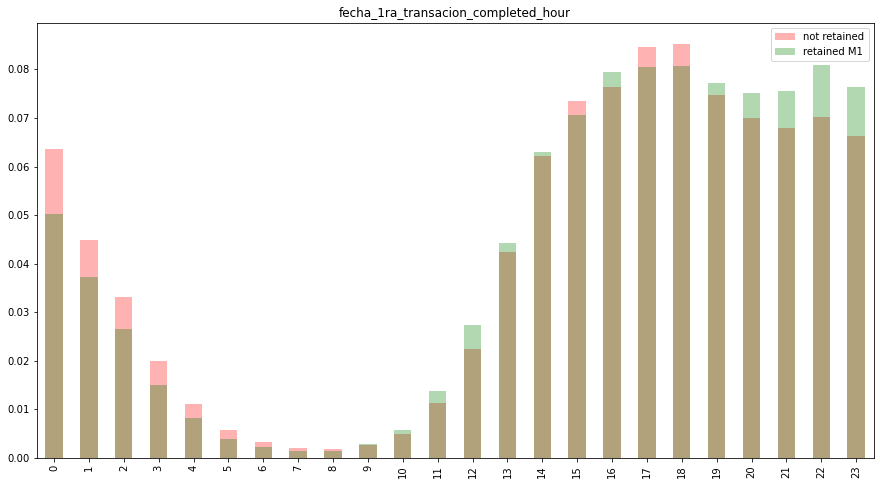

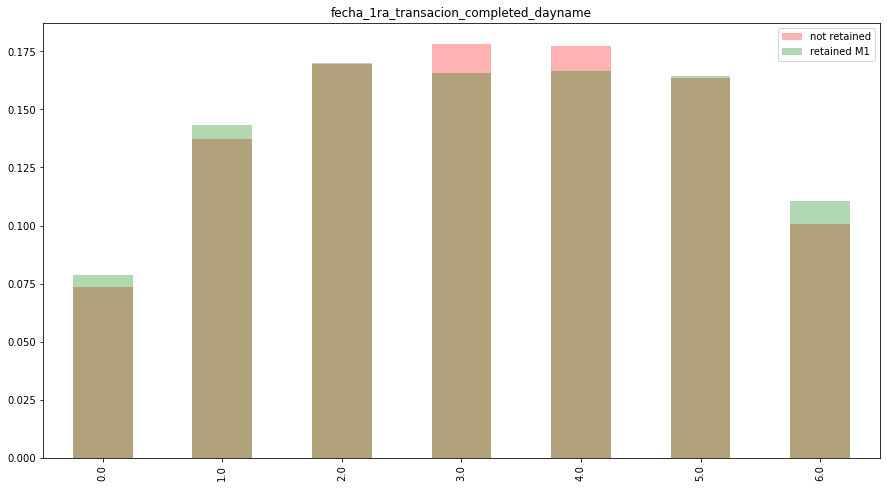

In [150]:
for i in range(45,len(data_with_date_variables.columns),1):
    col = data_with_date_variables.columns[i]
    compare_dists_dates(data_with_date_variables,col,"label")

I believe that neither the year nor the months provide us with useful information for now.

There is something interesting with the hours and the day of the month in which the transaction took place.

## Missing values

In [151]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("El dataset tiene " + str(df.shape[1]) + " columns.\n"      
            "Hay " + str(mis_val_table_ren_columns.shape[0]) +
              " columnas con valores faltantes.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [152]:
missing_values_table(data)

El dataset tiene 45 columns.
Hay 13 columnas con valores faltantes.


Missing Values  % of Total Values
gender                         12894                9.7
cuenta_principal               12606                9.5
provincia                       1185                0.9
age                              771                0.6
age_group                        771                0.6
fecha_completo_datos             387                0.3
hours_OBR-OBC                    387                0.3
hours_OBC-OBV                    387                0.3
device_manufacturer              132                0.1
device_model                     132                0.1
device_type                      132                0.1
device_screen_width              132                0.1
device_screen_height             132                0.1

In [153]:
# Here we have two options:
# 1) We delete all instances with empty main_account. When a user activates, he/she must have an associated main_account, so it does not make sense to have users without main_account.
# 2) Eliminate the main_account column and take into account the debit_account_bank column that does not have null values.
# For now let's go with the 2nd option.
data_backup = data.copy()
data.drop(columns="cuenta_principal", inplace=True)

In [154]:
missing_values_table(data)

El dataset tiene 44 columns.
Hay 12 columnas con valores faltantes.


Missing Values  % of Total Values
gender                         12894                9.7
provincia                       1185                0.9
age                              771                0.6
age_group                        771                0.6
fecha_completo_datos             387                0.3
hours_OBR-OBC                    387                0.3
hours_OBC-OBV                    387                0.3
device_manufacturer              132                0.1
device_model                     132                0.1
device_type                      132                0.1
device_screen_width              132                0.1
device_screen_height             132                0.1

Now we are going to impute the gender. I have a list of common "masculine" and "feminine" names and will use them as a dictionary to input the genders of the people ith missing gender. 

In [155]:
#Read the names dataset
data_names = pd.read_csv("data\hombres_mujeres.csv")

#Split the dataset in masculine and feminine
dataset_hombres = pd.DataFrame(data_names.loc[data_names["gender"]=="M"][["first_name","gender"]])
dataset_mujeres = pd.DataFrame(data_names.loc[data_names["gender"]=="F"][["first_name","gender"]])

#Turn each split in a dict
dicc_hombres = dict(zip(dataset_hombres.first_name,dataset_hombres.gender))
dicc_mujeres = dict(zip(dataset_mujeres.first_name,dataset_mujeres.gender))

In [156]:
idxs_nans_gender = data.loc[data["gender"].isnull(),"gender"].index

In [157]:
#I start imputing the masculine names and then continue with the feminine
data.loc[data["gender"].isnull(),"gender"] = data.loc[data["gender"].isnull(),"first_name"].map(dicc_hombres)
data.loc[data["gender"].isnull(),"gender"] = data.loc[data["gender"].isnull(),"first_name"].map(dicc_mujeres)

In [158]:
# Chequear cómo quedaron distribuidos los valores faltantes según etiquetas imputadas
# pd.set_option("display.max_rows", None, "display.max_columns", None) 
# genders_imputed = data.loc[idxs_nans_gender,["gender","first_name"]]
# genders_imputed.loc[genders_imputed["gender"].isnull(),"gender"] = "Not defined"
# genders_imputed.value_counts()

In [159]:
missing_values_table(data)

El dataset tiene 44 columns.
Hay 12 columnas con valores faltantes.


Missing Values  % of Total Values
gender                          5006                3.8
provincia                       1185                0.9
age                              771                0.6
age_group                        771                0.6
fecha_completo_datos             387                0.3
hours_OBR-OBC                    387                0.3
hours_OBC-OBV                    387                0.3
device_manufacturer              132                0.1
device_model                     132                0.1
device_type                      132                0.1
device_screen_width              132                0.1
device_screen_height             132                0.1

In [160]:
#We drop the rest missing values that we couldn't impute.
data.dropna(subset=["gender"],inplace=True)

In [161]:
print(f'Si dropeamos todos los NaNs restantes perderemos solo el {100*((len(data)-len(data.dropna(inplace=False)))/len(data)):.2f} % de los datos')

Si dropeamos todos los NaNs restantes perderemos solo el 1.28 % de los datos


In [162]:
data.dropna(inplace=True)

In [163]:
missing_values_table(data)

El dataset tiene 44 columns.
Hay 0 columnas con valores faltantes.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

## Dataset preparation

### Backup

In [164]:
data_backup_after_missing = data.copy()

### Variables for day and time of first transaction

In [165]:
# Create the day and time variables
data['fecha_1ra_transacion_completed_day'] = data['fecha_1ra_transacion_completed'].dt.day
data['fecha_1ra_transacion_completed_hour'] = data['fecha_1ra_transacion_completed'].dt.hour

In [166]:
# Encoding of date and time variables with trigonometric functions
data['fecha_1ra_transacion_completed_hour_sin'] = np.sin(data.fecha_1ra_transacion_completed_hour*(2.*np.pi/24))
data['fecha_1ra_transacion_completed_hour_cos'] = np.cos(data.fecha_1ra_transacion_completed_hour*(2.*np.pi/24))
data['fecha_1ra_transacion_completed_day_sin'] = np.sin(data.fecha_1ra_transacion_completed_day*(2.*np.pi/31))
data['fecha_1ra_transacion_completed_day_cos'] = np.cos(data.fecha_1ra_transacion_completed_day*(2.*np.pi/31))

In [167]:
data.drop(columns=["fecha_1ra_transacion_completed_day","fecha_1ra_transacion_completed_hour"], inplace=True)

<AxesSubplot:xlabel='fecha_1ra_transacion_completed_hour_cos', ylabel='fecha_1ra_transacion_completed_hour_sin'>

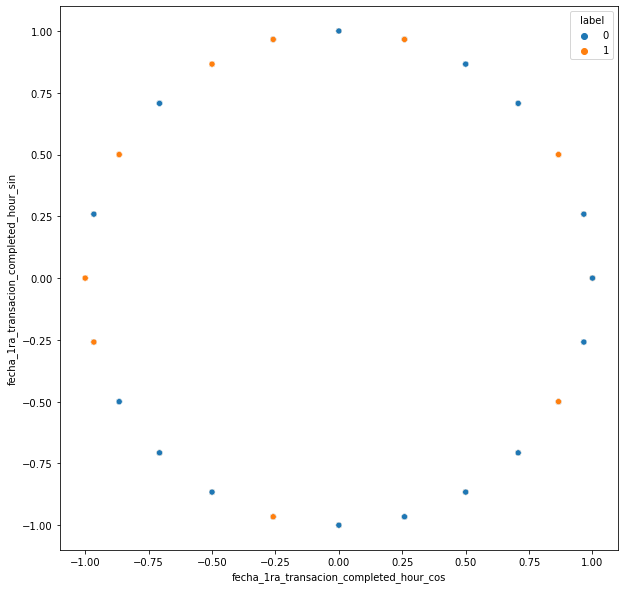

In [168]:
plt.subplots(figsize=(10,10))
sns.scatterplot(x="fecha_1ra_transacion_completed_hour_cos",y="fecha_1ra_transacion_completed_hour_sin", hue="label", data=data)

<AxesSubplot:xlabel='fecha_1ra_transacion_completed_day_cos', ylabel='fecha_1ra_transacion_completed_day_sin'>

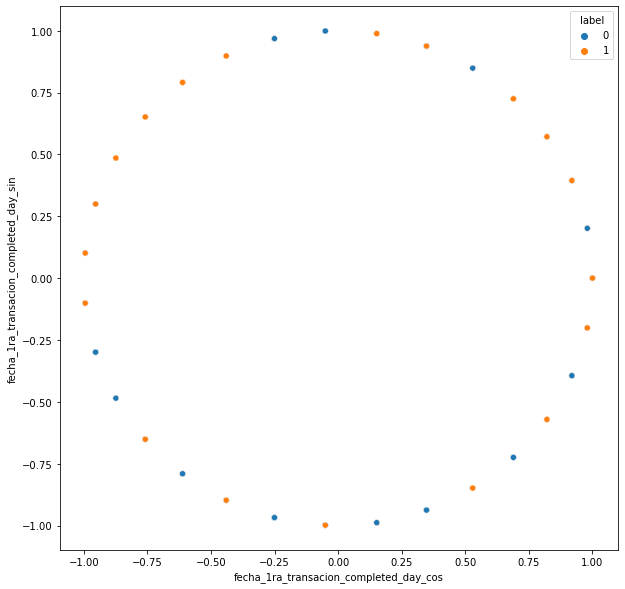

In [169]:
plt.subplots(figsize=(10,10))
sns.scatterplot(x="fecha_1ra_transacion_completed_day_cos",y="fecha_1ra_transacion_completed_day_sin", hue="label", data=data)

### We drop columns without major importance

In [170]:
columnas_a_eliminar = ["media_source","fecha_registro","fecha_completo_datos","fecha_validado","fecha_1ra_cuenta_propia","fecha_1ra_transacion","fecha_1ra_transacion_completed",
                       "product_1ra_transacion","product_1ra_transacion_completed","ret_30d","age","provincia","device_model","device_screen_width","device_screen_height","first_name","device_manufacturer","carrier","device_type",
                      "limite_ampliado"]

In [171]:
data.drop(columns=columnas_a_eliminar, inplace=True)

In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125746 entries, 64fed5b8-2932-4490-8027-6a476944bc33 to d7c6c751-1b43-4615-8989-c4848b21fa08
Data columns (total 28 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   canal                                    125746 non-null  object 
 1   debit_account_bank                       125746 non-null  object 
 2   credit_account_bank                      125746 non-null  object 
 3   credit_account_type                      125746 non-null  object 
 4   amount                                   125746 non-null  float64
 5   lookup_key_type                          125746 non-null  object 
 6   transfer_between_own_accounts            125746 non-null  int32  
 7   actividad_principal                      125746 non-null  int64  
 8   cant_attempts                            125746 non-null  int64  
 9   gender                                   12

### We cluster the banks by type

In [173]:
dict_bancos = {'BRUBANK':'banco_virtual',
                'BBVA':'banco_privado', 
               'BICA':'banco_privado', 
               'BIND':'banco_privado',
               'COINAG':'banco_privado', 
               'COLUMBIA':'banco_privado', 
               'COMAFI':'banco_privado',
               'CREDICOOP':'banco_privado',
               'DINO':'banco_privado', 
               'GALICIA':'banco_privado',
               'HIPOTECARIO':'banco_privado',
               'HSBC':'banco_privado', 
               'ICBC':'banco_privado', 
               'ITAU':'banco_privado',
               'MARIVA':'banco_privado',
               'MACRO':'banco_privado', 
               'MASVENTAS':'banco_privado', 
               'PATAGONIA':'banco_privado', 
               'PIANO':'banco_privado', 
               'ROELA':'banco_privado', 
               'SANTANDER':'banco_privado', 
               'SUPERVIELLE':'banco_privado',
               'NACION':'banco_nacional',
               'BANCOR':'banco_provincial', 
               'BSE':'banco_provincial', 
               'CHACO':'banco_provincial',
               'CHUBUT':'banco_provincial', 
               'CIUDAD':'banco_provincial', 
               'CORRIENTES':'banco_provincial', 
               'ENTRERIOS':'banco_provincial', 
               'FORMOSA':'banco_provincial', 
               'LAPAMPA':'banco_provincial', 
               'NEUQUEN':'banco_provincial',
               'PROVINCIA':'banco_provincial', 
               'RIOJA':'banco_provincial', 
               'ROSARIO':'banco_provincial', 
               'SANJUAN':'banco_provincial',
               'SANTACRUZ':'banco_provincial', 
               'SANTAFE':'banco_provincial',
               'TIERRADELFUEGO':'banco_provincial',
               'FISERV':'comercio',
               'MERCADOPAGO':'billetera',
               'NARANJAX':'banco_virtual',
               'NUBI':'banco_virtual',
               'OPENBANK':'banco_virtual',
               'REBANKING':'banco_virtual',
               'TAP':'billetera',
               'UALA':'billetera',
               'YACARE':'comercio'
              }
set(dict_bancos.values())

{'banco_nacional',
 'banco_privado',
 'banco_provincial',
 'banco_virtual',
 'billetera',
 'comercio'}

In [174]:
def group_banks_by_type(dataset,columns,dict_bancos):
    for i in range(len(columns)):
        dataset.loc[:,columns[i]] = dataset.loc[:,columns[i]].map(dict_bancos)

In [175]:
group_banks_by_type(data,["debit_account_bank","credit_account_bank"],dict_bancos)

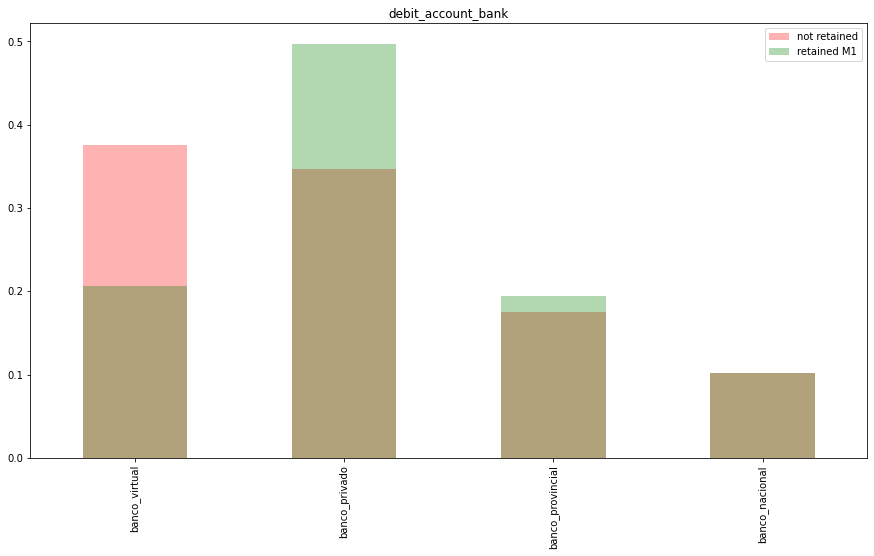

In [176]:
 compare_dists(data,"debit_account_bank","label")

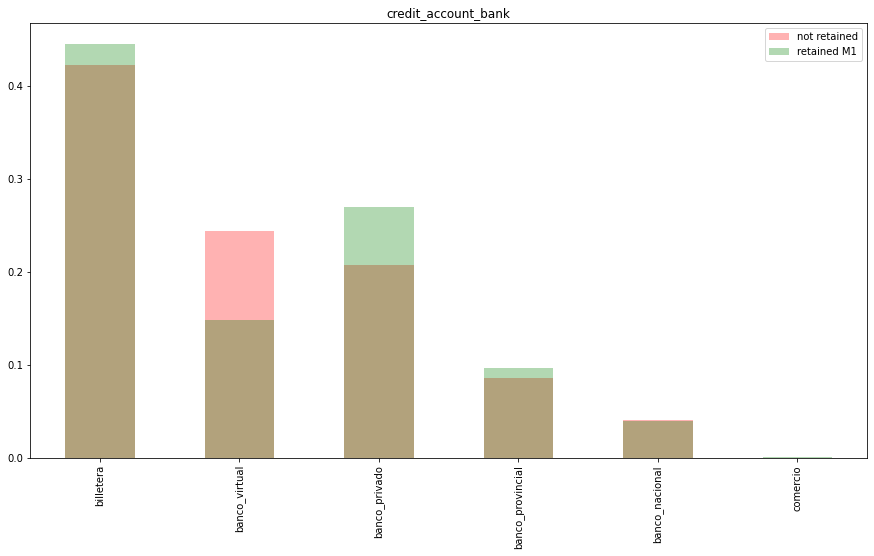

In [177]:
 compare_dists(data,"credit_account_bank","label")

### We cluster the account types in CBU and CVU

In [178]:
# pasamos los valores CA y CC a CBU
dict_cuentas = {'CA':'CBU',
                'CV':'CVU',
                'CC':'CBU' 
}

In [179]:
def group_accounts_by_type(dataset,columns,dict_cuentas):
    for i in range(len(columns)):
        dataset.loc[:,columns[i]] = dataset.loc[:,columns[i]].map(dict_cuentas)

In [180]:
group_accounts_by_type(data,["credit_account_type"],dict_cuentas)

In [181]:
data["credit_account_type"]

user_id
64fed5b8-2932-4490-8027-6a476944bc33    CVU
0982fad5-f4dd-4556-bc01-a01e49759ef7    CBU
c2e58e59-c429-4706-8041-9f4496d29d20    CBU
3062c509-0adb-47c3-adea-86b5c59a9743    CBU
6f864f24-9e77-4b22-b764-efc275cd463c    CBU
                                       ... 
7ff5262e-8558-478d-b958-cca485d9c3f4    CVU
ac325018-156b-4100-9af8-62397713d4b9    CBU
a385ba96-0465-4441-84d1-86849b13c15d    CBU
3b014231-5a71-4292-8a55-d7a763ffc89e    CBU
d7c6c751-1b43-4615-8989-c4848b21fa08    CBU
Name: credit_account_type, Length: 125746, dtype: object

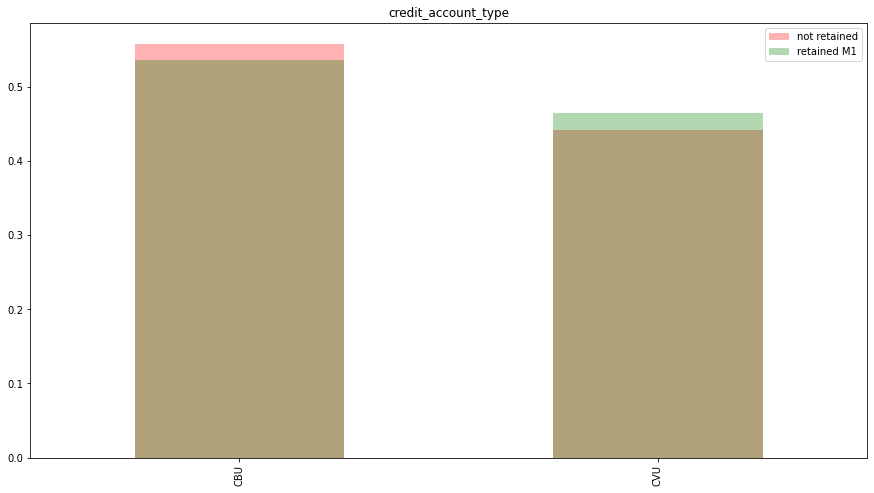

In [182]:
compare_dists(data,"credit_account_type","label")

### We take the logarithm of the amount of the first transaction

In [183]:
data["log_amount"] = np.log(data.amount)

In [184]:
data.log_amount

user_id
64fed5b8-2932-4490-8027-6a476944bc33    0.693147
0982fad5-f4dd-4556-bc01-a01e49759ef7    1.386294
c2e58e59-c429-4706-8041-9f4496d29d20    4.605170
3062c509-0adb-47c3-adea-86b5c59a9743    9.657139
6f864f24-9e77-4b22-b764-efc275cd463c    6.907755
                                          ...   
7ff5262e-8558-478d-b958-cca485d9c3f4    5.966147
ac325018-156b-4100-9af8-62397713d4b9    6.907755
a385ba96-0465-4441-84d1-86849b13c15d    2.708050
3b014231-5a71-4292-8a55-d7a763ffc89e    2.708050
d7c6c751-1b43-4615-8989-c4848b21fa08    6.214608
Name: log_amount, Length: 125746, dtype: float64

In [185]:
data.drop(columns="amount", inplace=True)

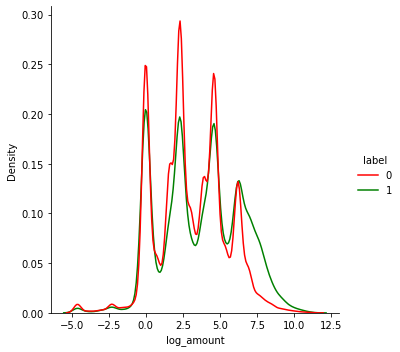

In [186]:
sns.displot(data=data, x="log_amount", kind='kde', hue="label", common_norm=False, palette=["red","green"])

### We discretize the amount of the amount of the first transaction

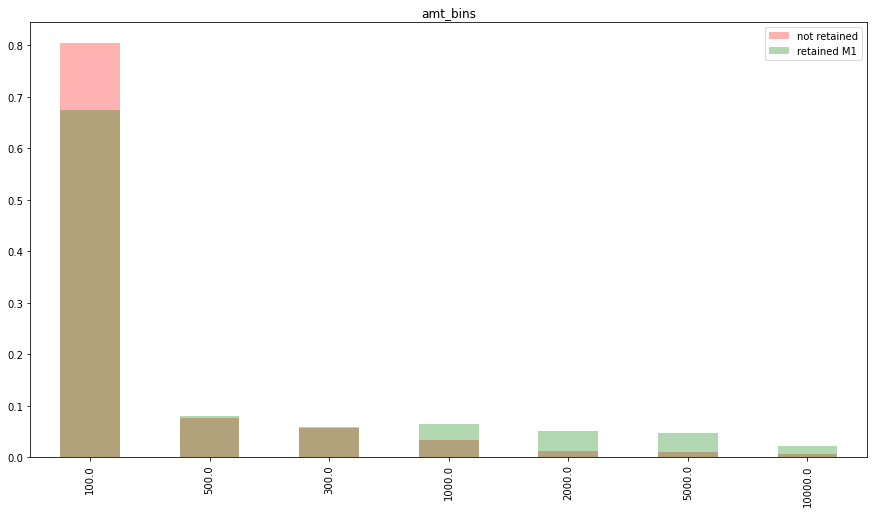

In [187]:
compare_dists(data,"amt_bins","label")

### Lookup type

In [188]:
dict_lookup = {'CBU':'CBU',
               'PHONE':'PHONE OR EMAIL',
               'EMAIL':'PHONE OR EMAIL'    
}

In [189]:
def group_lookups_by_type(dataset,columns,dict_lookup):
    for i in range(len(columns)):
        dataset.loc[:,columns[i]] = dataset.loc[:,columns[i]].map(dict_lookup)

In [190]:
group_lookups_by_type(data,["lookup_key_type"],dict_lookup)

In [191]:
data.lookup_key_type

user_id
64fed5b8-2932-4490-8027-6a476944bc33               CBU
0982fad5-f4dd-4556-bc01-a01e49759ef7               CBU
c2e58e59-c429-4706-8041-9f4496d29d20    PHONE OR EMAIL
3062c509-0adb-47c3-adea-86b5c59a9743               CBU
6f864f24-9e77-4b22-b764-efc275cd463c               CBU
                                             ...      
7ff5262e-8558-478d-b958-cca485d9c3f4               CBU
ac325018-156b-4100-9af8-62397713d4b9               CBU
a385ba96-0465-4441-84d1-86849b13c15d               CBU
3b014231-5a71-4292-8a55-d7a763ffc89e               CBU
d7c6c751-1b43-4615-8989-c4848b21fa08    PHONE OR EMAIL
Name: lookup_key_type, Length: 125746, dtype: object

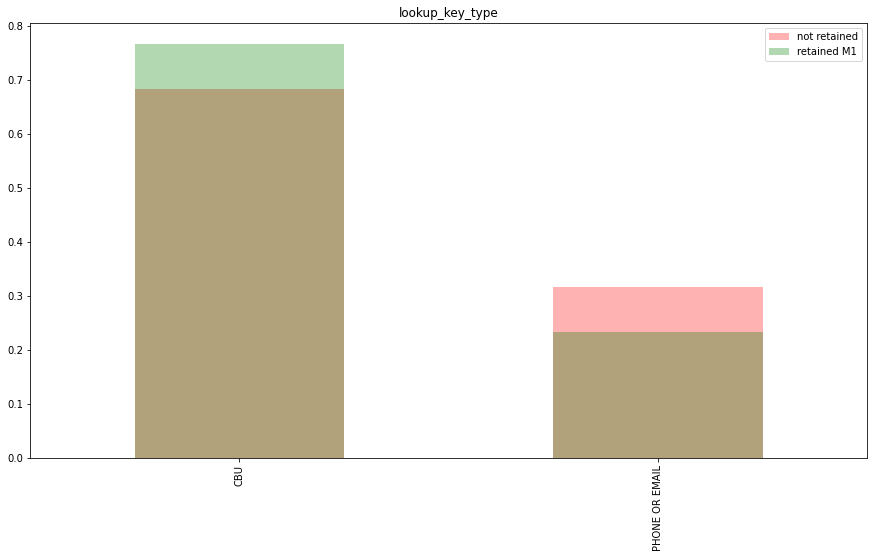

In [192]:
compare_dists(data,"lookup_key_type","label")

### Main activity

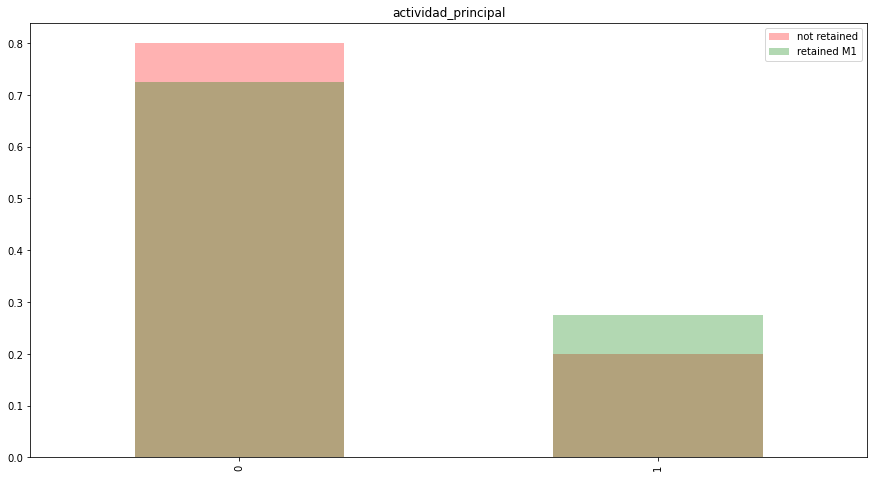

In [193]:
compare_dists(data,"actividad_principal","label")

### Quantity of attempts to fulfill the first successful transaction (if this variable is >0, it means the user had an error on one of his/her first attempts to transact)

In [194]:
# Binarizamos la variable
data.loc[data.cant_attempts==0,"cant_attempts"]=0
data.loc[data.cant_attempts>0,"cant_attempts"]=1

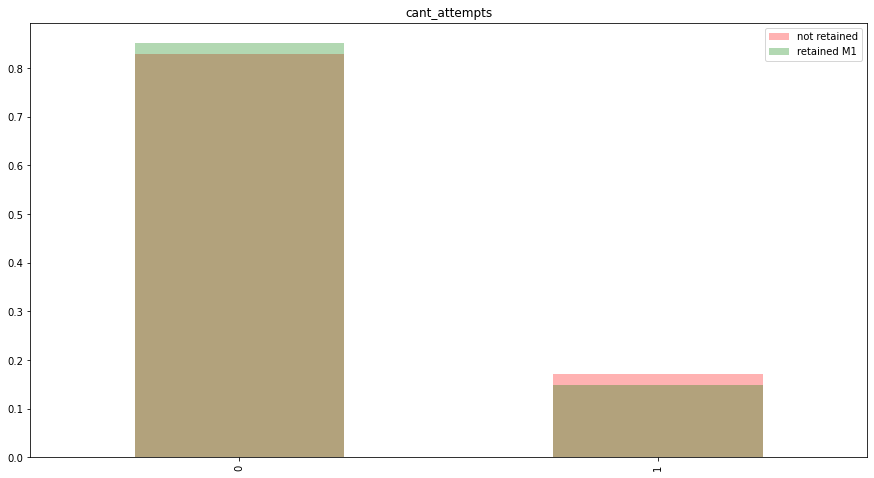

In [195]:
compare_dists(data,"cant_attempts","label")

### Gender

In [196]:
dict_gender = {'F':0,'M':1}

In [197]:
data.loc[:,'gender'] = data.loc[:,'gender'].map(dict_gender)

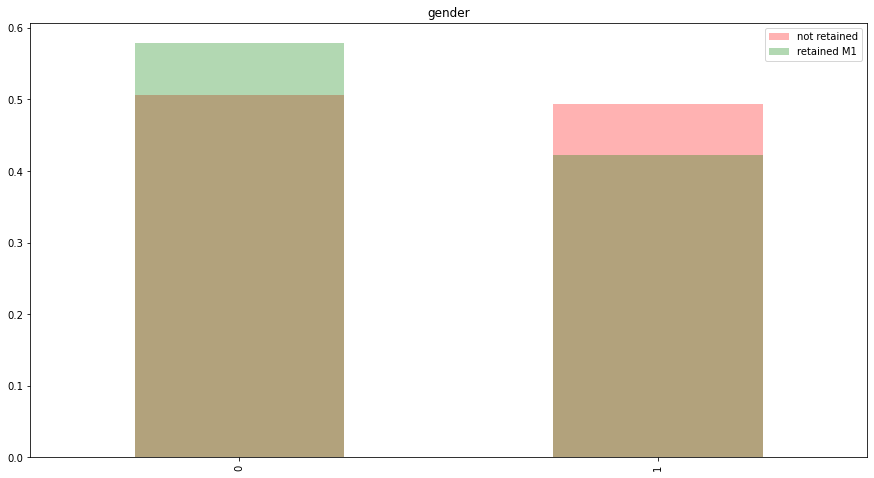

In [198]:
compare_dists(data,"gender","label")

### Age group

In [199]:
dict_age = {'25-':0, '25-34':1, '35-45':2, '55+':3, '46-55':4}
data.loc[:,'age_group'] = data.loc[:,'age_group'].map(dict_age)

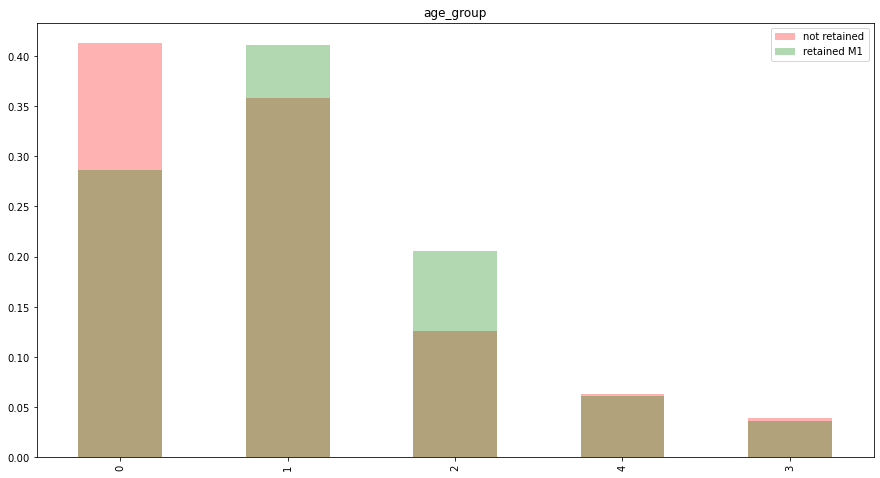

In [200]:
compare_dists(data,"age_group","label")

### Country region

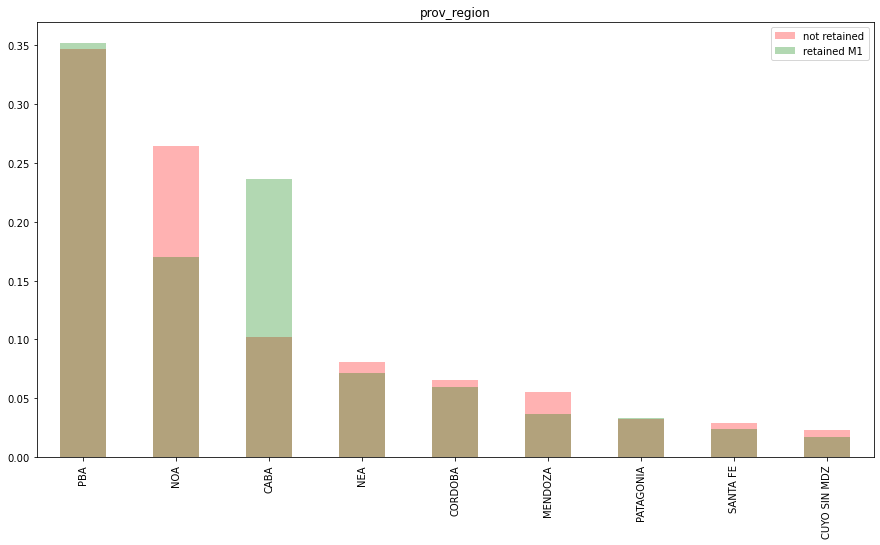

In [201]:
compare_dists(data,"prov_region","label")

### Quantity of contacts

In [202]:
data.cant_contactos_bancos.value_counts()/len(data)

0     0.951132
1     0.045997
2     0.002266
3     0.000350
4     0.000111
5     0.000072
7     0.000024
6     0.000016
12    0.000008
8     0.000008
9     0.000008
11    0.000008
Name: cant_contactos_bancos, dtype: float64

In [203]:
data.loc[data.cant_contactos_bancos == 0,"cant_contactos_bancos"] = 0
data.loc[data.cant_contactos_bancos >= 1,"cant_contactos_bancos"] = 1

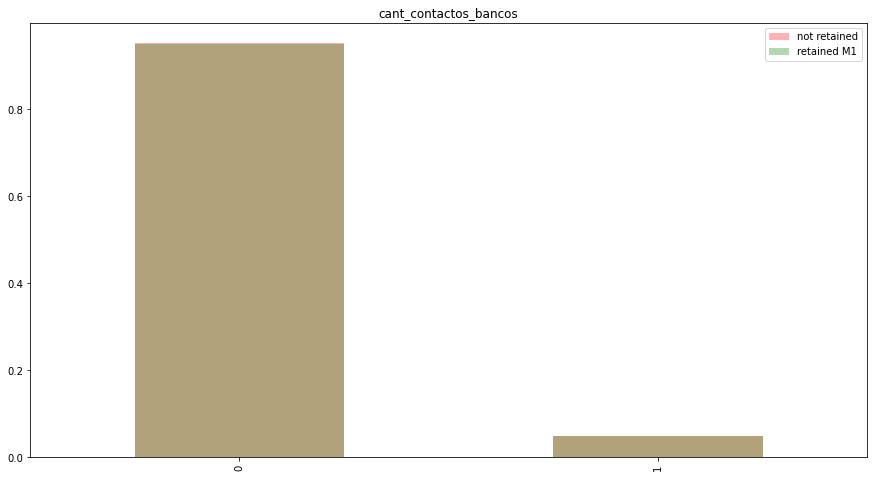

In [204]:
compare_dists(data,"cant_contactos_bancos","label")

### Quantity of accounts added (the user could add more than 1 account to the wallet)

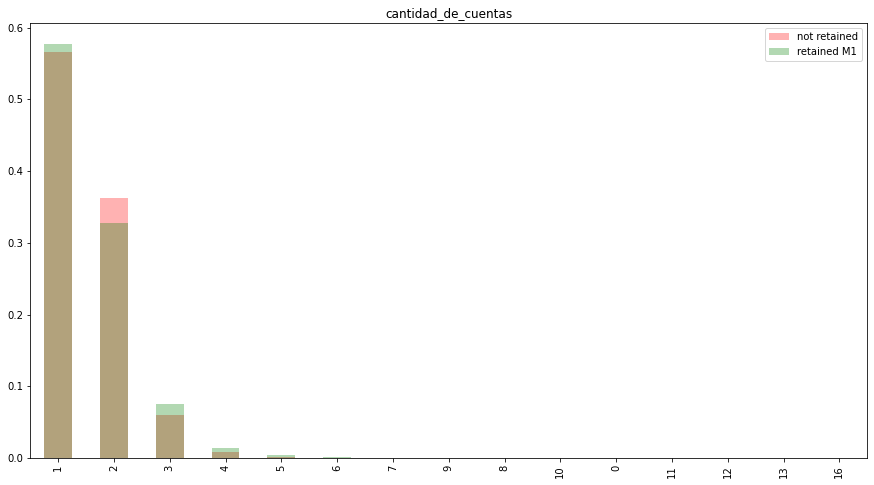

In [208]:
compare_dists(data,"cantidad_de_cuentas","label")

In [209]:
data.loc[data["cantidad_de_cuentas"]>1,"cantidad_de_cuentas"]=2

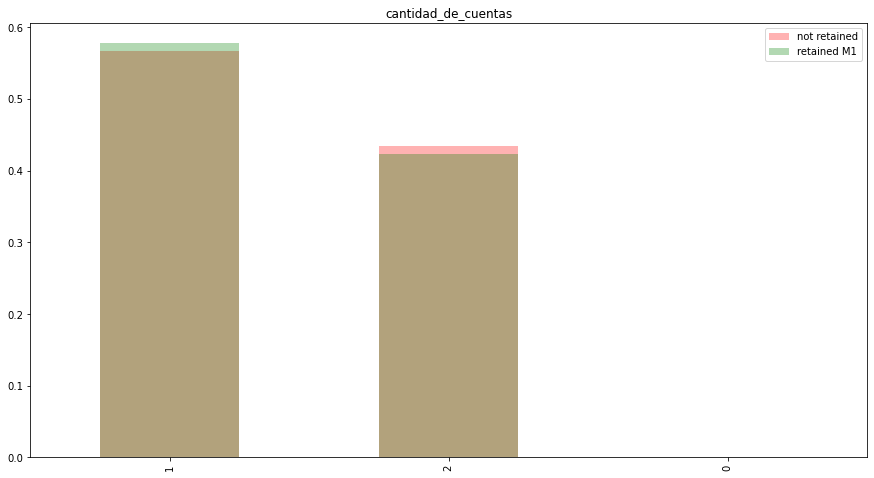

In [210]:
compare_dists(data,"cantidad_de_cuentas","label")

### Quantity of banks

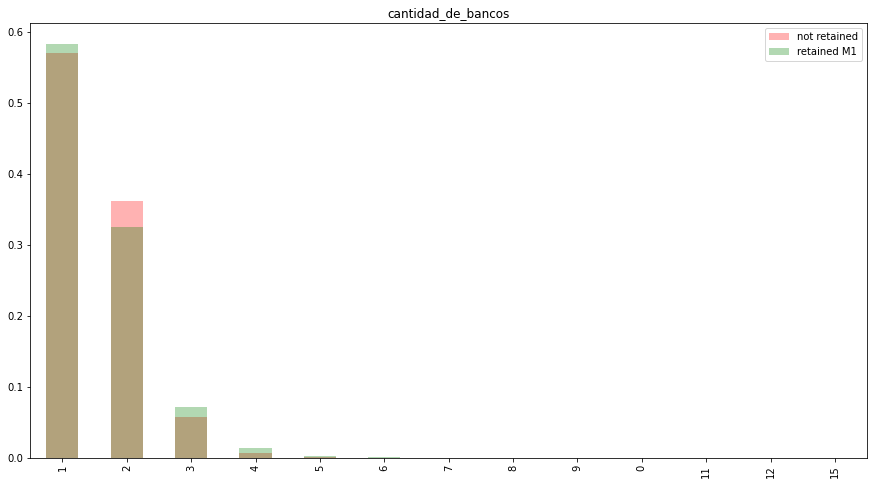

In [211]:
compare_dists(data,"cantidad_de_bancos","label")

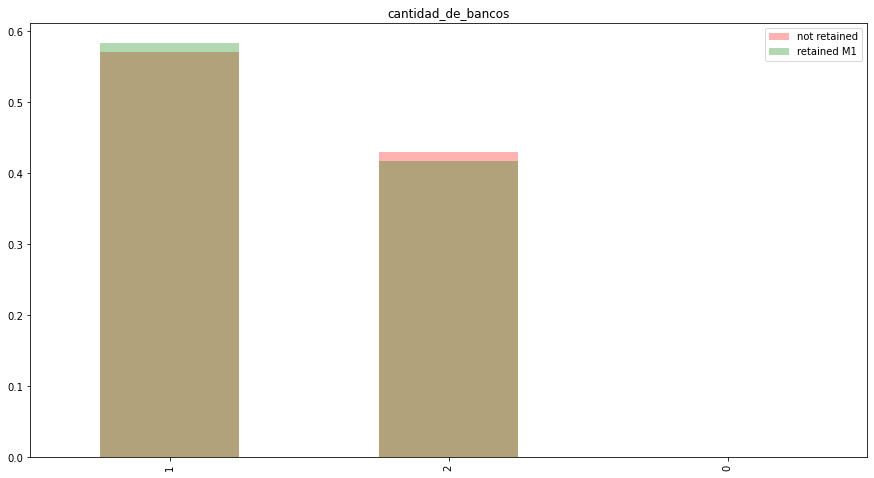

In [212]:
data.loc[data["cantidad_de_bancos"]>1,"cantidad_de_bancos"]=2
compare_dists(data,"cantidad_de_bancos","label")

### Quantity of CVU accounts (these kind of accounts are associated with virtual wallets)

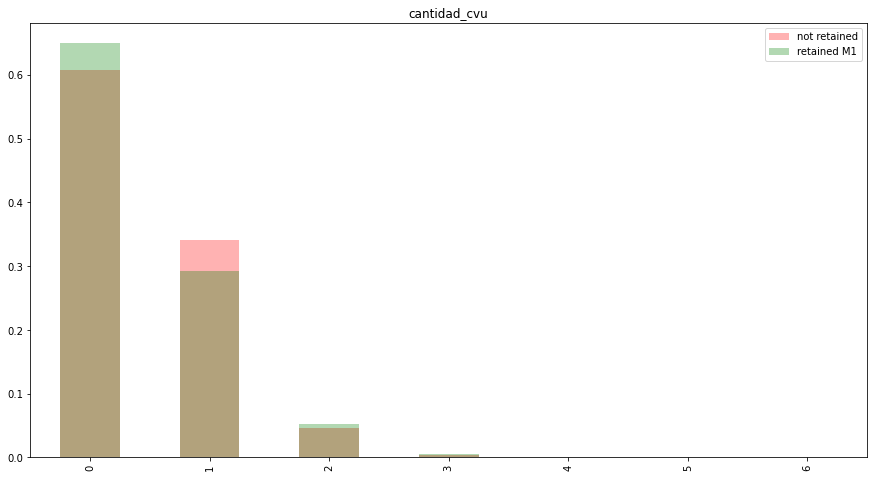

In [213]:
compare_dists(data,"cantidad_cvu","label")

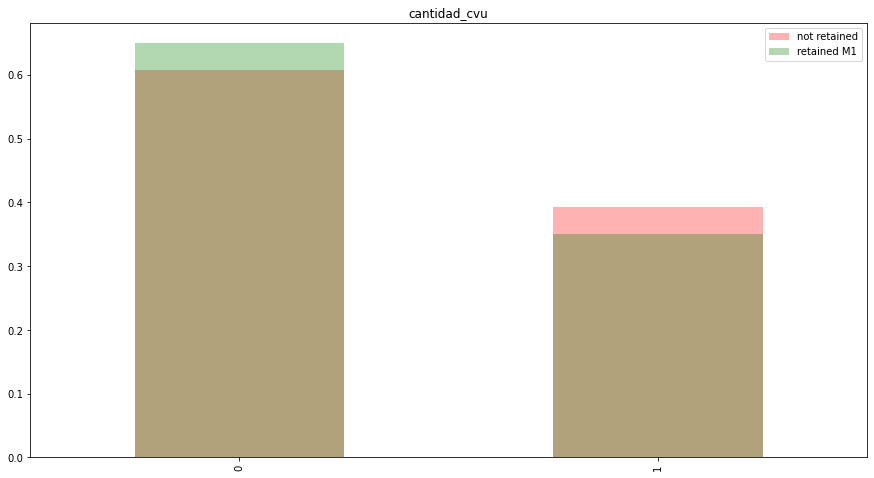

In [214]:
data.loc[data["cantidad_cvu"]>0,"cantidad_cvu"]=1
compare_dists(data,"cantidad_cvu","label")

### Quantity of CBU accounts (these kind of accounts are bank accounts)

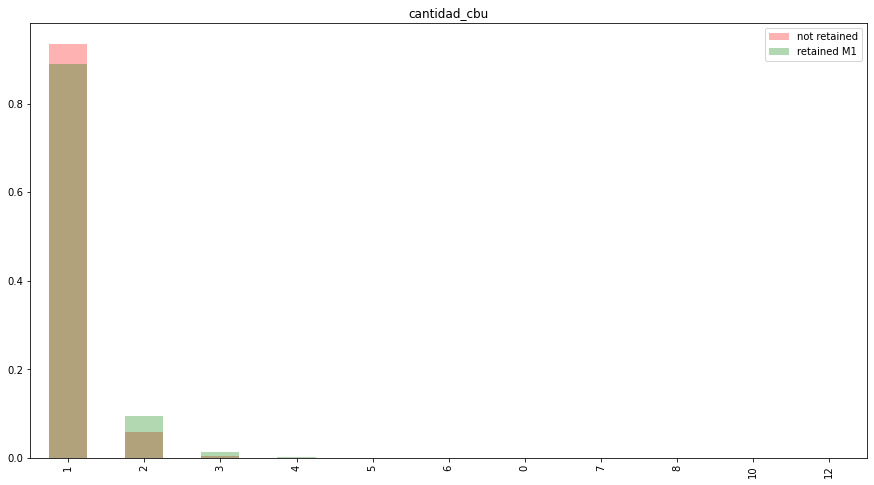

In [215]:
compare_dists(data,"cantidad_cbu","label")

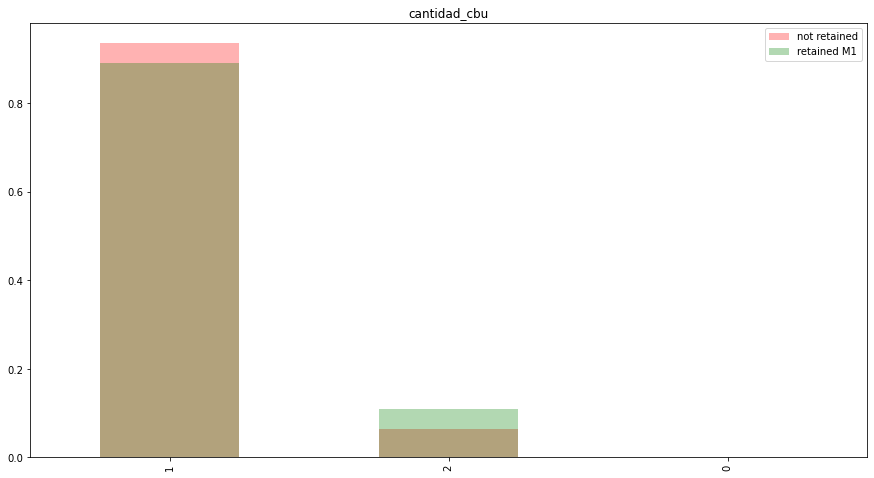

In [216]:
data.loc[data["cantidad_cbu"]>1,"cantidad_cbu"]=2
compare_dists(data,"cantidad_cbu","label")

### Hours OBR-OBC (Hours from start register to complete register at the onboarding stage)

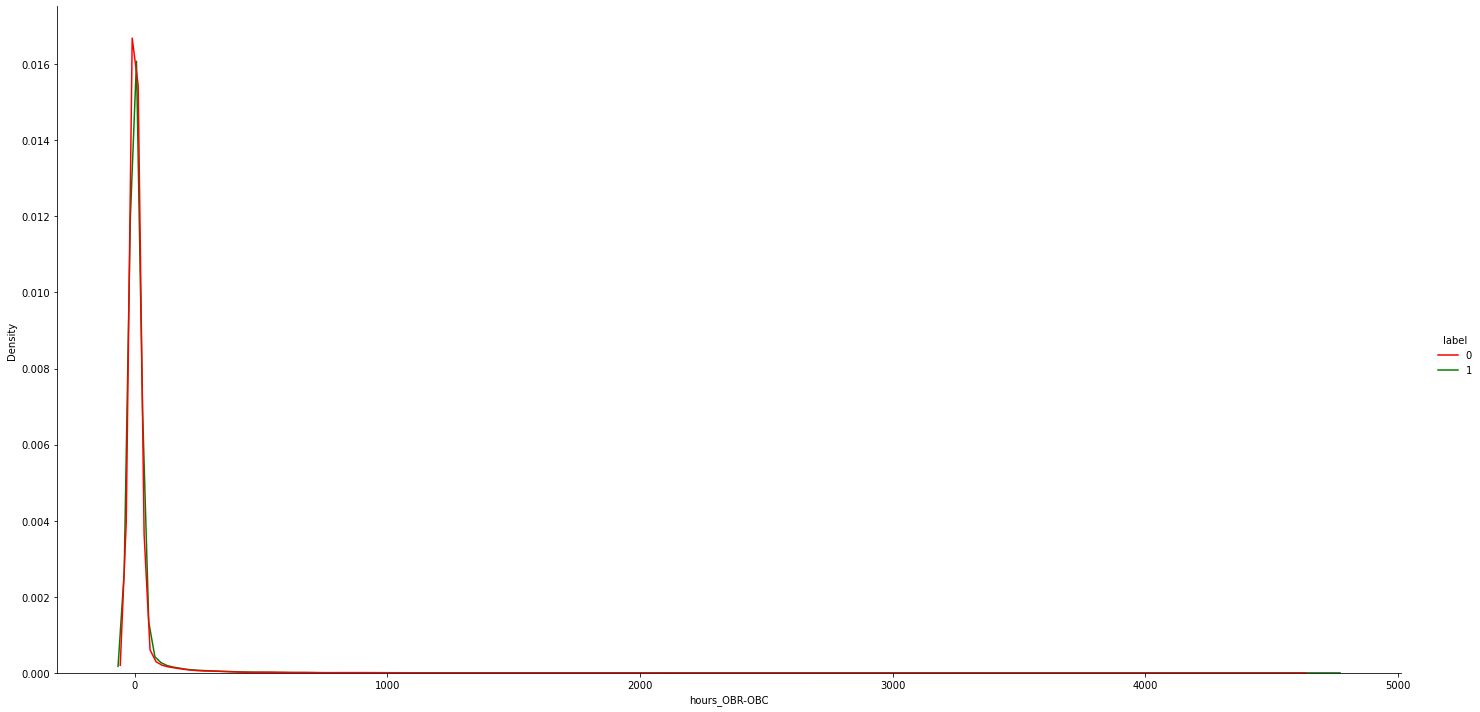

In [217]:
sns.displot(data=data, x="hours_OBR-OBC", kind='kde', hue="label", common_norm=False, palette=["red","green"], height=10, aspect=2)

In [218]:
np.quantile(data["hours_OBR-OBC"],0.99)

482.88105555555643

In [219]:
data.loc[data["hours_OBR-OBC"]>np.quantile(data["hours_OBR-OBC"],0.99),"hours_OBR-OBC"]=np.quantile(data["hours_OBR-OBC"],0.99)

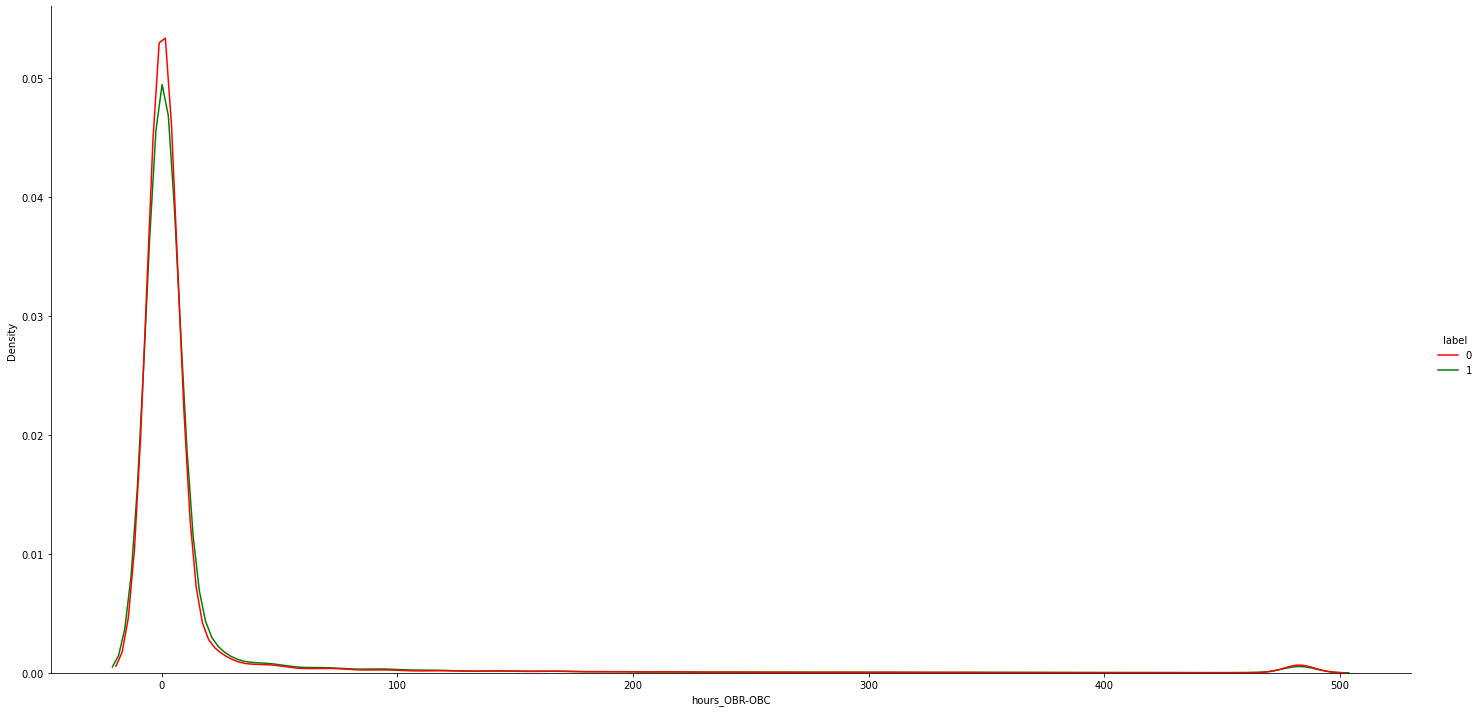

In [220]:
sns.displot(data=data, x="hours_OBR-OBC", kind='kde', hue="label", common_norm=False, palette=["red","green"], height=10, aspect=2)

### Hours OBC-OBV (Hours from complete register to validate register at the onboarding stage)

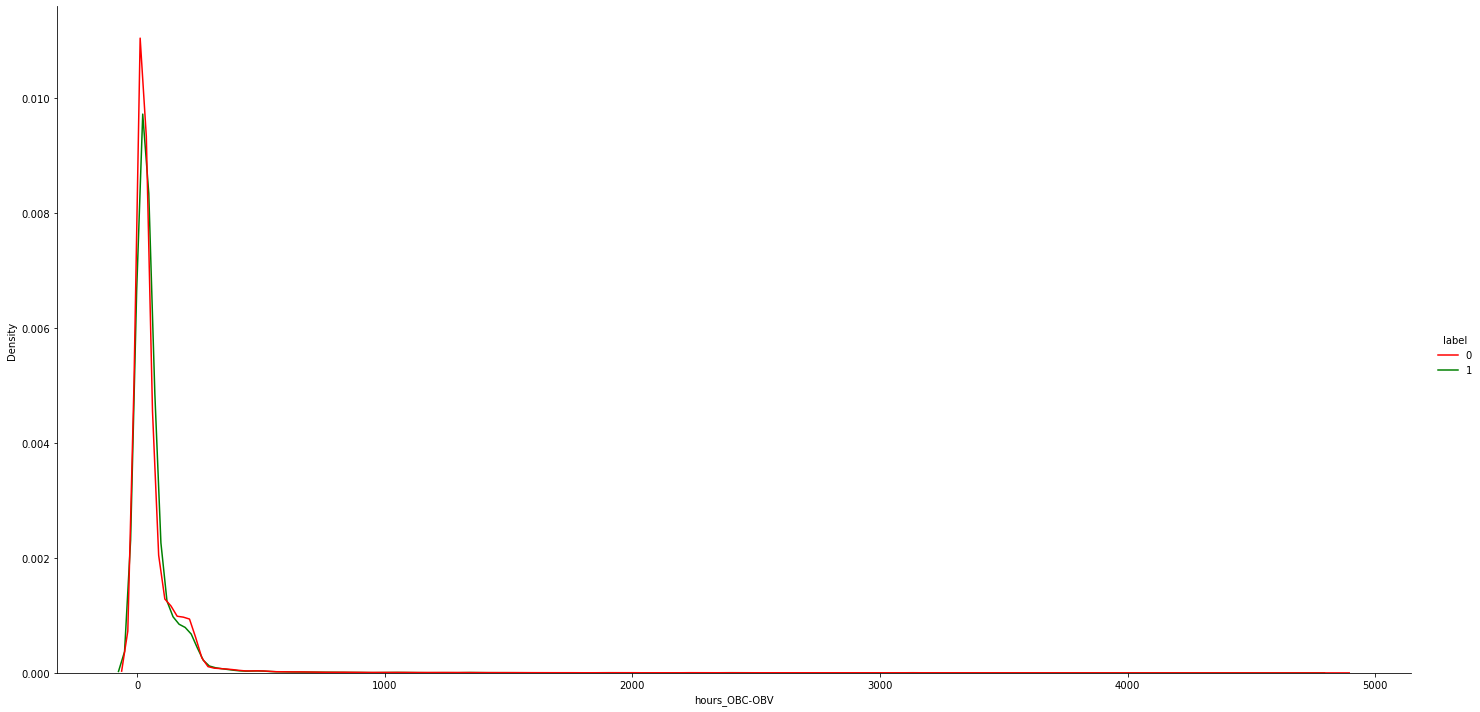

In [221]:
sns.displot(data=data, x="hours_OBC-OBV", kind='kde', hue="label", common_norm=False, palette=["red","green"], height=10, aspect=2)

In [222]:
np.quantile(data["hours_OBC-OBV"],0.99)

739.7588472222229

In [223]:
data.loc[data["hours_OBC-OBV"]>np.quantile(data["hours_OBC-OBV"],0.99),"hours_OBC-OBV"]=np.quantile(data["hours_OBC-OBV"],0.99)

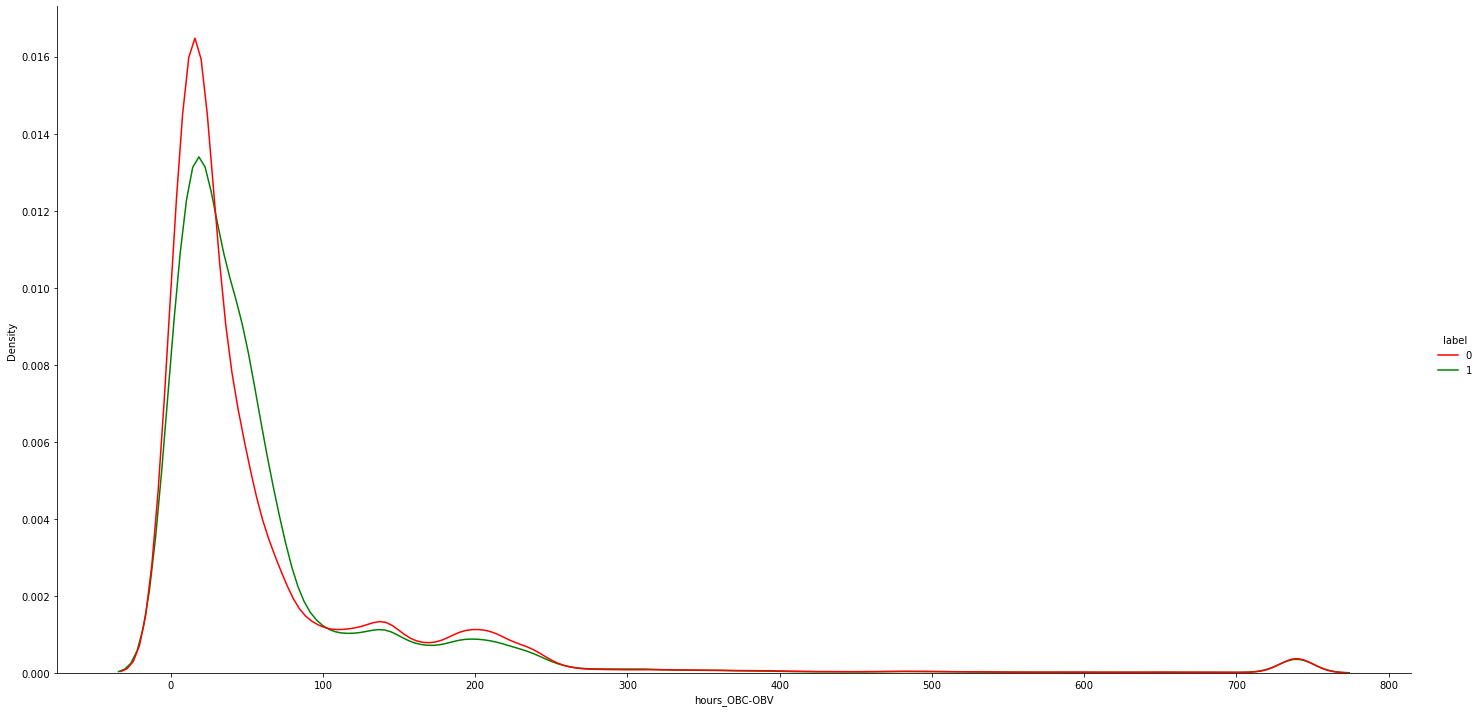

In [224]:
sns.displot(data=data, x="hours_OBC-OBV", kind='kde', hue="label", common_norm=False, palette=["red","green"], height=10, aspect=2)

### Hours_OBV-OB1Acc (Hours from validate register to add the first account at the onboarding stage)

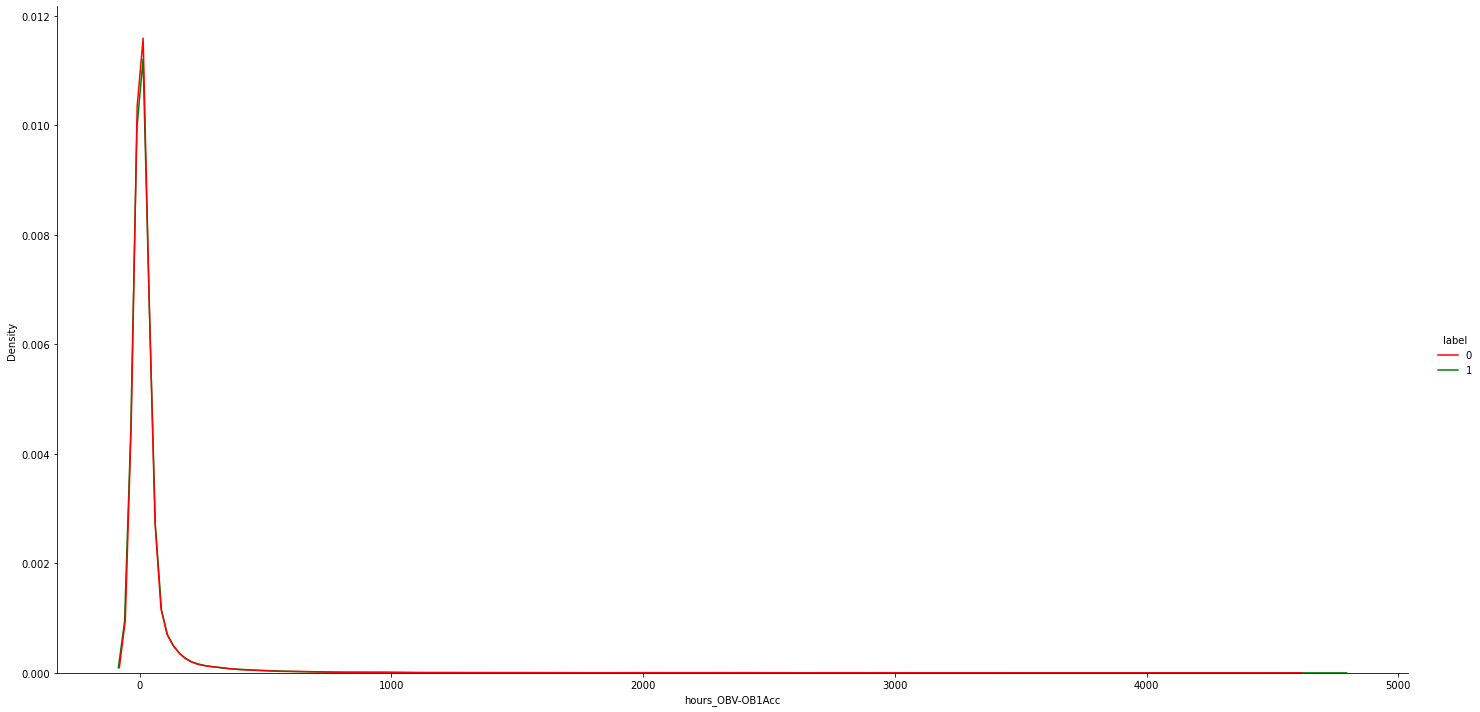

In [225]:
sns.displot(data=data, x="hours_OBV-OB1Acc", kind='kde', hue="label", common_norm=False, palette=["red","green"], height=10, aspect=2)

In [226]:
data.loc[data["hours_OBV-OB1Acc"]>np.quantile(data["hours_OBV-OB1Acc"],0.99),"hours_OBV-OB1Acc"]=np.quantile(data["hours_OBV-OB1Acc"],0.99)

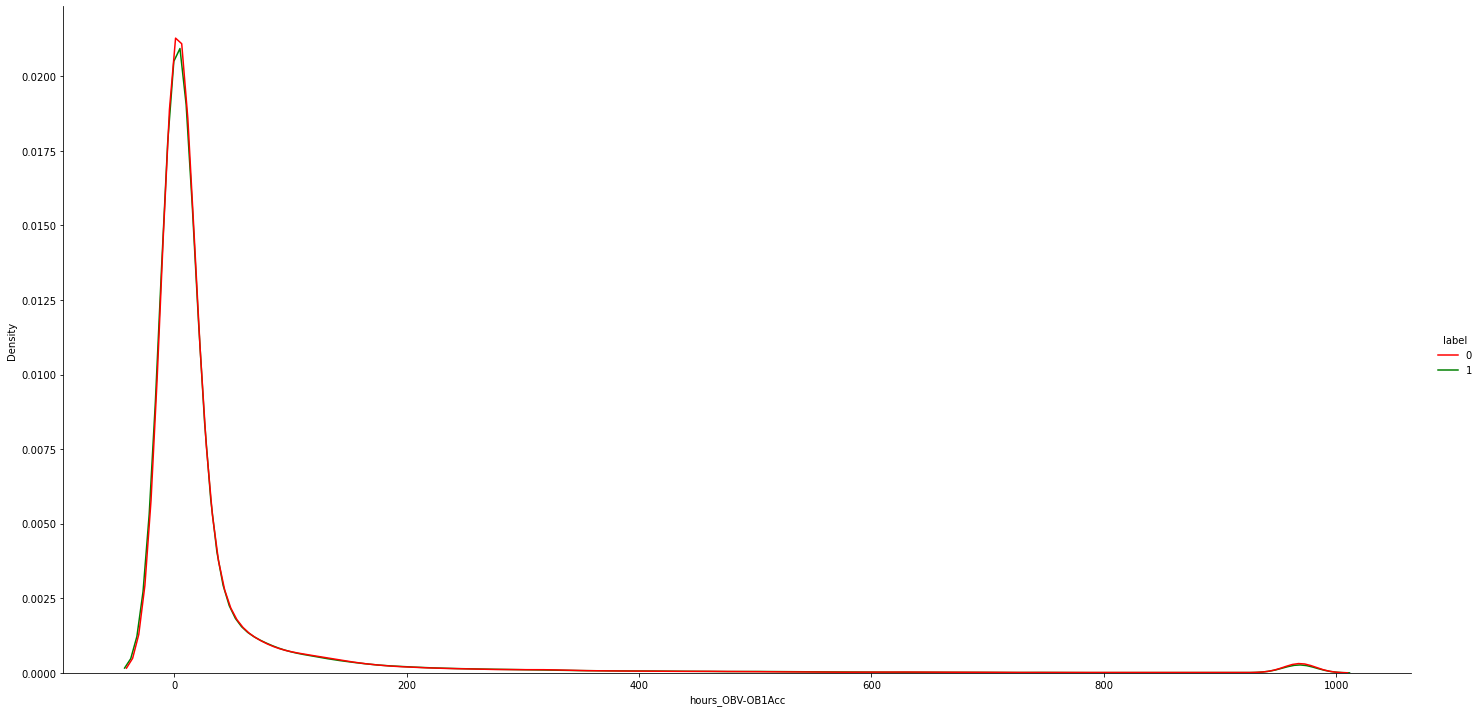

In [227]:
sns.displot(data=data, x="hours_OBV-OB1Acc", kind='kde', hue="label", common_norm=False, palette=["red","green"], height=10, aspect=2)

### Hours_OB1Acc-FTUc (Hours from adding the first account to the first successful transaction at the onboarding stage)

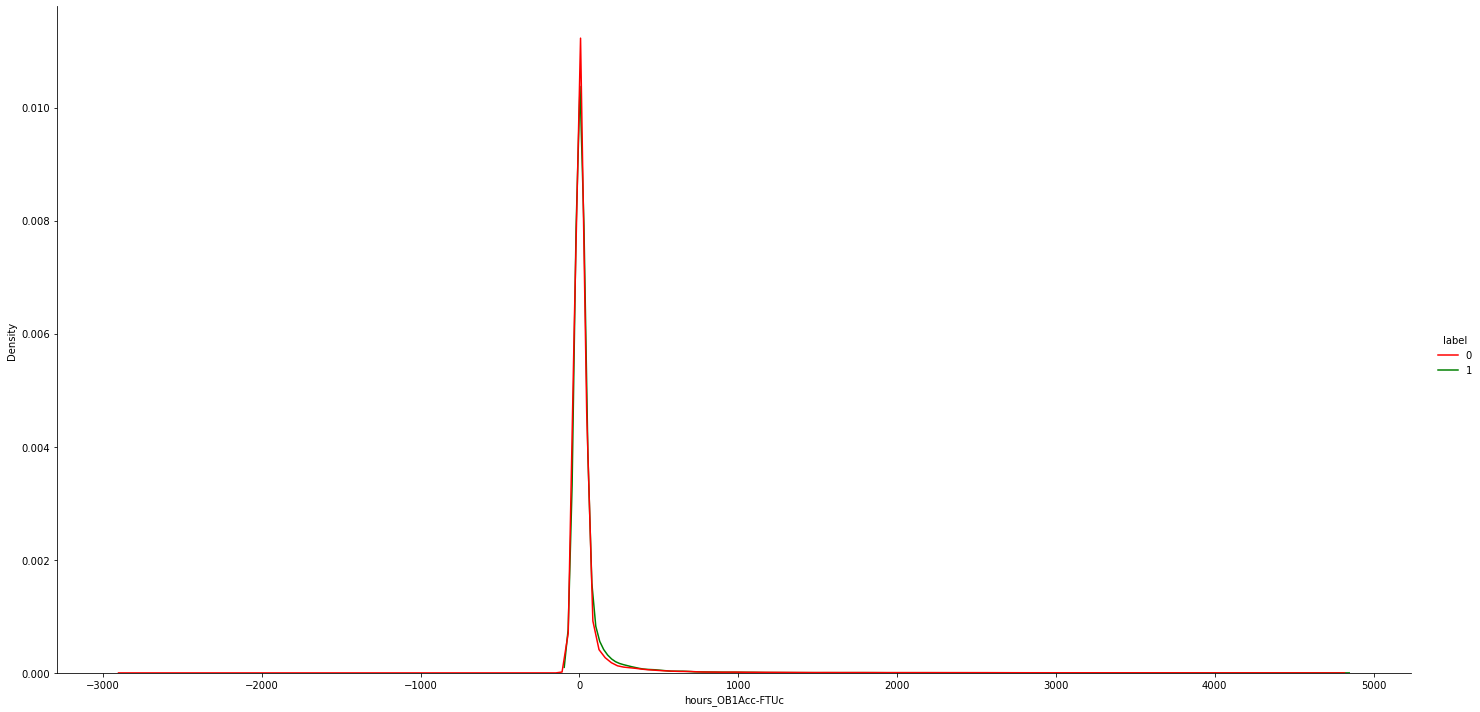

In [228]:
sns.displot(data=data, x="hours_OB1Acc-FTUc", kind='kde', hue="label", common_norm=False, palette=["red","green"], height=10, aspect=2)

In [229]:
data.loc[data["hours_OB1Acc-FTUc"]>np.quantile(data["hours_OB1Acc-FTUc"],0.99),"hours_OB1Acc-FTUc"]=np.quantile(data["hours_OB1Acc-FTUc"],0.99)

In [230]:
data.loc[data["hours_OB1Acc-FTUc"]<0,"hours_OB1Acc-FTUc"] = 0

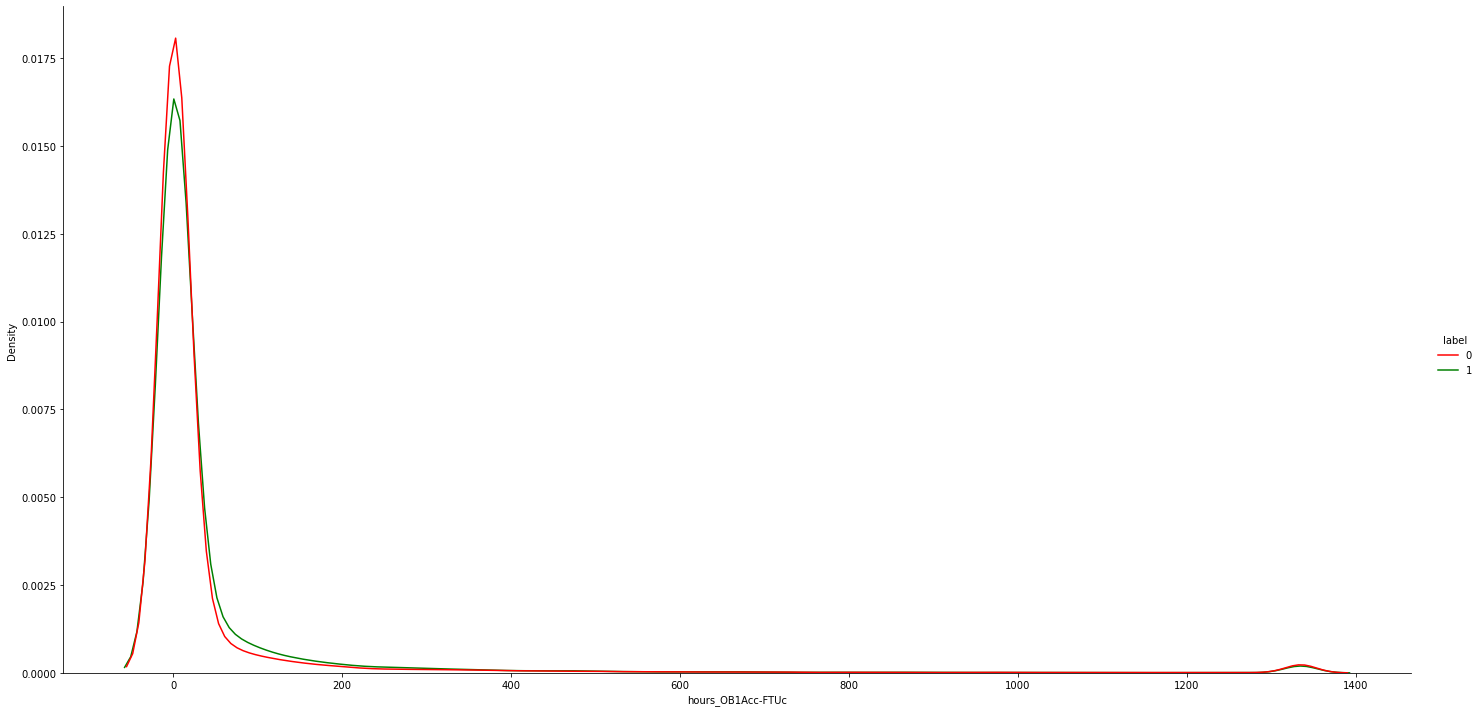

In [231]:
sns.displot(data=data, x="hours_OB1Acc-FTUc", kind='kde', hue="label", common_norm=False, palette=["red","green"], height=10, aspect=2)

<AxesSubplot:>

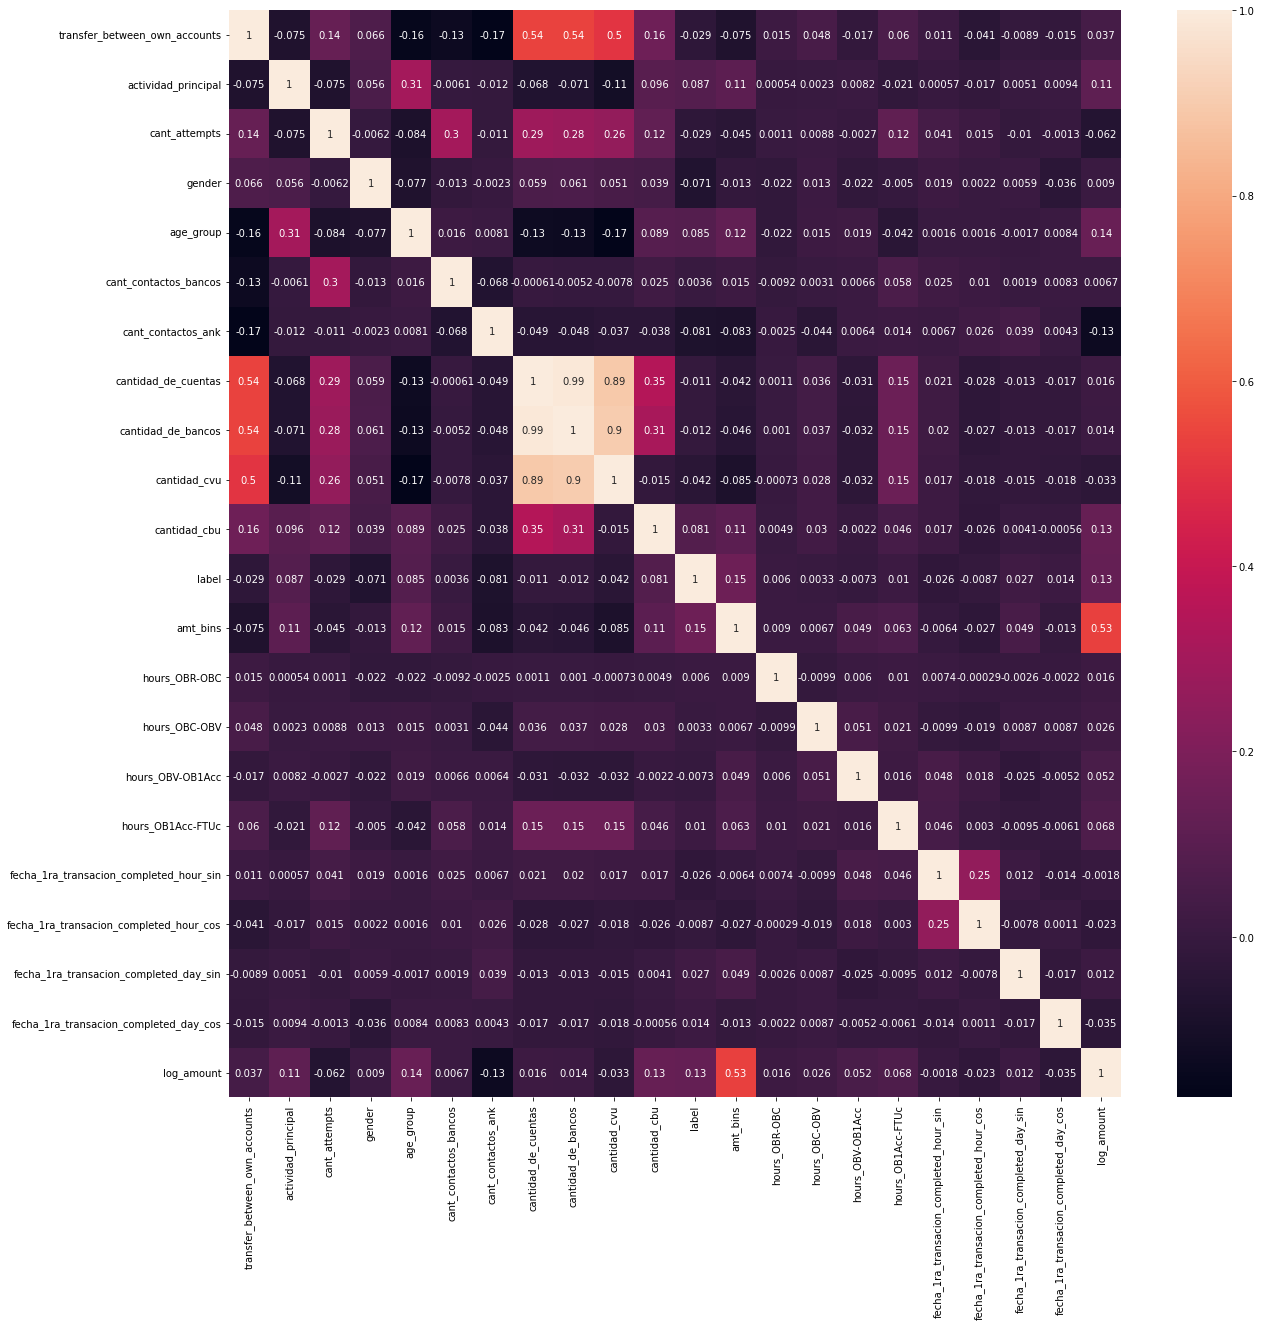

In [232]:
plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(method='pearson'), annot=True)
# Pearson
# Assumes that the variables follow a normal distribution
# Measures linear relationship between variables

<AxesSubplot:>

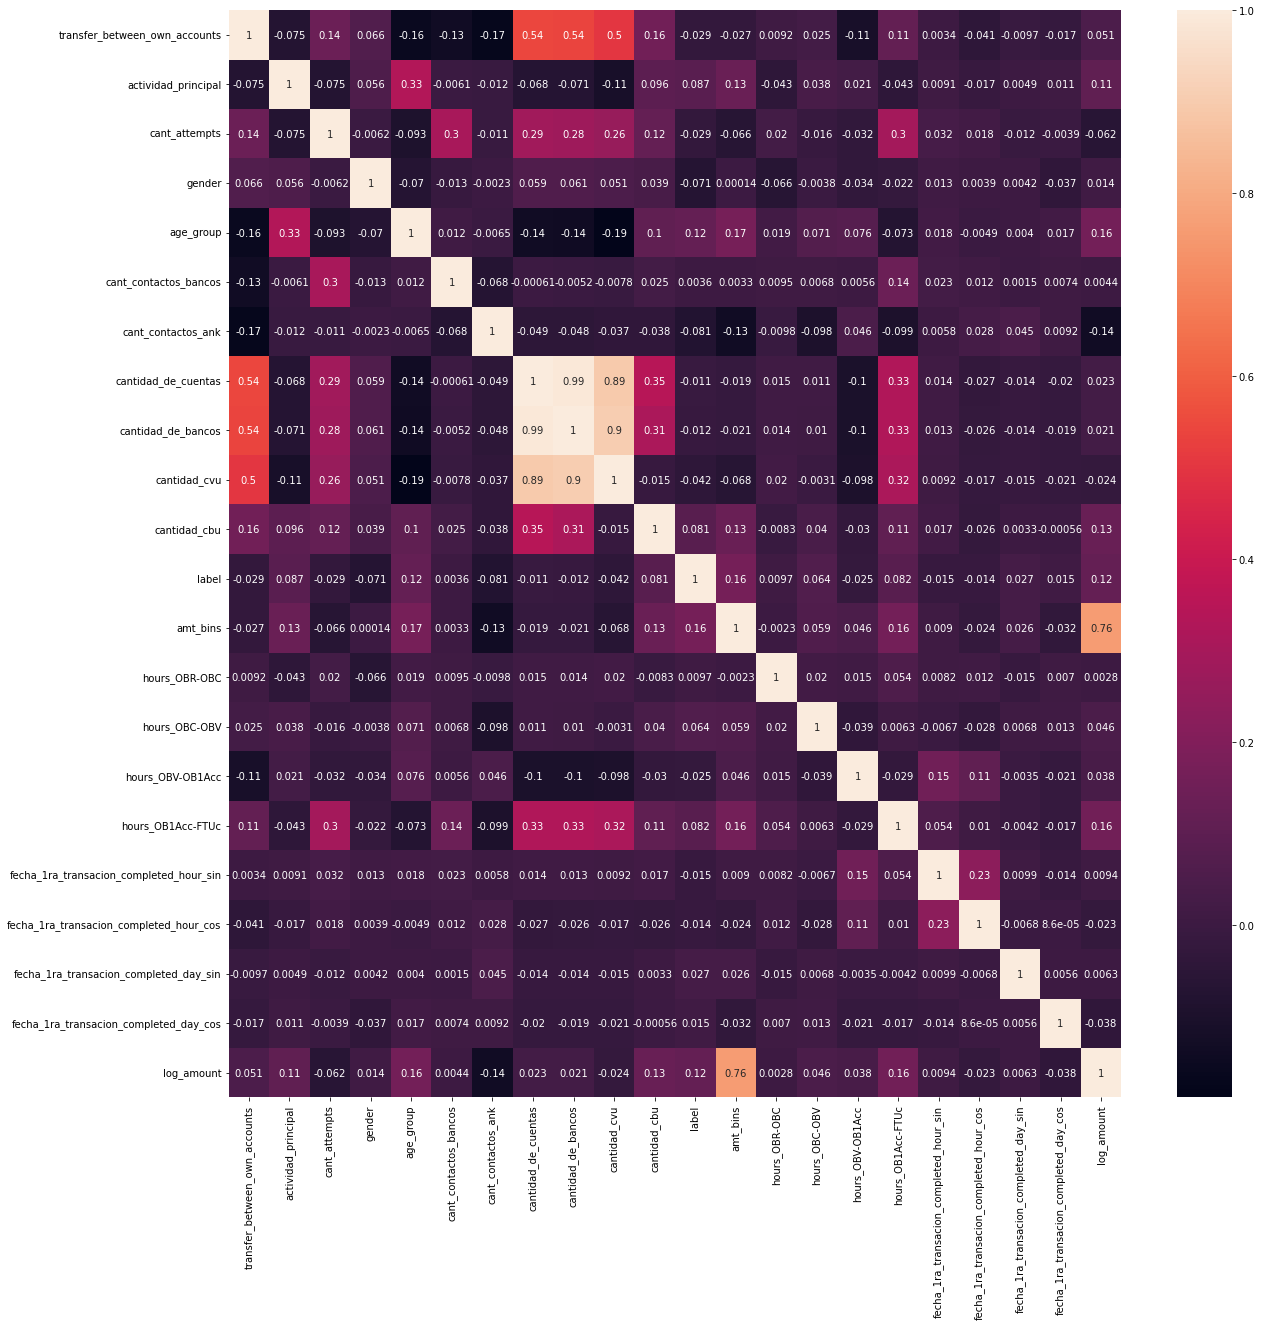

In [233]:
plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(method='spearman'),annot=True)
# Spearman
# Spearman's correlation evaluates the monotonic relationship between two continuous or ordinal variables.
# In a monotonic relationship, the variables tend to change at the same time, but not necessarily at a constant rate. 
# Spearman's correlation coefficient is based on the ranked values of each variable and not on the raw data.
# Spearman's correlation is often used to assess relationships involving ordinal variables.

# Feature Engineering

## Train/Test split

In [234]:
X = data.drop(["label"],axis=1)
y = data["label"]

In [235]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42, test_size=0.2, stratify=y)
# Importante agregar stratify = y para balancear en cada partición la distribución de valores de y
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(100596, 27) (25150, 27) (100596,) (25150,)


## Categorical encoding

In [236]:
var_ohe = ["canal","debit_account_bank","credit_account_bank","credit_account_type","lookup_key_type","prov_region"]

In [237]:
enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(X_train[var_ohe])
enc_train = pd.DataFrame(enc.transform(X_train[var_ohe]).toarray(),columns=enc.get_feature_names(), index=X_train.index)
enc_test = pd.DataFrame(enc.transform(X_test[var_ohe]).toarray(),columns=enc.get_feature_names(), index=X_test.index)

In [433]:
# Guardo el OHE
pickle.dump(enc, open('ohe.pkl', 'wb'))

In [238]:
X_train = X_train.drop(columns=var_ohe).join(enc_train)
X_test = X_test.drop(columns=var_ohe).join(enc_test)

In [239]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100596 entries, 740d1be9-abcf-42c8-9c5b-ac44b354f431 to 38645a51-0ee0-4b86-b7b3-3bec6fd01e36
Data columns (total 50 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   transfer_between_own_accounts            100596 non-null  int32  
 1   actividad_principal                      100596 non-null  int64  
 2   cant_attempts                            100596 non-null  int64  
 3   gender                                   100596 non-null  int64  
 4   age_group                                100596 non-null  int64  
 5   cant_contactos_bancos                    100596 non-null  int64  
 6   cant_contactos_ank                       100596 non-null  int64  
 7   cantidad_de_cuentas                      100596 non-null  int64  
 8   cantidad_de_bancos                       100596 non-null  int64  
 9   cantidad_cvu                             10

<AxesSubplot:>

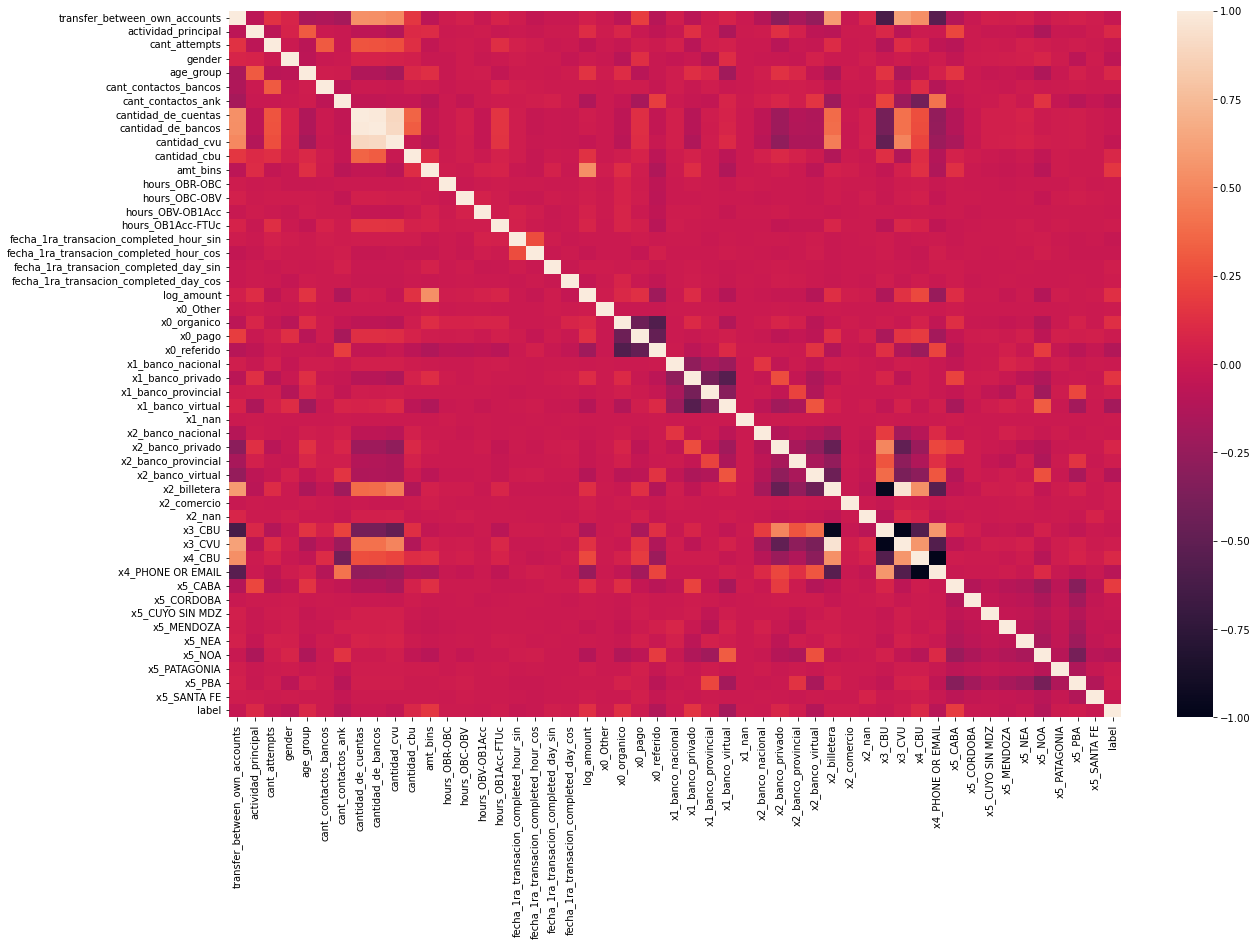

In [240]:
plt.subplots(figsize=(20,13))
sns.heatmap(X_train.join(y_train).corr(method='pearson'))

<AxesSubplot:>

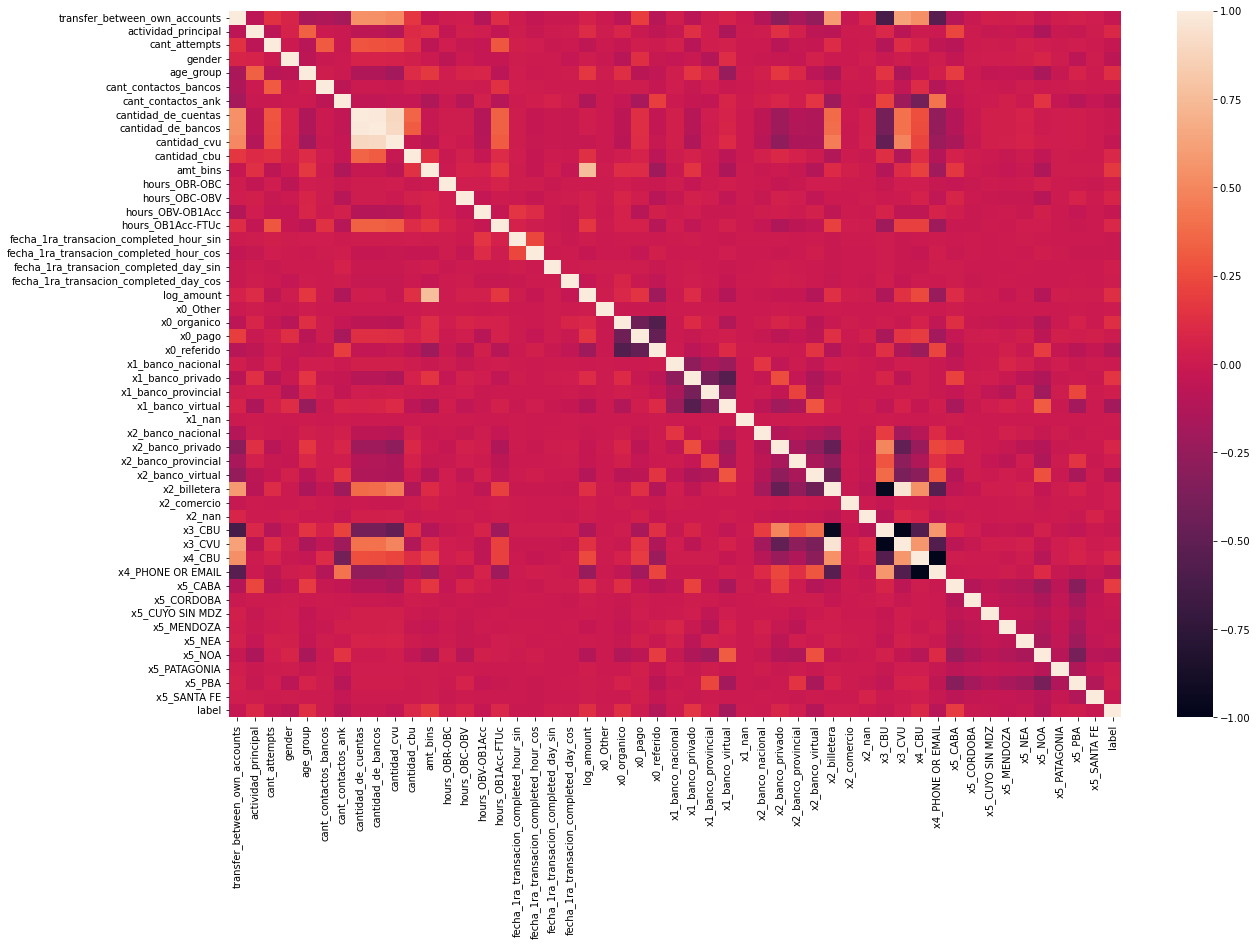

In [241]:
plt.subplots(figsize=(20,13))
sns.heatmap(X_train.join(y_train).corr(method='spearman'))

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=tsne_df.iloc[:,0], 
    ys=tsne_df.iloc[:,1], 
    zs=tsne_df.iloc[:,2], 
    c=tsne_df.label, 
)
ax.set_xlabel('tSNE-one')
ax.set_ylabel('tSNE-two')
ax.set_zlabel('tSNE-three')
plt.show()

## Información Mutua

C:\Users\fernando.garade\anaconda3\envs\churn_y1\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\fernando.garade\anaconda3\envs\churn_y1\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


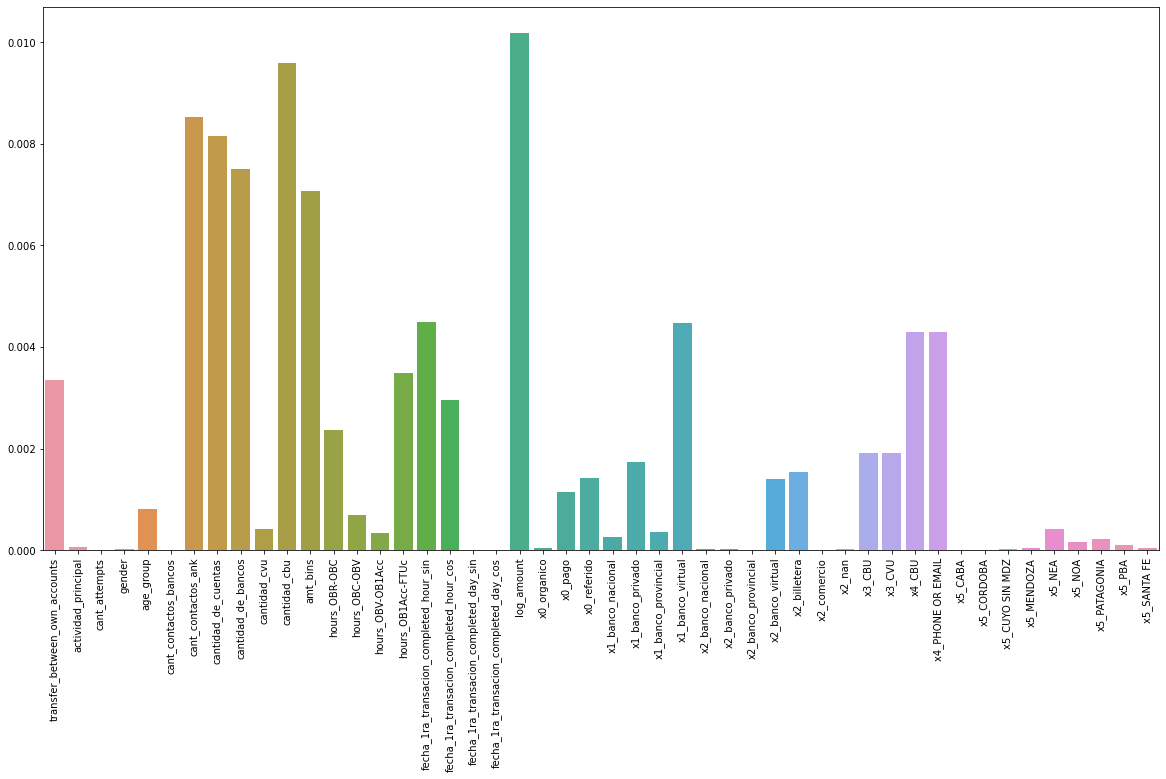

In [149]:
# Mutual Information
# The Mutual Information between two random variables X, Y with joint distribution p(x, y) is defined as:
# the divergence between the joint distribution and the distribution given by the product of the marginals p(x)p(y).
# The mutual information or trans-information of two random variables is a quantity that measures the mutual dependence 
# of the two variables, that is, measures the reduction in uncertainty (entropy) of a random variable, X,
# due to the knowledge of the value of another random variable Y

mi_dataframe=pd.DataFrame(mutual_info_classif(X=X_train_s, y=y_train, discrete_features=[0,1,3,4,11,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47]), index=X_train.columns)
plt.subplots(figsize=(20,10))
mut_info = sns.barplot(x=mi_dataframe.index, y=mi_dataframe[0].values)
for item in mut_info.get_xticklabels():
    item.set_rotation(90)

## Oversampling

We tested if with oversampling we could reach better performance

In [150]:
#Modelo benchmark
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train_s,y_train)
predicts = xgb.predict(X_test_s)
f1_score(y_test,predicts)
clf_report_test = classification_report(y_test,predicts)
print(clf_report_test)

[10:39:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     12444
           1       0.51      0.13      0.21      5465

    accuracy                           0.70     17909
   macro avg       0.61      0.54      0.51     17909
weighted avg       0.65      0.70      0.63     17909



## ADASYN

In [151]:
percentages_of_minor_major_class = [0.6,0.7,0.8,0.9,1]
for i in percentages_of_minor_major_class:
    print(i)
    ada = ADASYN(sampling_strategy=i)
    X_train_ada, y_train_ada = ada.fit_resample(X_train_s,y_train)
    xgbada = XGBClassifier(use_label_encoder=False)
    xgbada.fit(X_train_ada,y_train_ada)
    predictsada = xgbada.predict(X_test_s)
    print(f1_score(y_test,predictsada))
    clf_report_test_ada = classification_report(y_test,predictsada)
    print(clf_report_test_ada)

0.6
[10:39:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.20601987142022207
              precision    recall  f1-score   support

           0       0.71      0.95      0.81     12444
           1       0.51      0.13      0.21      5465

    accuracy                           0.70     17909
   macro avg       0.61      0.54      0.51     17909
weighted avg       0.65      0.70      0.63     17909

0.7
[10:40:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.2203291943401675
      

In [152]:
sampling_str = ['minority','not minority','not majority','all']
for i in sampling_str:
    print(i)
    ada = ADASYN(sampling_strategy=i)
    X_train_ada, y_train_ada = ada.fit_resample(X_train_s,y_train)
    xgbada = XGBClassifier(use_label_encoder=False)
    xgbada.fit(X_train_ada,y_train_ada)
    predictsada = xgbada.predict(X_test_s)
    print(f1_score(y_test,predictsada))
    clf_report_test_ada = classification_report(y_test,predictsada)
    print(clf_report_test_ada)

minority
[10:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.22873319179051663
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     12444
           1       0.51      0.15      0.23      5465

    accuracy                           0.70     17909
   macro avg       0.61      0.54      0.52     17909
weighted avg       0.65      0.70      0.63     17909

not minority
[10:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.211703208

ADASYN does not seem to help us achieve better performance.

## SMOTE

In [153]:
smote = SMOTE(sampling_strategy=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_s,y_train)

In [154]:
xgbsmote = XGBClassifier(use_label_encoder=False)
xgbsmote.fit(X_train_smote,y_train_smote)
predictssmote = xgbsmote.predict(X_test_s)
print(f1_score(y_test,predictssmote))
clf_report_test_smote = classification_report(y_test,predictssmote)
print(clf_report_test_smote)

[10:45:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.21844174410293063
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     12444
           1       0.50      0.14      0.22      5465

    accuracy                           0.69     17909
   macro avg       0.61      0.54      0.51     17909
weighted avg       0.65      0.69      0.63     17909



In [155]:
percentages_of_minor_major_class = [0.5,0.6,0.7,0.8,0.9,1]
for i in percentages_of_minor_major_class:
    print(i)
    smote = SMOTE(sampling_strategy=i)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_s,y_train)
    xgbsmote = XGBClassifier(use_label_encoder=False)
    xgbsmote.fit(X_train_smote,y_train_smote)
    predictssmote = xgbsmote.predict(X_test_s)
    print(f1_score(y_test,predictssmote))
    clf_report_test_smote = classification_report(y_test,predictssmote)
    print(clf_report_test_smote)

0.5
[10:45:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.21236872812135352
              precision    recall  f1-score   support

           0       0.71      0.95      0.81     12444
           1       0.52      0.13      0.21      5465

    accuracy                           0.70     17909
   macro avg       0.62      0.54      0.51     17909
weighted avg       0.66      0.70      0.63     17909

0.6
[10:45:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.21267297887836856
     

In [156]:
from imblearn.combine import SMOTETomek
smote = SMOTETomek()
X_train_smote, y_train_smote = smote.fit_resample(X_train_s,y_train)
xgbsmote = XGBClassifier(use_label_encoder=False)
xgbsmote.fit(X_train_smote,y_train_smote)
predictssmote = xgbsmote.predict(X_test_s)
print(f1_score(y_test,predictssmote))
clf_report_test_smote = classification_report(y_test,predictssmote)
print(clf_report_test_smote)

[10:49:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.21956490419247948
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     12444
           1       0.52      0.14      0.22      5465

    accuracy                           0.70     17909
   macro avg       0.62      0.54      0.52     17909
weighted avg       0.65      0.70      0.63     17909



In [157]:
from imblearn.combine import SMOTEENN
smote = SMOTEENN()
X_train_smote, y_train_smote = smote.fit_resample(X_train_s,y_train)
xgbsmote = XGBClassifier(use_label_encoder=False)
xgbsmote.fit(X_train_smote,y_train_smote)
predictssmote = xgbsmote.predict(X_test_s)
print(f1_score(y_test,predictssmote))
clf_report_test_smote = classification_report(y_test,predictssmote)
print(clf_report_test_smote)

[10:52:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4216987092697897
              precision    recall  f1-score   support

           0       0.75      0.74      0.74     12444
           1       0.42      0.43      0.42      5465

    accuracy                           0.64     17909
   macro avg       0.58      0.58      0.58     17909
weighted avg       0.64      0.64      0.64     17909



It seems that the SMOTE resampling method combined with the ENN undersampling method allows us to improve the performance of the model. We will explore different parameters of this method.

In [158]:
percentages_of_minor_major_class = [0.5,0.6,0.7,0.8,0.9,1]
for i in percentages_of_minor_major_class:
    print(i)
    smote = SMOTEENN(sampling_strategy=i)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_s,y_train)
    xgbsmote = XGBClassifier(use_label_encoder=False)
    xgbsmote.fit(X_train_smote,y_train_smote)
    predictssmote = xgbsmote.predict(X_test_s)
    print(f1_score(y_test,predictssmote))
    clf_report_test_smote = classification_report(y_test,predictssmote)
    print(clf_report_test_smote)

0.5
[10:54:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.15391791044776118
              precision    recall  f1-score   support

           0       0.71      0.96      0.81     12444
           1       0.51      0.09      0.15      5465

    accuracy                           0.70     17909
   macro avg       0.61      0.53      0.48     17909
weighted avg       0.65      0.70      0.61     17909

0.6
[10:56:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.2499320097905902
      

In [159]:
sampling_str =['minority','not minority','not majority','all']
for i in sampling_str:
    print(i)
    smote = SMOTEENN(sampling_strategy=i)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_s,y_train)
    xgbsmote = XGBClassifier(use_label_encoder=False)
    xgbsmote.fit(X_train_smote,y_train_smote)
    predictssmote = xgbsmote.predict(X_test_s)
    print(f1_score(y_test,predictssmote))
    clf_report_test_smote = classification_report(y_test,predictssmote)
    print(clf_report_test_smote)

minority
[11:12:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.42044623262618874
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     12444
           1       0.42      0.42      0.42      5465

    accuracy                           0.65     17909
   macro avg       0.58      0.58      0.58     17909
weighted avg       0.65      0.65      0.65     17909

not minority
[11:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.081881238

# Model training

We will use XGBoost as it was one of the best performing models so far.

## Baseline

### Baseline without oversampling

In [257]:
xgb_baseline_sin_os = XGBClassifier(use_label_encoder=False)
xgb_baseline_sin_os.fit(X_train_s,y_train)
print('Train results')
print(f1_score(y_train,xgb_baseline_sin_os.predict(X_train_s)))
print ("Accuracy (Train) : %.4g" % metrics.accuracy_score(y_train, xgb_baseline_sin_os.predict(X_train_s)))
print ("F1 Score (Train) : %.4g" % metrics.f1_score(y_train, xgb_baseline_sin_os.predict(X_train_s)))
print ("AUC Score (Train): %.4g" % metrics.roc_auc_score(y_train, xgb_baseline_sin_os.predict_proba(X_train_s)[:,1]))
print(classification_report(y_train,xgb_baseline_sin_os.predict(X_train_s)))

print('Test Results')
predict_baseline_sin_os = xgb_baseline_sin_os.predict(X_test_s)
print(f1_score(y_test,predict_baseline_sin_os))
clf_report_test_baseline_sin_os = classification_report(y_test,predict_baseline_sin_os)
print ("Accuracy (Test) : %.4g" % metrics.accuracy_score(y_test, predict_baseline_sin_os))
print ("F1 Score (Test) : %.4g" % metrics.f1_score(y_test, predict_baseline_sin_os))
print ("AUC Score (Test): %.4g" % metrics.roc_auc_score(y_test, xgb_baseline_sin_os.predict_proba(X_test_s)[:,1]))
print(clf_report_test_baseline_sin_os)

[18:36:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train results
0.5947032073846897
Accuracy (Train) : 0.7333
F1 Score (Train) : 0.5947
AUC Score (Train): 0.7932
              precision    recall  f1-score   support

           0       0.72      0.90      0.80     60363
           1       0.76      0.49      0.59     40233

    accuracy                           0.73    100596
   macro avg       0.74      0.69      0.70    100596
weighted avg       0.74      0.73      0.72    100596

Test Results
0.5102077906342763
Accuracy (Test) : 0.6785
F1 Score (Test) : 0.5102
AUC Score (Test): 0.6922
              precision    recall  f1-score   support

           0       0.69      0.85      0.76     15091
           1       0.65      0.42   

## Hyperparameter optimization

Como vamos a usar XGBoost no es necesario estandarizar/escalar los datos de entrada.

### Bayesian optimization
Complete guide here: https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [376]:
# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,5),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 15, 1),
        'n_estimators': hp.choice('n_estimators',[50, 100, 150, 200, 250, 400, 600]),
        'seed': 42,
        'scale_pos_weight': hp.quniform('scale_pos_weight', 0,10,1),
        'eta':hp.uniform('eta', 0,0.5), #It is analogous to learning rate in GBM.
        'max_delta_step': hp.quniform('max_delta_step', 0,10,1),
        'subsample': hp.uniform('subsample', 0.5,1)
    }
# Define objective function 
def objective(space):
    clf=xgb.XGBClassifier(use_label_encoder=False,
                    objective = 'binary:logistic',
                    eval_metric = 'logloss',
                    n_estimators =space['n_estimators'],
                    max_depth = int(space['max_depth']),
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    reg_lambda = int(space['reg_lambda']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
                    scale_pos_weight = int(space['scale_pos_weight']),
                    eta=space['eta'],
                    max_delta_step=int(space['max_delta_step']),
                    subsample=space['subsample'])
    
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1').mean()    

    return {'loss': -score, 'status': STATUS_OK }

# hp.choice(label, options) — Returns one of the options, which should be a list or tuple.
# hp.randint(label, upper) — Returns a random integer between the range [0, upper).
# hp.uniform(label, low, high) — Returns a value uniformly between low and high.
# hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.
# hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

In [377]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

100%|███████████████████████████████████████████████| 50/50 [27:01<00:00, 32.42s/trial, best loss: -0.5925115509657479]


In [378]:
print(best_hyperparams)

{'colsample_bytree': 0.5697733133831878, 'eta': 0.42612860795917085, 'gamma': 0.6341673173820563, 'max_delta_step': 9.0, 'max_depth': 12.0, 'min_child_weight': 4.0, 'n_estimators': 6, 'reg_alpha': 127.0, 'reg_lambda': 0.41979367638808995, 'scale_pos_weight': 2.0, 'subsample': 0.6312687060229414}


In [379]:
best_hyperparams = {'colsample_bytree': 0.5697733133831878, 'eta': 0.42612860795917085, 'gamma': 0.6341673173820563, 'max_delta_step': 9, 'max_depth': 12, 'min_child_weight': 4, 'n_estimators': 6, 'reg_alpha': 127, 'reg_lambda': 0.41979367638808995, 'scale_pos_weight': 2, 'subsample': 0.6312687060229414}
xgb_opt = XGBClassifier(**best_hyperparams, use_label_encoder=False,
                    objective = 'binary:logistic',
                    eval_metric = 'logloss')
xgb_opt.fit(X_train,y_train)
print('Train results')
print(f1_score(y_train,xgb_opt.predict(X_train)))
print ("Accuracy (Train) : %.4g" % metrics.accuracy_score(y_train, xgb_opt.predict(X_train)))
print ("F1 Score (Train) : %.4g" % metrics.f1_score(y_train, xgb_opt.predict(X_train)))
print ("AUC Score (Train): %.4g" % metrics.roc_auc_score(y_train, xgb_opt.predict_proba(X_train)[:,1]))
print(classification_report(y_train,xgb_opt.predict(X_train)))

print('Test Results')
predict_opt = xgb_opt.predict(X_test)
print(f1_score(y_test,predict_opt))
clf_report_test_opt = classification_report(y_test,predict_opt)
print ("Accuracy (Test) : %.4g" % metrics.accuracy_score(y_test, predict_opt))
print ("F1 Score (Test) : %.4g" % metrics.f1_score(y_test, predict_opt))
print ("AUC Score (Test): %.4g" % metrics.roc_auc_score(y_test, xgb_opt.predict_proba(X_test)[:,1]))
print(clf_report_test_opt)

Train results
0.6001885855073051
Accuracy (Train) : 0.608
F1 Score (Train) : 0.6002
AUC Score (Train): 0.6981
              precision    recall  f1-score   support

           0       0.75      0.52      0.62     60363
           1       0.51      0.74      0.60     40233

    accuracy                           0.61    100596
   macro avg       0.63      0.63      0.61    100596
weighted avg       0.65      0.61      0.61    100596

Test Results
0.59085009733939
Accuracy (Test) : 0.5989
F1 Score (Test) : 0.5909
AUC Score (Test): 0.6856
              precision    recall  f1-score   support

           0       0.74      0.52      0.61     15091
           1       0.50      0.72      0.59     10059

    accuracy                           0.60     25150
   macro avg       0.62      0.62      0.60     25150
weighted avg       0.64      0.60      0.60     25150



## Optimización bayesiana with oversampling

In [258]:
from imblearn import pipeline

In [259]:
# Initialize domain space for range of values
space_smote={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,5),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 15, 1),
        'n_estimators': hp.choice('n_estimators',[50, 100, 150, 200, 250, 400, 600]),
        'seed': 42,
        'scale_pos_weight': hp.quniform('scale_pos_weight', 0,10,1),
        'eta':hp.uniform('eta', 0,0.5), #It is analogous to learning rate in GBM.
        'max_delta_step': hp.quniform('max_delta_step', 0,10,1),
        'subsample': hp.uniform('subsample', 0.5,1)
    }
# Define objective function 
def objective_smote(space_smote):
    clf_smote=xgb.XGBClassifier(use_label_encoder=False,
                    objective = 'binary:logistic',
                    eval_metric = 'logloss',
                    n_estimators =space_smote['n_estimators'],
                    max_depth = int(space_smote['max_depth']),
                    gamma = space_smote['gamma'],
                    reg_alpha = int(space_smote['reg_alpha']),
                    reg_lambda = int(space_smote['reg_lambda']),
                    min_child_weight=int(space_smote['min_child_weight']),
                    colsample_bytree=int(space_smote['colsample_bytree']),
                    scale_pos_weight = int(space_smote['scale_pos_weight']),
                    eta=space_smote['eta'],
                    max_delta_step=int(space_smote['max_delta_step']),
                    subsample=space_smote['subsample'])
    
    imba_pipeline = pipeline.make_pipeline(SMOTEENN(), clf_smote)    
    score = cross_val_score(imba_pipeline, X_train_s, y_train, cv=5, scoring='f1').mean()    

    return {'loss': -score, 'status': STATUS_OK }

# hp.choice(label, options) — Returns one of the options, which should be a list or tuple.
# hp.randint(label, upper) — Returns a random integer between the range [0, upper).
# hp.uniform(label, low, high) — Returns a value uniformly between low and high.
# hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.
# hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

In [265]:
trials_smote = Trials()

best_hyperparams_smote = fmin(fn = objective_smote,
                        space = space_smote,
                        algo = tpe.suggest,
                        max_evals = 5,
                        trials = trials_smote)

100%|██████████████████████████████████████████████| 5/5 [1:14:20<00:00, 892.12s/trial, best loss: -0.5846373267864449]


In [266]:
print(best_hyperparams_smote)

{'colsample_bytree': 0.9523927881014875, 'eta': 0.48598634526434875, 'gamma': 3.6135099731157077, 'max_delta_step': 4.0, 'max_depth': 10.0, 'min_child_weight': 14.0, 'n_estimators': 4, 'reg_alpha': 93.0, 'reg_lambda': 0.477930425822073, 'scale_pos_weight': 9.0, 'subsample': 0.9583168069476948}


No improvement is seen when using the model with oversampling versus the model without oversampling, so we will stick with the model without oversampling.

# Final Model

In [402]:
best_hyperparams = {'colsample_bytree': 0.5697733133831878, 'eta': 0.42612860795917085, 'gamma': 0.6341673173820563, 'max_delta_step': 9, 'max_depth': 12, 'min_child_weight': 4, 'n_estimators': 6, 'reg_alpha': 127, 'reg_lambda': 0.41979367638808995, 'scale_pos_weight': 2, 'subsample': 0.6312687060229414}
xgb_final = XGBClassifier(**best_hyperparams, use_label_encoder=False, objective = 'binary:logistic', eval_metric = 'logloss')
xgb_final.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5697733133831878,
              eta=0.42612860795917085, eval_metric='logloss',
              gamma=0.6341673173820563, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.426128596,
              max_delta_step=9, max_depth=12, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=6, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=127,
              reg_lambda=0.41979367638808995, scale_pos_weight=2,
              subsample=0.6312687060229414, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [403]:
y_test_predict = xgb_final.predict_proba(X_test)[:,1]

In [404]:
y_test_predict_with_y_true = np.zeros(shape=(y_test_predict.shape[0],2))

In [405]:
y_test_predict_with_y_true[:,0] = y_test_predict
y_test_predict_with_y_true[:,1] = y_test

In [425]:
users_with_less_than_low_threshold = pd.DataFrame(y_test_predict_with_y_true[y_test_predict_with_y_true[:,0]<0.42,:])

In [426]:
correct_predictions_low = len(users_with_less_than_low_threshold.loc[users_with_less_than_low_threshold[1]==0,:])
incorrect_predictions_low = len(users_with_less_than_low_threshold.loc[users_with_less_than_low_threshold[1]==1,:])

In [427]:
print(correct_predictions_low)
print(incorrect_predictions_low)
print(correct_predictions_low/len(users_with_less_than_low_threshold))
print(incorrect_predictions_low/len(users_with_less_than_low_threshold))
print(correct_predictions_low + incorrect_predictions_low)

2890
850
0.7727272727272727
0.22727272727272727
3740


In [421]:
users_with_more_than_upper_threshold = pd.DataFrame(y_test_predict_with_y_true[y_test_predict_with_y_true[:,0]>0.8,:])

correct_predictions_up = len(users_with_more_than_upper_threshold.loc[users_with_more_than_upper_threshold[1]==1,:])
incorrect_predictions_up = len(users_with_more_than_upper_threshold.loc[users_with_more_than_upper_threshold[1]==0,:])

print(correct_predictions_up)
print(incorrect_predictions_up)
print(correct_predictions_up/len(users_with_more_than_upper_threshold))
print(incorrect_predictions_up/len(users_with_more_than_upper_threshold))
print(correct_predictions_up + incorrect_predictions_up)

1213
218
0.8476589797344515
0.15234102026554858
1431


In [428]:
correct_predictions_low/len(y_test)

0.11491053677932406

In [429]:
correct_predictions_up/len(y_test)

0.04823061630218688

Save model to file

In [434]:
pickle.dump(xgb_final, open("model_trained.pkl", "wb"))

In [3]:
mm = pickle.load(open("model_trained.pkl", "rb"))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

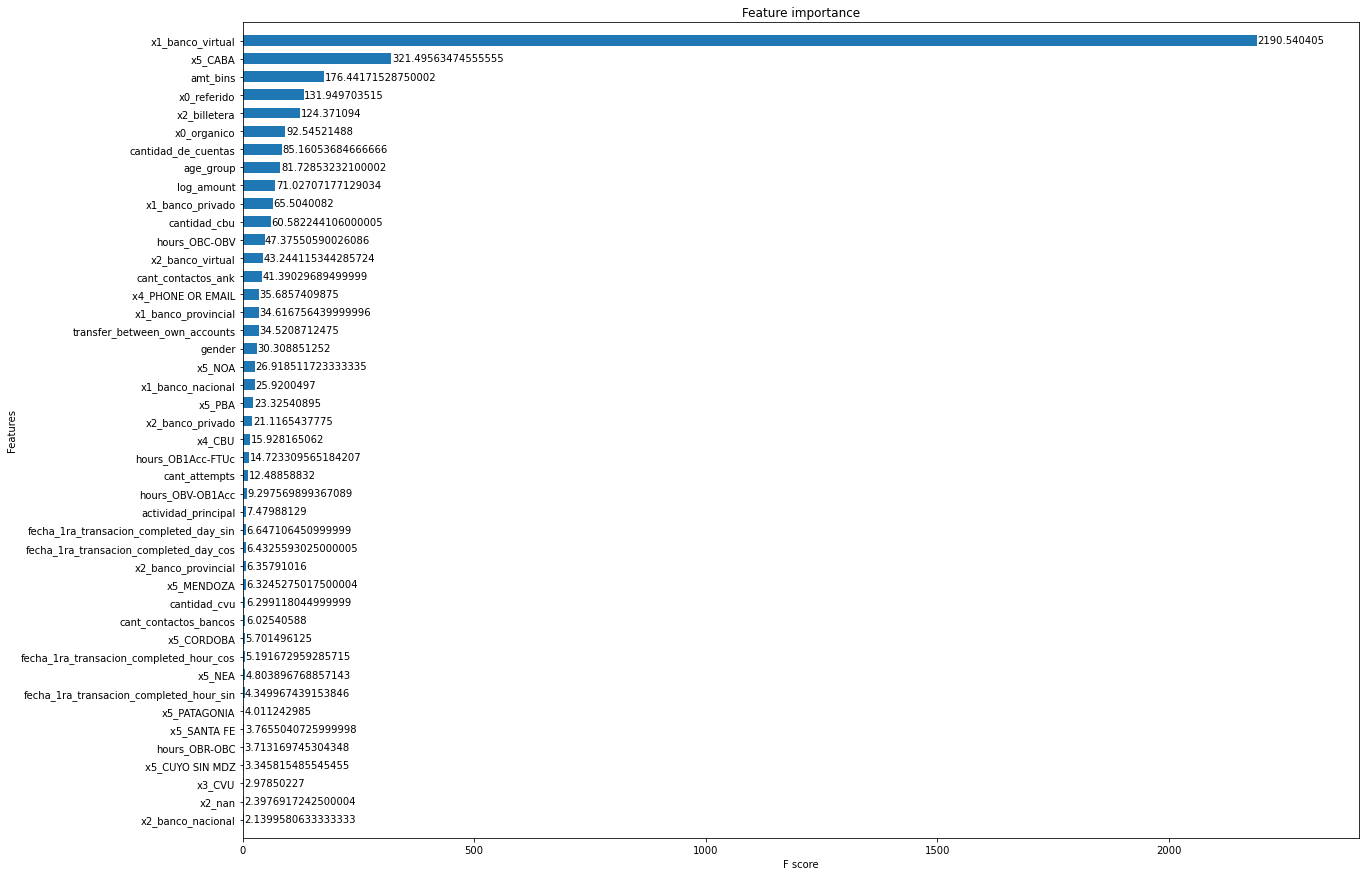

In [27]:
#https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
fig,ax = plt.subplots(1,1,figsize=(20,15))
plot_importance(mm, height=0.6, ax = ax, grid=False, importance_type='gain')